# 1. Import

In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, recall_score, precision_score

from sklearn.model_selection import StratifiedKFold, cross_validate

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Exploratory data analysis

## EDA - extrait_sirh.csv

Ce fichier **extrait_sirh.csv** contient les informations concernant les employés (âge, poste, ancienneté, sociodémographiques, etc.)

- 1470 lignes et 12 colonnes, aucunes valeurs manquantes.

- 4 colonnes catégorielles

- 8 colonnes numériques (int64)

- La colonne `id_employee` nous servira de clé primaire 

In [3]:
df_sirh = pd.read_csv('extrait_sirh.csv')

In [4]:
df_sirh.head(10)

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2
5,8,32,M,3068,Célibataire,Consulting,Consultant,0,80,8,7,7
6,10,59,F,2670,Marié(e),Consulting,Consultant,4,80,12,1,0
7,11,30,M,2693,Divorcé(e),Consulting,Consultant,1,80,1,1,0
8,12,38,M,9526,Célibataire,Consulting,Tech Lead,0,80,10,9,7
9,13,36,M,5237,Marié(e),Consulting,Manager,6,80,17,7,7


In [5]:
df_sirh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travailless       1470 non-null   int64 
 9   annee_experience_totale         1470 non-null   int64 
 10  annees_dans_l_entreprise        1470 non-null   int64 
 11  annees_dans_le_poste_actuel     1470 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 137.9+ KB


In [6]:
# On vérifie qu'il n'y a pas de doublons dans l'identifiant des employés
df_sirh["id_employee"].duplicated().sum()

np.int64(0)

In [7]:
# Statistiques descriptives des colonnes numériques
num_cols = df_sirh.select_dtypes(include=['number']).columns.drop('id_employee')
df_sirh[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,1470.0,36.923810,9.135373,18.0,30.0,36.0,43.0,60.0
revenu_mensuel,1470.0,6502.931293,4707.956783,1009.0,2911.0,4919.0,8379.0,19999.0
nombre_experiences_precedentes,1470.0,2.693197,2.498009,0.0,1.0,2.0,4.0,9.0
nombre_heures_travailless,1470.0,80.000000,0.000000,80.0,80.0,80.0,80.0,80.0
annee_experience_totale,1470.0,11.279592,7.780782,0.0,6.0,10.0,15.0,40.0
annees_dans_l_entreprise,1470.0,7.008163,6.126525,0.0,3.0,5.0,9.0,40.0
annees_dans_le_poste_actuel,1470.0,4.229252,3.623137,0.0,2.0,3.0,7.0,18.0


- Colonne `id_employee` : les statistiques pas pertinent
- Colonne `age` : range (18 ; 60) ans, moyenne proche de la médiane (36,92 VS 36) -> quasi-symétrie
- Colonne `revenu_mensuel` : range (1009 ; 19999), moyenne plus élevé que la médiane (6502 VS 4919) -> asymétrie
- Colonne `nombre_experiences_precedentes` : range (0 ; 9), moyenne et médiane prochent -> quasi-symétrie. Du débutant au Senior
- Colonne `nombre_heures_travailless` : tout le monde travail 80 heures par semaines. C'est une constate
- Colonne `annee_experience_totale` : range (0 ; 40), moyenne proche de la médiane -> quasi-symétrie. Du débutant au Senior
- Colonne `annees_dans_l_entreprise` : range (0 ; 40), asymétrie, du nouveau au senior
- Colonne `annees_dans_le_poste_actuel` : range (0 ; 18), asymétrie, de débutant à l'expert

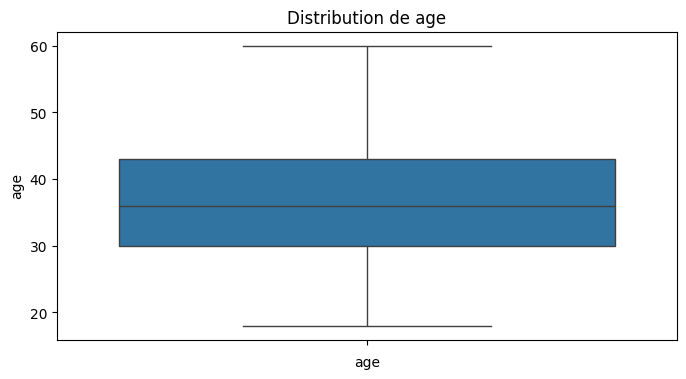

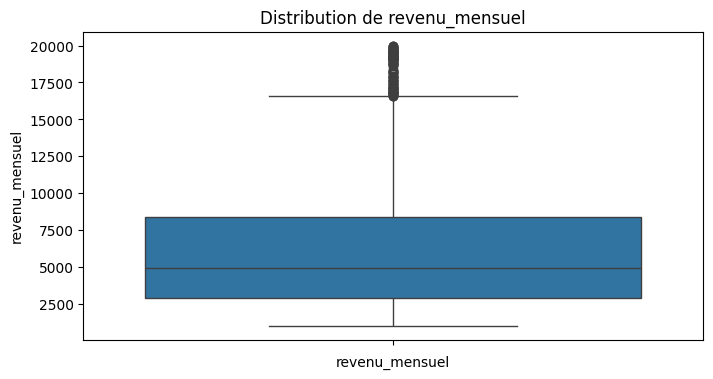

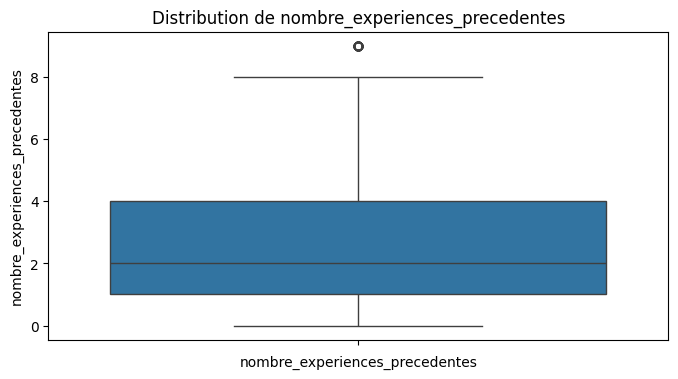

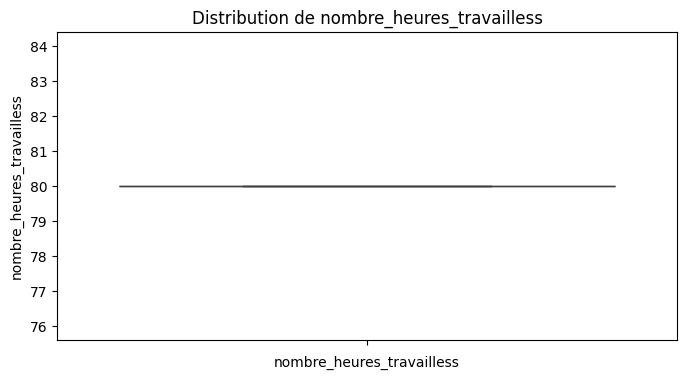

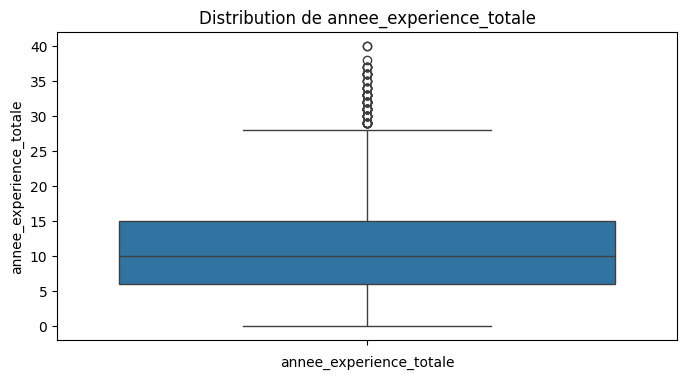

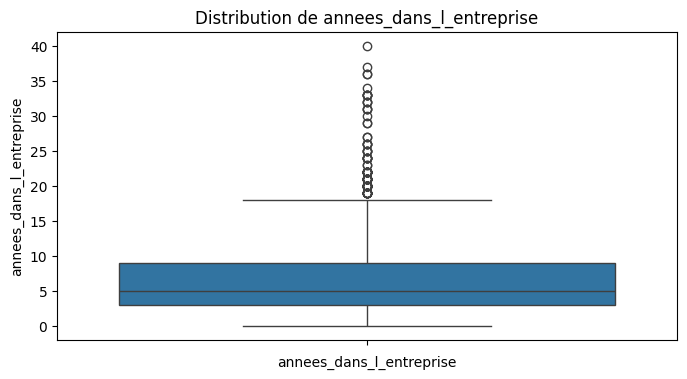

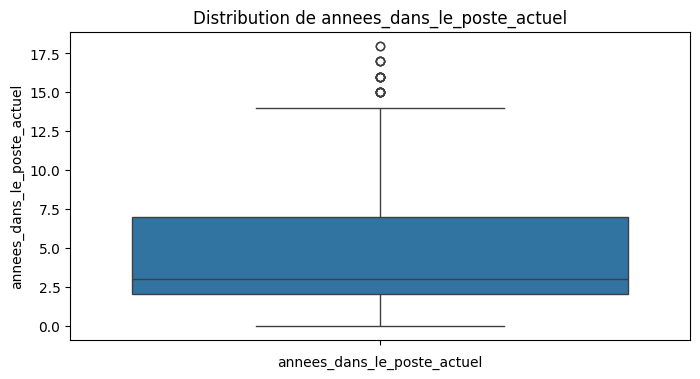

In [8]:
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(df_sirh[col])
    plt.xlabel(col)
    plt.title(f'Distribution de {col}')
    plt.show()

In [9]:
cat_cols = df_sirh.select_dtypes(include=['object']).columns
for col in cat_cols:
    print(f"Colonne '{col}' :")
    print(df_sirh[col].value_counts())
    print("\n")

Colonne 'genre' :
genre
M    882
F    588
Name: count, dtype: int64


Colonne 'statut_marital' :
statut_marital
Marié(e)       673
Célibataire    470
Divorcé(e)     327
Name: count, dtype: int64


Colonne 'departement' :
departement
Consulting             961
Commercial             446
Ressources Humaines     63
Name: count, dtype: int64


Colonne 'poste' :
poste
Cadre Commercial           326
Assistant de Direction     292
Consultant                 259
Tech Lead                  145
Manager                    131
Senior Manager             102
Représentant Commercial     83
Directeur Technique         80
Ressources Humaines         52
Name: count, dtype: int64




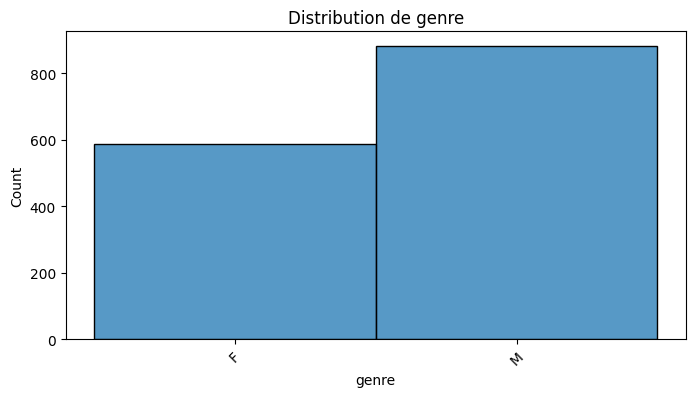

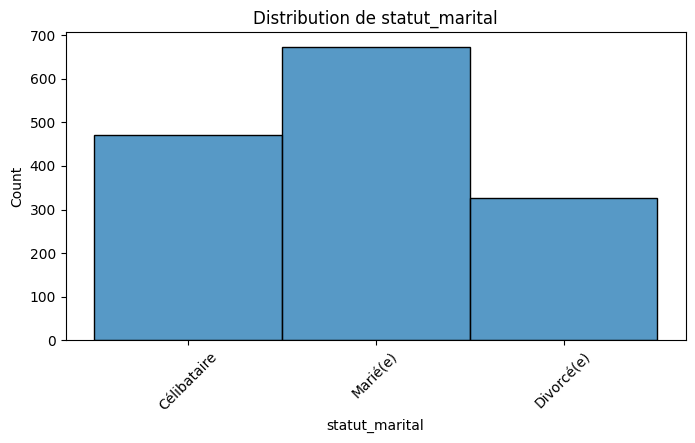

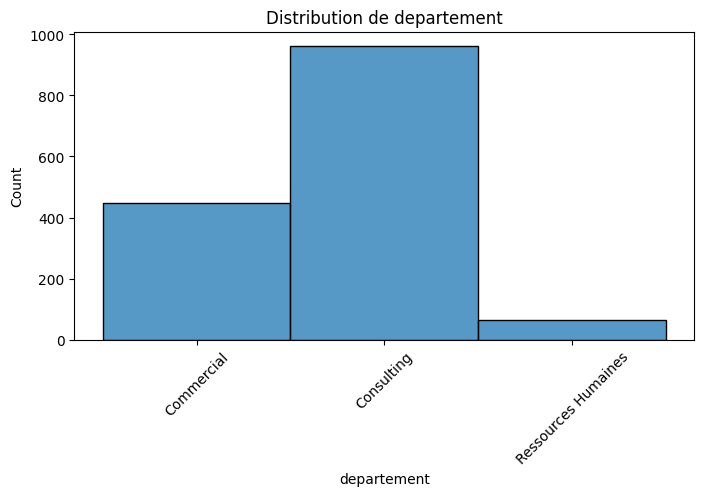

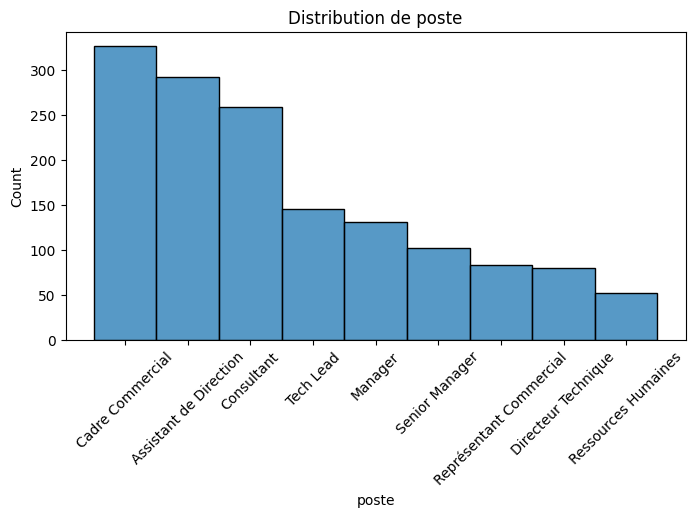

In [10]:
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df_sirh[col])
    plt.xlabel(col)
    plt.title(f'Distribution de {col}')
    plt.xticks(rotation=45)
    plt.show()

- Colonne `genre` : il y a plus d'homme (60%) que de femme (40%)
- Colonne `statut_marital` : 45,78% des employés sont mariés, les autres sont soit célibataires (31,97%), soit divorcés (22,25%)
- Colonne `departement` : Conslting (65,37%), Commercial (30,35) et RH (4,28%)
- Colonne `poste` : 9 postes : Cadre Commercial (22,18%), Assistant de Direction (19,86%), Consultant (17,62%), Tech Lead (9,86%), Manager (8,91%), Senior Manager (6,94%), Représentant Commercial (5,65%), Directeur Technique (5,44%) et Ressources Humaines (3,54%)

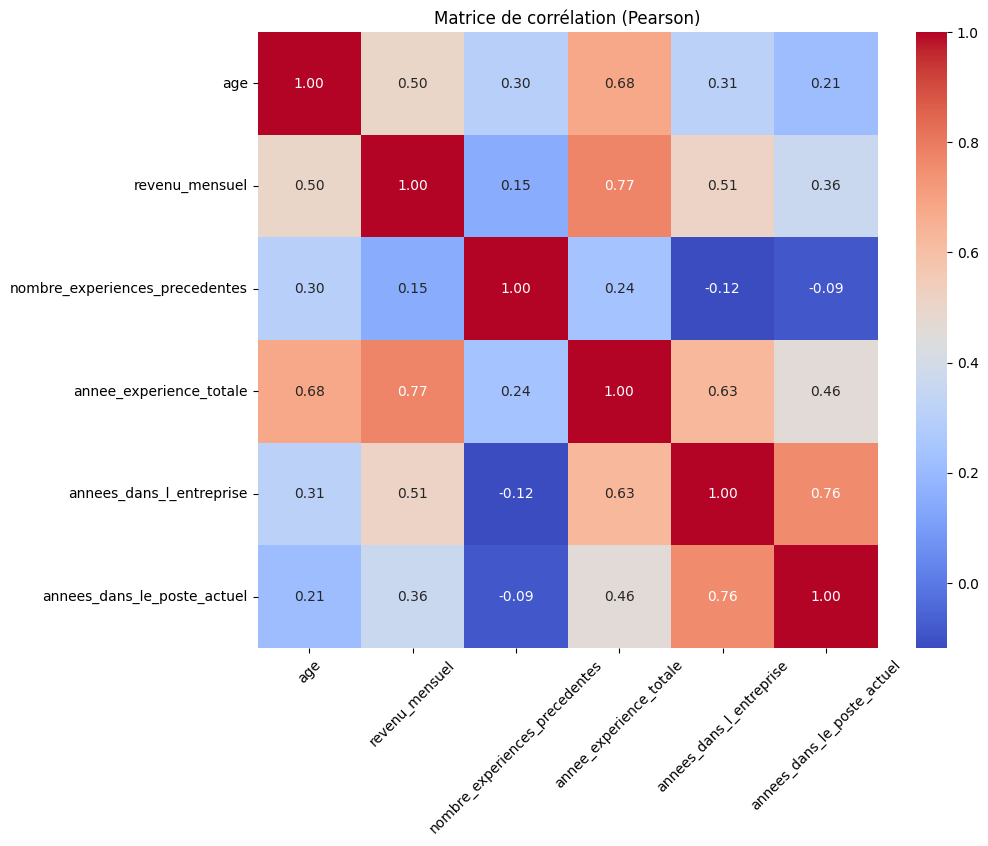

In [11]:
drop_cols = ['id_employee','nombre_heures_travailless']
num_cols = df_sirh.select_dtypes(include=['number']).columns.drop(drop_cols)
pearson_corr = df_sirh[num_cols].corr('pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation (Pearson)')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Seuil de forte corrélation
threshold = 0.7

# Liste pour stocker les paires de colonnes fortement corrélées
strongly_correlated_pairs = []
for i in range(len(num_cols)):
    for j in range(i + 1, len(num_cols)):
        corr_value = pearson_corr.iloc[i, j]
        if abs(corr_value) > threshold:
            strongly_correlated_pairs.append((num_cols[i], num_cols[j], corr_value))

# Affichage des paires de colonnes fortement corrélées
for col1, col2, corr in strongly_correlated_pairs:
    print(f"Colonnes fortement corrélées : {col1} et {col2} avec une corrélation de {corr:.2f}")


Colonnes fortement corrélées : revenu_mensuel et annee_experience_totale avec une corrélation de 0.77
Colonnes fortement corrélées : annees_dans_l_entreprise et annees_dans_le_poste_actuel avec une corrélation de 0.76


- `revenu_mensuel` & `annee_experience_totale` : c'est un résultat très logique et attendu dans le monde du travail. Plus un employé a d'expérience professionnelle (total des années), plus son salaire est généralement élevé. C'est une relation directe entre l'ancienneté dans le monde du travail et la rémunération. C'est une variable très importante à prendre en compte.

- `annees_dans_l_entreprise` & `annees_dans_le_poste_actuel` : ce résultat suggère que les employés restent souvent dans le même poste pendant la majeure partie de leur carrière au sein de l'entreprise.

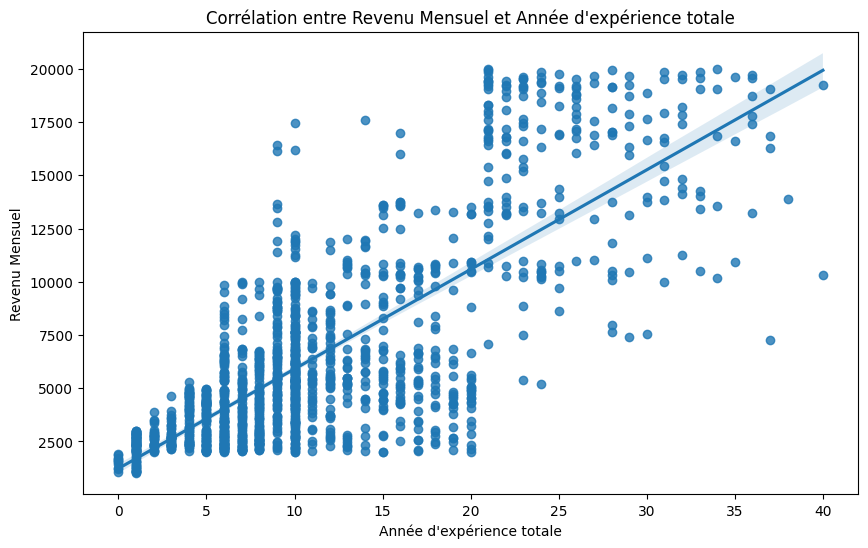

In [13]:
# Créer un nuage de points avec une ligne de régression
plt.figure(figsize=(10, 6))
sns.regplot(x='annee_experience_totale', y='revenu_mensuel', data=df_sirh)
plt.title('Corrélation entre Revenu Mensuel et Année d\'expérience totale')
plt.xlabel('Année d\'expérience totale')
plt.ylabel('Revenu Mensuel')
plt.show()

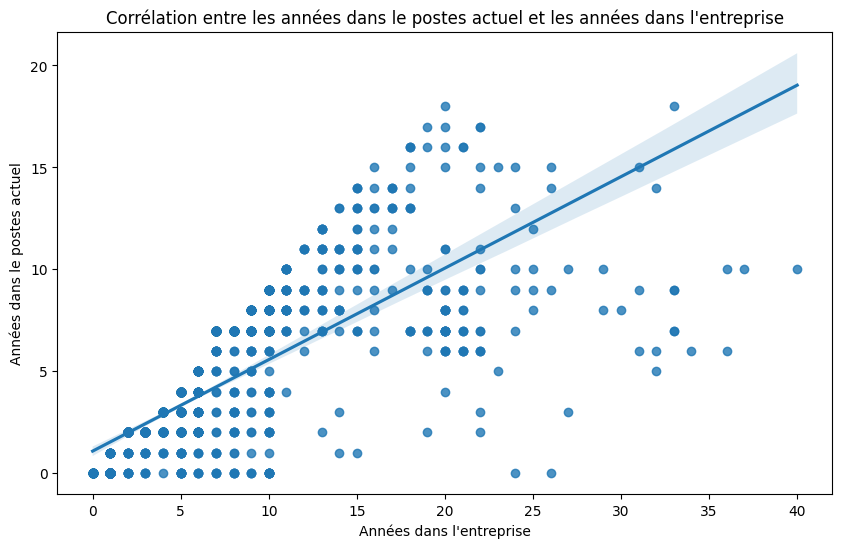

In [14]:
# Créer un nuage de points avec une ligne de régression
plt.figure(figsize=(10, 6))
sns.regplot(x='annees_dans_l_entreprise', y='annees_dans_le_poste_actuel', data=df_sirh)
plt.title('Corrélation entre les années dans le postes actuel et les années dans l\'entreprise')
plt.xlabel('Années dans l\'entreprise')
plt.ylabel('Années dans le postes actuel')
plt.show()

## EDA - extrait_eval.csv

Ce fichier **extrait_eval.csv** contient les évaluations annuelles de performance (note d'évaluation et note satisfaction client) des employés

- 1470 lignes et 10 colonnes, aucunes valeurs manquantes
- 7 colonnes numériques
- 3 colonnes catégorielles :
    - nous pouvons transformer la colonne `eval_number` en numérique
    - la colonne `heure_supplementaires` peut être convertit en une colonne contenant uniquement des 1 (pour OUI) et 0 (pour NON)
    - la colonne `augmentation_salaire_precedente` peut aussi être transformer en numérique

In [15]:
df_eval = pd.read_csv('extrait_eval.csv')
df_eval.head(10)

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %
3,4,3,1,3,3,3,E_5,3,Oui,11 %
4,1,3,1,2,4,3,E_7,3,Non,12 %
5,4,3,1,4,3,2,E_8,3,Non,13 %
6,3,4,1,1,1,2,E_10,4,Oui,20 %
7,4,3,1,3,2,3,E_11,4,Non,22 %
8,4,2,3,3,2,3,E_12,4,Non,21 %
9,3,3,2,3,2,2,E_13,3,Non,13 %


In [16]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non-null   object
 7   note_evaluation_actuelle                   1470 non-null   int64 
 8   heure_supplementaires                      1470 non-null   object
 9   augementation_salaire_precedente           1470 non-null   object
dtypes: int64(7), object(3)
memory usage:

Transformation des colonnes catégorielles en numériques

In [17]:
df_eval["heure_supplementaires"].value_counts()

heure_supplementaires
Non    1054
Oui     416
Name: count, dtype: int64

In [18]:
df_eval['heure_supplementaires'] = df_eval['heure_supplementaires'].replace({'Oui': 1, 'Non': 0})
df_eval['heure_supplementaires'].dtypes

C:\Users\artur\AppData\Local\Temp\ipykernel_22880\4064574001.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eval['heure_supplementaires'] = df_eval['heure_supplementaires'].replace({'Oui': 1, 'Non': 0})


dtype('int64')

In [19]:
df_eval['eval_number'].value_counts()

eval_number
E_1       1
E_2       1
E_4       1
E_5       1
E_7       1
E_8       1
E_10      1
E_11      1
E_12      1
E_13      1
E_14      1
E_15      1
E_16      1
E_18      1
E_19      1
E_20      1
E_21      1
E_22      1
E_23      1
E_24      1
E_26      1
E_27      1
E_28      1
E_30      1
E_31      1
E_32      1
E_33      1
E_35      1
E_36      1
E_38      1
E_39      1
E_40      1
E_41      1
E_42      1
E_45      1
E_46      1
E_47      1
E_49      1
E_51      1
E_52      1
E_53      1
E_54      1
E_55      1
E_56      1
E_57      1
E_58      1
E_60      1
E_61      1
E_62      1
E_63      1
E_64      1
E_65      1
E_68      1
E_70      1
E_72      1
E_73      1
E_74      1
E_75      1
E_76      1
E_77      1
E_78      1
E_79      1
E_80      1
E_81      1
E_83      1
E_84      1
E_85      1
E_86      1
E_88      1
E_90      1
E_91      1
E_94      1
E_95      1
E_96      1
E_97      1
E_98      1
E_100     1
E_101     1
E_102     1
E_103     1
E_104     1
E_105     1
E_10

In [20]:
df_eval['augementation_salaire_precedente'].value_counts()

augementation_salaire_precedente
11 %    210
13 %    209
14 %    201
12 %    198
15 %    101
18 %     89
17 %     82
16 %     78
19 %     76
22 %     56
20 %     55
21 %     48
23 %     28
24 %     21
25 %     18
Name: count, dtype: int64

In [21]:
# Transformation de eval_number
df_eval['eval_number'] = df_eval['eval_number'].str.replace('E_', '').astype(int)

In [22]:
# Transformation de augmentation_salaire_precedente
df_eval['augementation_salaire_precedente'] = df_eval['augementation_salaire_precedente'].str.replace(' %', '').astype(float) / 100

In [23]:
df_eval['eval_number'].dtypes

dtype('int64')

In [24]:
df_eval['augementation_salaire_precedente'].dtypes

dtype('float64')

In [25]:
cols_to_drop = ['heure_supplementaires','eval_number']
df_eval.drop(cols_to_drop, axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_employee_environnement,1470.0,2.721769,1.093082,1.00,2.00,3.00,4.00,4.00
note_evaluation_precedente,1470.0,2.729932,0.711561,1.00,2.00,3.00,3.00,4.00
niveau_hierarchique_poste,1470.0,2.063946,1.106940,1.00,1.00,2.00,3.00,5.00
satisfaction_employee_nature_travail,1470.0,2.728571,1.102846,1.00,2.00,3.00,4.00,4.00
satisfaction_employee_equipe,1470.0,2.712245,1.081209,1.00,2.00,3.00,4.00,4.00
satisfaction_employee_equilibre_pro_perso,1470.0,2.761224,0.706476,1.00,2.00,3.00,3.00,4.00
note_evaluation_actuelle,1470.0,3.153741,0.360824,3.00,3.00,3.00,3.00,4.00
augementation_salaire_precedente,1470.0,0.152095,0.036599,0.11,0.12,0.14,0.18,0.25


In [26]:
df_eval['note_evaluation_actuelle'].value_counts()

note_evaluation_actuelle
3    1244
4     226
Name: count, dtype: int64

**Statistiques descriptives**
- `satisfaction_employee_environnement` & `satisfaction_employee_nature_travail` :
    - Les moyennes sont similaires, environ 2.72. Cela nous dit que la satisfaction générale des employés pour leur environnement et la nature de leur travail est plutôt "neutre" à "satisfaite" sur une échelle qui semble aller de 1 à 4
    - L'écart-type est d'environ 1.09 et 1.10. C'est relativement élevé comparé à la moyenne, ce qui suggère qu'il y a une bonne diversité de réponses. Les employés ne sont pas tous d'accord, certains sont très insatisfaits et d'autres très satisfaits.
    - La médiane est de 3.00, ce qui est légèrement supérieur à la moyenne. Cela peut indiquer que les données sont légèrement asymétriques, tirant vers les valeurs plus élevées (satisfaction). Cela signifie que la moitié des employés ont donné une note de 3 ou plus.

- `note_evaluation_precedente` & `note_evaluation_actuelle` : 
    - note_evaluation_precedente : La moyenne est de 2.73 et l'écart-type de 0.71. C'est une plus faible dispersion que les variables de satisfaction. La plupart des notes précédentes sont regroupées entre 2.00 et 3.00 (quartiles). La médiane est 3.00.

    - note_evaluation_actuelle : La moyenne est de 3.15, et l'écart-type est de 0.36, ce qui est très faible ! De plus, la note minimale est de 3.00 et le 75ème percentile est aussi de 3.00.

    - Interprétation clé : La plupart des employés ont reçu une note de 3.00 lors de leur évaluation actuelle. La distribution des notes est très concentrée, presque toutes les notes sont à 3.00. Il n'y a pas beaucoup de notes à 4.00 (seulement 226 (15,37%)), et aucune note en dessous de 3.00. Cela pourrait indiquer un biais, par exemple, que le manager n'ose pas donner de mauvaises notes ou qu'il y a une politique qui ne permet pas les notes en dessous d'un certain seuil.

- `niveau_hierarchique_poste` :
    - La moyenne est de 2.06, ce qui est légèrement supérieur à 2. Si l'échelle va de 1 à 5, cela indique que la majorité des employés se trouvent dans les niveaux hiérarchiques les plus bas.
    
    - La médiande de 2.00 confirme que 50% des employés ont un niveau hiérarchique de 2 ou mois.

- `satisfaction_employee_equipe` :
    - La moyenne de 2.71 est très similaire aux autres variables de satisfaction.
    
    - L'écart-type est de 1.08, ce qui montre une bonne dispersion des réponses. Il y a des employés très satisfaits de leur équipe et d'autres qui ne le sont pas du tout.
    
    - La médiane est de 3.00, indique une légère asymétrie vers les valeurs plus élevées.

- `satisfaction_employee_equilibre_pro_perso` :
    - La moyenne la plus élevée, 2.76, cela suggère que c'est le domaine où les employés se sentent globalement le plus satisfaits.
    
    - L'écart-type est de 0.70. C'est le plus faible des écarts-types pour les variables de satisfaction, ce qui indique que les opinions sont plus homogènes sur ce sujet. Les employés ont une opinion assez cohérente sur l'équilibre vie pro/perso.
    
- `augementation_salaire_precedente` : La moyenne est de 0.152, soit environ 15.2%. L'écart-type est très faible, 0.036. Cela signifie que les augmentations de salaire sont très regroupées autour de la moyenne. Il n'y a pas d'énormes variations d'une augmentation à l'autre. L'essentiel des augmentations de salaire se situe entre 12% et 18% (l'écart interquartile).

- `heure_supplementaires` & `eval_number` : l'application des statistiques descriptives n'a aucune sens sur ces variables.

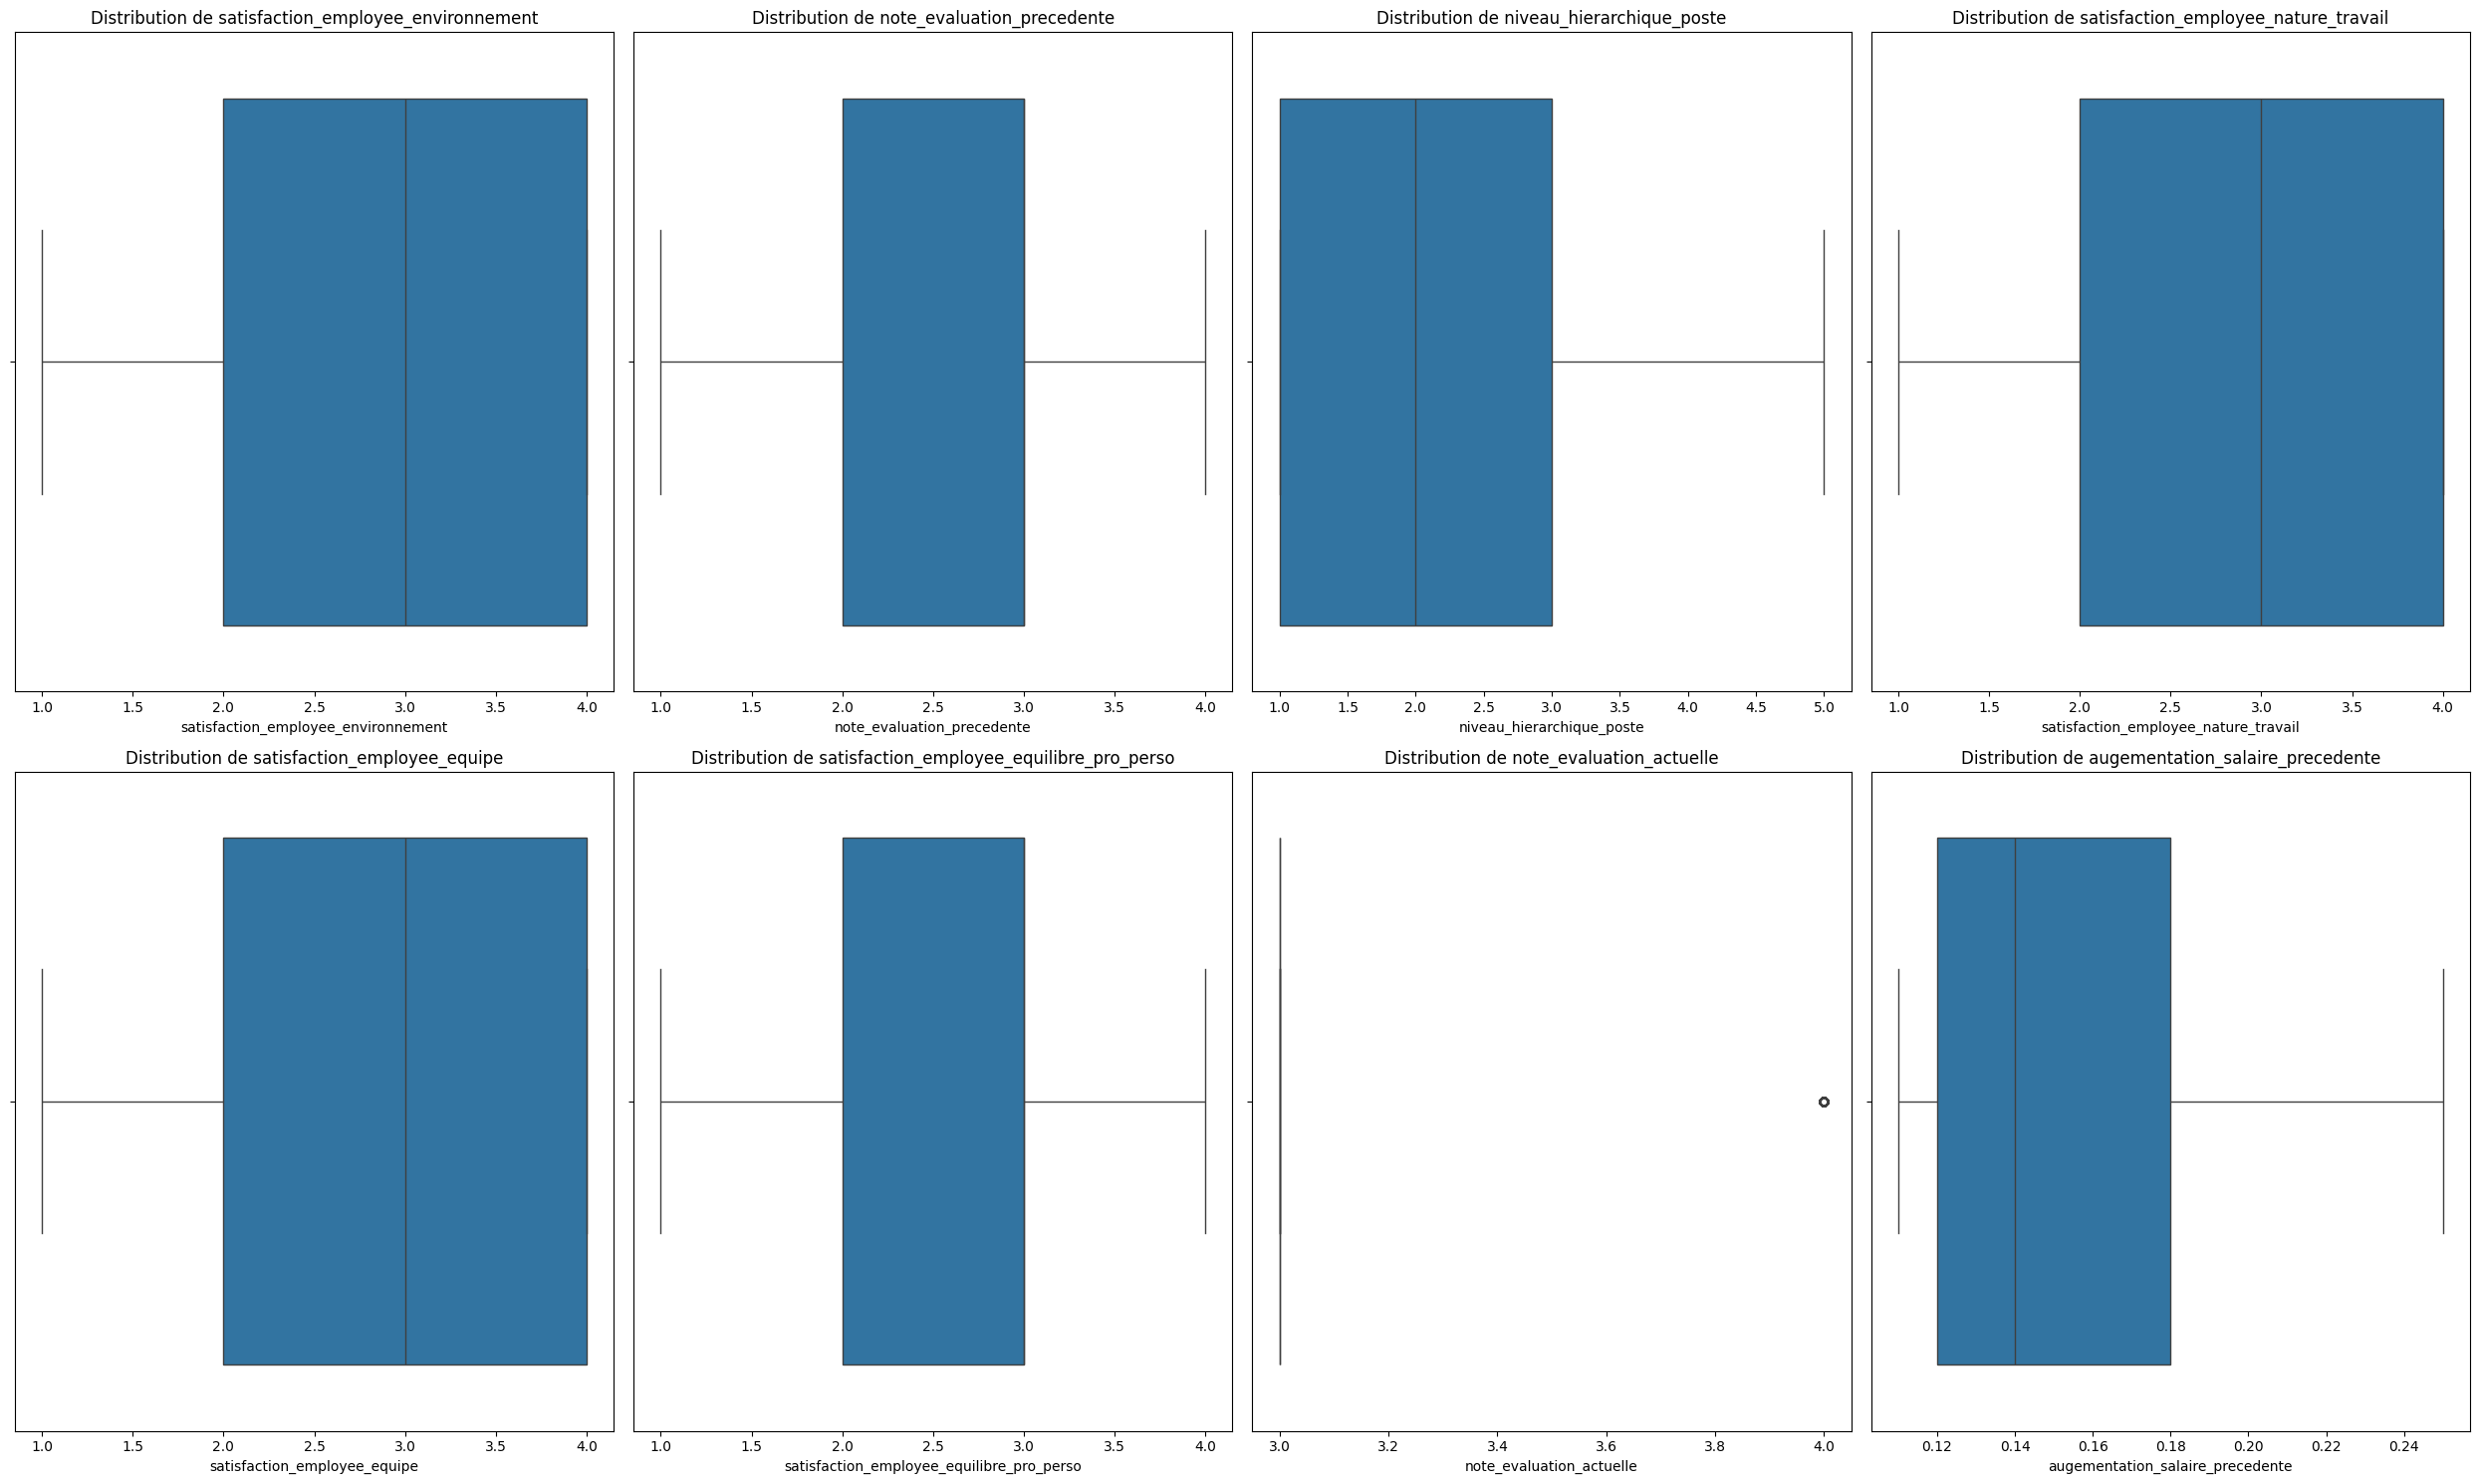

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.flatten()
for i, col in enumerate(df_eval.drop(cols_to_drop, axis=1).columns):
    sns.boxplot(x=df_eval[col], ax=axes[i])
    axes[i].set_title(f'Distribution de {col}')
plt.tight_layout()
plt.show()

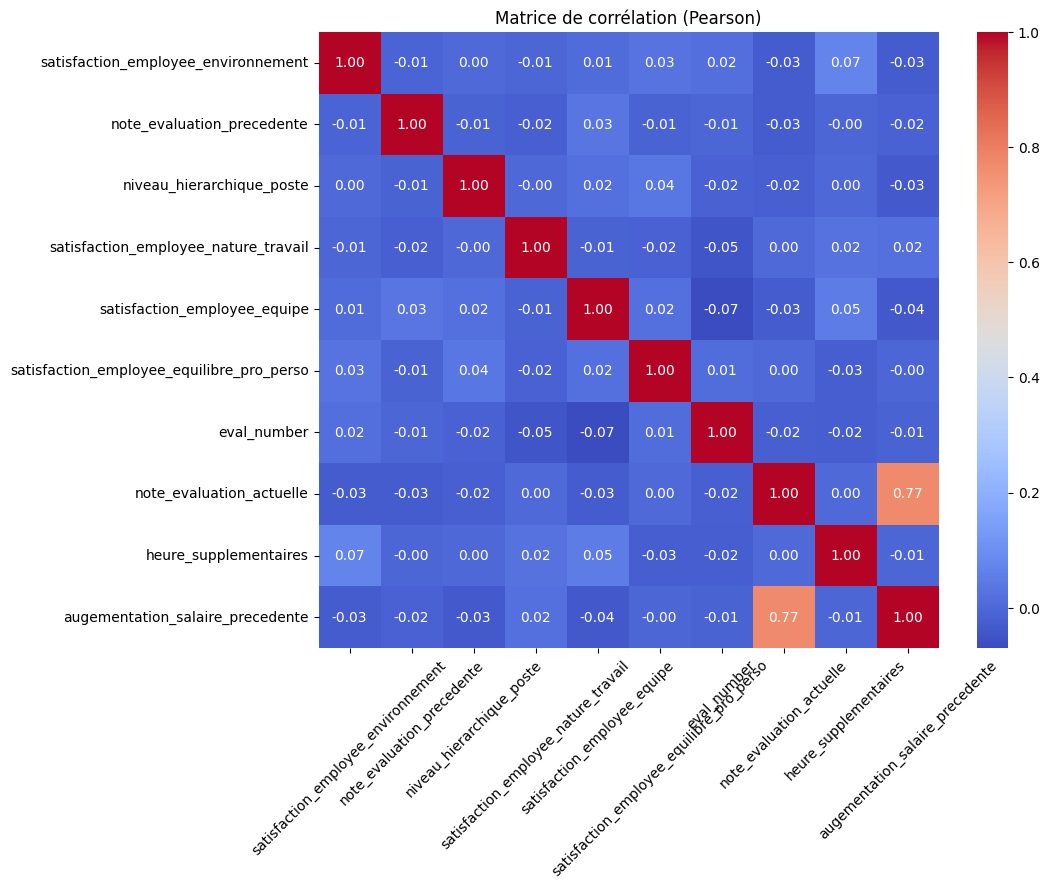

In [28]:
pearson_corr = df_eval.corr('pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation (Pearson)')
plt.xticks(rotation=45)
plt.show()

In [29]:
# Définir un seuil de corrélation
threshold = 0.7

# Trouver les paires de variables fortement corrélées
high_corr_pairs = []
for i in range(len(pearson_corr.columns)):
    for j in range(i):
        if abs(pearson_corr.iloc[i, j]) > threshold:
            high_corr_pairs.append((pearson_corr.columns[i], pearson_corr.columns[j], pearson_corr.iloc[i, j]))

# Afficher les paires fortement corrélées
print("Paires de variables fortement corrélées (seuil =", threshold, "):")
for pair in high_corr_pairs:
    print(f"Variables: {pair[0]} et {pair[1]}, Corrélation: {pair[2]:.2f}")

Paires de variables fortement corrélées (seuil = 0.7 ):
Variables: augementation_salaire_precedente et note_evaluation_actuelle, Corrélation: 0.77


Cette forte corrélation positive suggère que les employés qui ont eu une bonne note_evaluation_actuelle ont aussi tendance à recevoir une augementation_salaire_precedente plus élevée.

Les augmentations de salaire sont généralement liées aux performances. Plus un employé est bien noté, plus son augmentation est significative.

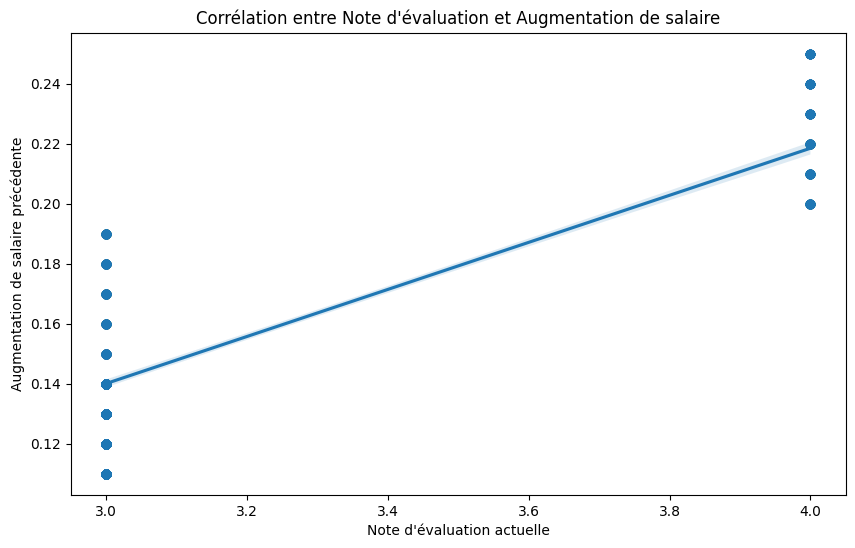

In [30]:
# Créer un nuage de points avec une ligne de régression pour visualiser la corrélation
plt.figure(figsize=(10, 6))
sns.regplot(x='note_evaluation_actuelle', y='augementation_salaire_precedente', data=df_eval)
plt.title('Corrélation entre Note d\'évaluation et Augmentation de salaire')
plt.xlabel('Note d\'évaluation actuelle')
plt.ylabel('Augmentation de salaire précédente')
plt.show()

In [31]:
df_eval['eval_number'].duplicated().sum()

np.int64(0)

## EDA - extrait_sondage.csv

Le fichier **extrait_sondage.csv** contient les réponses des employés du sondage annuel qui aide à l'entreprise à mettre en place des actions pour le bien-être des employés
 
- Contient 1470 lignes et 12 colonnes.
- Aucune valeurs manquantes
- Contient 4 colonnes catégrielles et 8 colonnes numériques

In [32]:
df_sondage = pd.read_csv('extrait_sondage.csv')
df_sondage.head()

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


In [33]:
df_sondage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   a_quitte_l_entreprise                1470 non-null   object
 1   nombre_participation_pee             1470 non-null   int64 
 2   nb_formations_suivies                1470 non-null   int64 
 3   nombre_employee_sous_responsabilite  1470 non-null   int64 
 4   code_sondage                         1470 non-null   int64 
 5   distance_domicile_travail            1470 non-null   int64 
 6   niveau_education                     1470 non-null   int64 
 7   domaine_etude                        1470 non-null   object
 8   ayant_enfants                        1470 non-null   object
 9   frequence_deplacement                1470 non-null   object
 10  annees_depuis_la_derniere_promotion  1470 non-null   int64 
 11  annes_sous_responsable_actuel        1470 n

In [34]:
# Colonnes catégorielles
cat_cols = df_sondage.select_dtypes(include=['object']).columns

print("Colonnes catégorielles :", cat_cols.tolist())

Colonnes catégorielles : ['a_quitte_l_entreprise', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement']


In [35]:
for col in cat_cols:
    print(f"Colonne '{col}' :")
    print(df_sondage[col].value_counts())
    print("\n")

Colonne 'a_quitte_l_entreprise' :
a_quitte_l_entreprise
Non    1233
Oui     237
Name: count, dtype: int64


Colonne 'domaine_etude' :
domaine_etude
Infra & Cloud              606
Transformation Digitale    464
Marketing                  159
Entrepreunariat            132
Autre                       82
Ressources Humaines         27
Name: count, dtype: int64


Colonne 'ayant_enfants' :
ayant_enfants
Y    1470
Name: count, dtype: int64


Colonne 'frequence_deplacement' :
frequence_deplacement
Occasionnel    1043
Frequent        277
Aucun           150
Name: count, dtype: int64




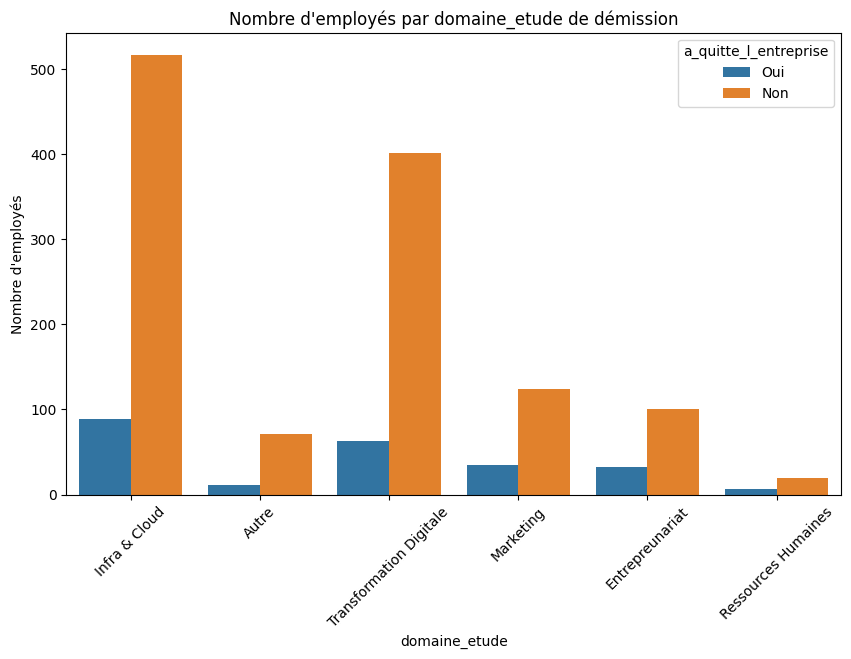

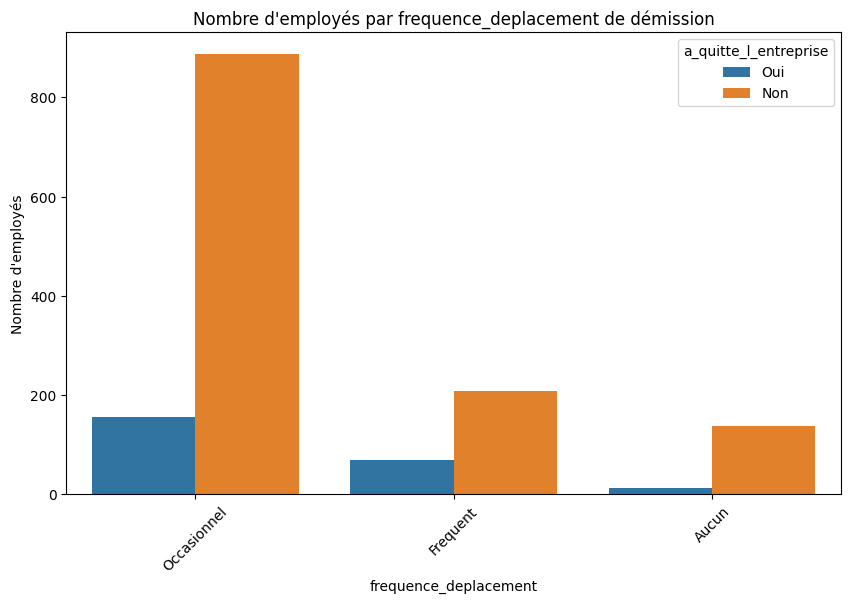

In [36]:
for col in cat_cols.drop(['a_quitte_l_entreprise', 'ayant_enfants']):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='a_quitte_l_entreprise', data=df_sondage)
    plt.title(f'Nombre d\'employés par {col} de démission')
    plt.xlabel(col)
    plt.ylabel('Nombre d\'employés')
    plt.xticks(rotation=45)
    plt.show()

a_quitte_l_entreprise,Non,Oui
domaine_etude,,
Autre,86.59,13.41
Entrepreunariat,75.76,24.24
Infra & Cloud,85.31,14.69
Marketing,77.99,22.01
Ressources Humaines,74.07,25.93
Transformation Digitale,86.42,13.58


<Figure size 1000x600 with 0 Axes>

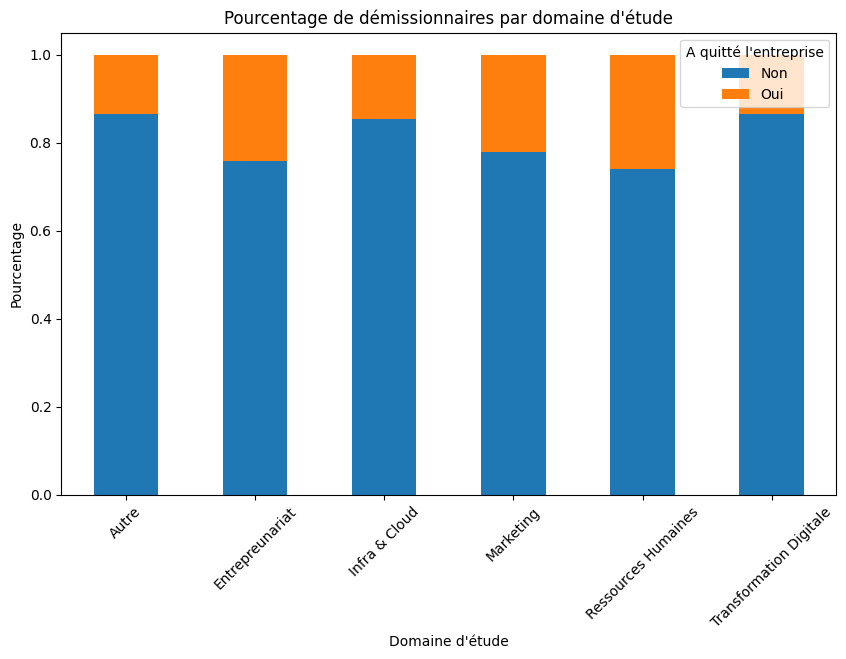

In [37]:
proportions_etude = df_sondage.groupby('domaine_etude')['a_quitte_l_entreprise'].value_counts(normalize=True).unstack()

display((proportions_etude*100).round(2))

plt.figure(figsize=(10, 6))
proportions_etude.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Pourcentage de démissionnaires par domaine d\'étude')
plt.xlabel('Domaine d\'étude')
plt.ylabel('Pourcentage')
plt.xticks(rotation=45)
plt.legend(title='A quitté l\'entreprise')
plt.show()

a_quitte_l_entreprise,Non,Oui
frequence_deplacement,,
Aucun,92.00,8.00
Frequent,75.09,24.91
Occasionnel,85.04,14.96


<Figure size 1000x600 with 0 Axes>

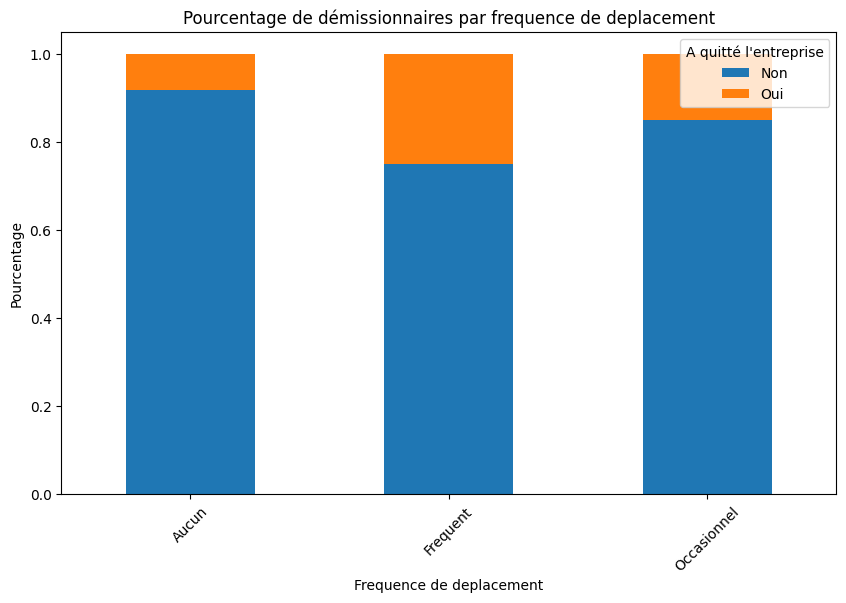

In [38]:
proportions_deplacement = df_sondage.groupby('frequence_deplacement')['a_quitte_l_entreprise'].value_counts(normalize=True).unstack()

display((proportions_deplacement*100).round(2))

plt.figure(figsize=(10, 6))
proportions_deplacement.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Pourcentage de démissionnaires par frequence de deplacement')
plt.xlabel('Frequence de deplacement')
plt.ylabel('Pourcentage')
plt.xticks(rotation=45)
plt.legend(title='A quitté l\'entreprise')
plt.show()

**Analyse des colonnes catégorielles**
- Colonne `a_quitte_l_entreprise` : Les employés qui ont démissionné sont minoritaires. Il faudra en tenir compte lors de la modélisation. Un modèle pourrait être tenté de prédire "Non" pour tout le monde, car c'est la réponse la plus fréquente.

- Colonne `domaine_etude` : On voit que les domaines "Infra & Cloud" et "Transformation Digitale" sont les plus représentés, ce qui est logique pour une entreprise de Consulting et Commercial

- Colonne `ayant_enfants` : cette colonne ne contienne qu'une seule valeur (Y), c'est une constante, et on peut l'éliminer du dataset final, car elle ne sert à rien.

- Colonne `frequence_deplacement` : La majorité des employés (Occasionnel) est une information pertinente. Il sera intéressant de voir si la fréquence des déplacements est plus élevée chez les démissionnaires.

- Les employés issus des domaines `Ressources Humaines` (25,93 %), `Entrepreneuriat` (24,24 %) et `Marketing` (22,01 %) ont les taux de démission les plus élevés. Cela est particulièrement intéressant pour les Ressources Humaines, car leur faible effectif rend ce taux de démission proportionnellement très important.

- Les domaines `Transformation Digitale` (13,58 %) et `Infra & Cloud` (14,69 %) ont les taux de démission les plus bas. Cela pourrait indiquer que ces départements offrent un environnement de travail plus stable ou que les compétences y sont plus demandées.

- Les employés qui se déplacent fréquement ont un taux de démission de 24,91%.

Conclusion :

1. **La fréquence de déplacement** : C'est le facteur le plus discriminant.
2. **Le domaine d'étude** : Les employés en RH, Entrepreneuriat et Marketing sont plus enclins à démissionner.

In [39]:
df_sondage.describe().T

,count,mean,std,min,25%,50%,75%,max
nombre_participation_pee,1470.0,0.793878,0.852077,0.0,0.00,1.0,1.00,3.0
nb_formations_suivies,1470.0,2.799320,1.289271,0.0,2.00,3.0,3.00,6.0
nombre_employee_sous_responsabilite,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
code_sondage,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
distance_domicile_travail,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
niveau_education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
annees_depuis_la_derniere_promotion,1470.0,2.187755,3.222430,0.0,0.00,1.0,3.00,15.0
annes_sous_responsable_actuel,1470.0,4.123129,3.568136,0.0,2.00,3.0,7.00,17.0


**Interprétation des varibales numériques**

- `nombre_participation_pee` : Nombre de participations à un Plan d'Épargne Entreprise. Les employés qui s'investissent dans ces programmes d'entreprise sont probablement plus engagés et fidèles. Je m'attendrais à ce que le nombre de participations soit plus élevé chez les employés qui ne sont pas partis. 50% des employés ont participé au moins une fois.

- `nb_formations_suivies` : La plupart des employés ont suivi entre 2 et 3 formations, ce qui est une bonne nouvelle pour l'entreprise. De manière similaire au PEE, suivre des formations est un signe d'investissement personnel. Un employé qui se forme pour son poste est sans doute moins susceptible de le quitter.

- `nombre_employee_sous_responsabilite` : Tous les indicateurs (min, 25%, 50%, 75%, max) sont à 1.0. Cela signifie que cette variable est une constante. Cette colonne n'apporte aucune information discriminante et ne sera pas utile pour ton modèle de Machine Learning.

- `code_sondage` : Comme id_employee, cette colonne est une clé d'identification, mais n'a aucun pouvoir prédictif sur la démission.

- `distance_domicile_travail` : Les employés avec une longue distance de trajet peuvent être plus enclins à démissionner. Je m'attendrais à voir une distance moyenne plus élevée pour le groupe des démissionnaires.

- `niveau_education` : Le niveau d'éducation pourrait être lié à la démission, car un niveau plus élevé pourrait correspondre à des employés qui ont plus d'opportunités de carrière. Il est important de visualiser cela pour voir si une tendance se dégage.

- `annees_depuis_la_derniere_promotion` : C'est une variable très importante. On peut supposer qu'un long délai depuis la dernière promotion est un facteur de démission. La moyenne (2.18) est plus de deux fois plus grande que la médiane (1.0). Cela montre une forte asymétrie vers la droite : beaucoup d'employés ont eu une promotion récemment, mais certains attendent depuis très longtemps (jusqu'à 15 ans, le maximum).

- `annes_sous_responsable_actuel` : La moyenne (4.12) est supérieure à la médiane (3.0), ce qui indique aussi une asymétrie. Le temps passé sous le même manager soit un facteur, que ce soit très court (signe d'un désaccord) ou très long (signe de stagnation).

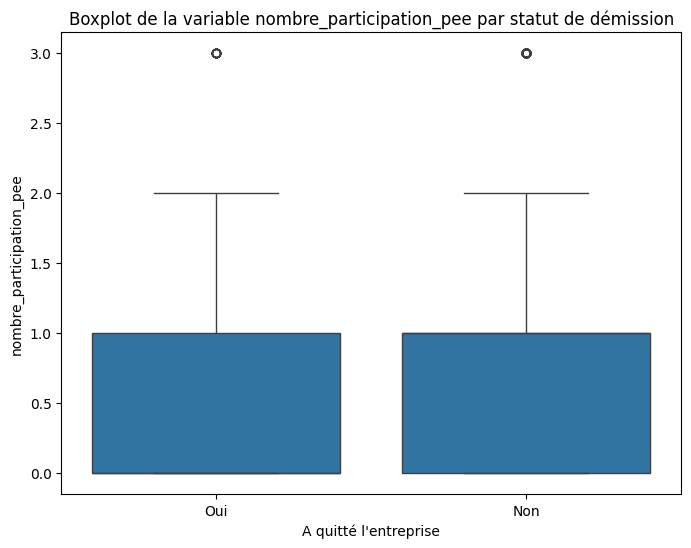

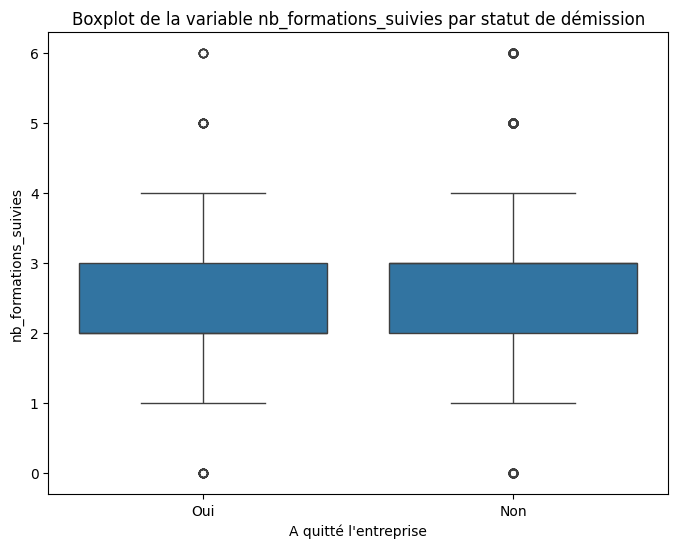

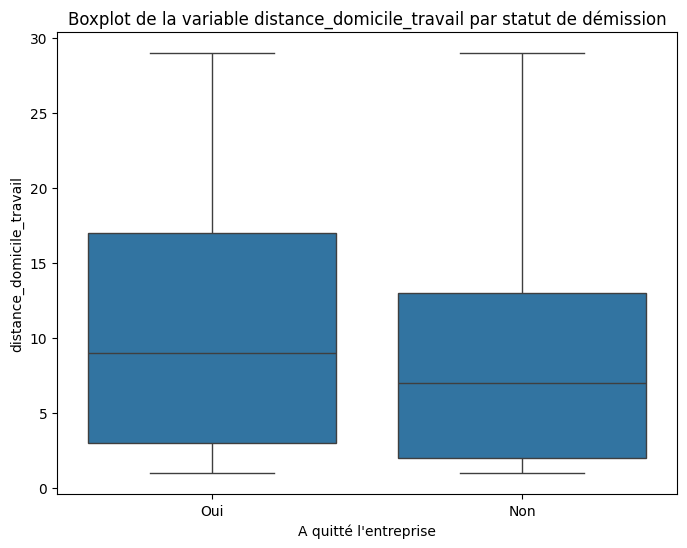

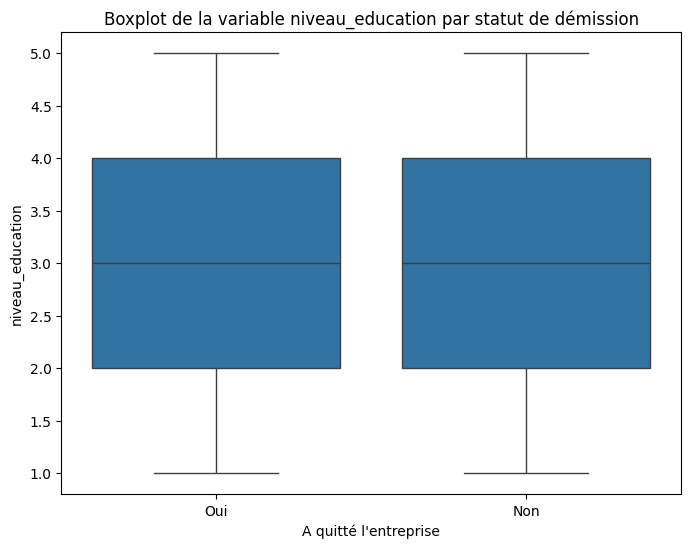

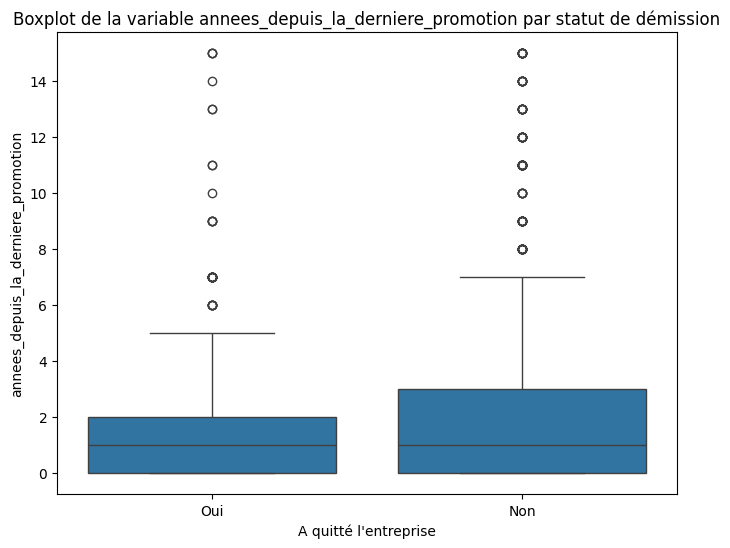

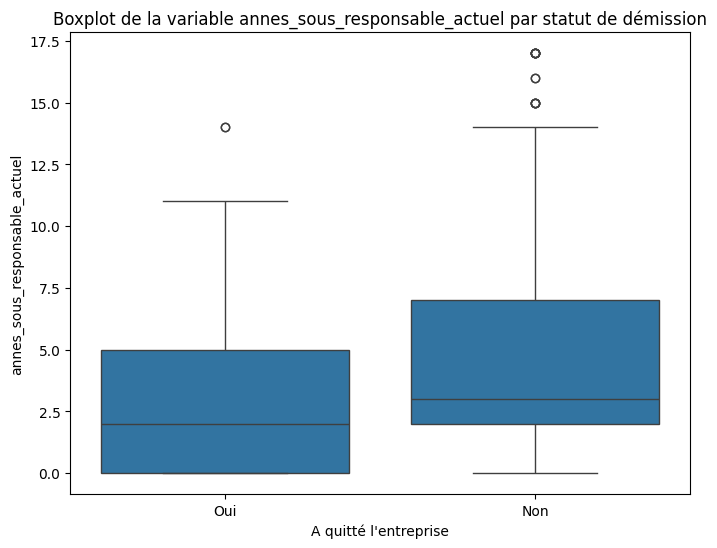

In [40]:
num_cols = df_sondage.select_dtypes(include=['number']).columns.drop(['code_sondage', 'nombre_employee_sous_responsabilite'])

for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='a_quitte_l_entreprise', y=col, data=df_sondage)
    plt.title(f'Boxplot de la variable {col} par statut de démission')
    plt.xlabel('A quitté l\'entreprise')
    plt.ylabel(col)
    plt.show()

In [41]:
df_songage_a_quitte = df_sondage[df_sondage['a_quitte_l_entreprise'] == 'Oui'].drop(['nombre_employee_sous_responsabilite','code_sondage'], axis=1)
df_songage_a_quitte.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
nombre_participation_pee,237.0,0.53,0.86,0.0,0.0,0.0,1.0,3.0
nb_formations_suivies,237.0,2.62,1.25,0.0,2.0,2.0,3.0,6.0
distance_domicile_travail,237.0,10.63,8.45,1.0,3.0,9.0,17.0,29.0
niveau_education,237.0,2.84,1.01,1.0,2.0,3.0,4.0,5.0
annees_depuis_la_derniere_promotion,237.0,1.95,3.15,0.0,0.0,1.0,2.0,15.0
annes_sous_responsable_actuel,237.0,2.85,3.14,0.0,0.0,2.0,5.0,14.0


In [42]:
df_sondage_reste = df_sondage[df_sondage['a_quitte_l_entreprise'] == 'Non'].drop(['nombre_employee_sous_responsabilite','code_sondage'], axis=1)
df_sondage_reste.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
nombre_participation_pee,1233.0,0.85,0.84,0.0,0.0,1.0,1.0,3.0
nb_formations_suivies,1233.0,2.83,1.29,0.0,2.0,3.0,3.0,6.0
distance_domicile_travail,1233.0,8.92,8.01,1.0,2.0,7.0,13.0,29.0
niveau_education,1233.0,2.93,1.03,1.0,2.0,3.0,4.0,5.0
annees_depuis_la_derniere_promotion,1233.0,2.23,3.23,0.0,0.0,1.0,3.0,15.0
annes_sous_responsable_actuel,1233.0,4.37,3.59,0.0,2.0,3.0,7.0,17.0


- `nombre_participation_pee` & `a_quitte_l_entreprise` : Les employés qui ne démissionnent pas ont une plus grande tendance à participer au Plan d'Épargne Entreprise que ceux qui partent. La participation au PEE est un indicateur de l'engagement des employés à long terme.

- `nb_formations_suivies` & `a_quitte_l_entreprise` : La médiane des employés qui sont restés (3.0) est supérieure à celle des démissionnaires (2.0). C'est un indicateur, même s'il est subtil, que la formation pourrait être un facteur de rétention. Les employés qui ont bénéficié de plus de formations ont une plus grande tendance à rester. Cette conclusion est très différente de celle que j'ai formulée précédemment.

- `distance_domicile_travail` & `a_quitte_l_entreprise` : Il y a une corrélation forte entre la distance domicile-travail et la démission. Les employés qui ont un long trajet pour se rendre au travail sont plus susceptibles de quitter l'entreprise.

- `niveau_education` & `a_quitte_l_entreprise` : Les distributions du niveau d'éducation pour les deux groupes sont pratiquement identiques. La moyenne et la médiane sont très proches, et les quartiles sont les mêmes. On peut donc conclure que le niveau d'éducation ne semble pas être un facteur prédictif de la démission.

- `annees_depuis_la_derniere_promotion` & `a_quitte_l_entreprise` : La similarité des médianes (1 an pour les deux groupes) est trompeuse. En revanche, l'analyse des autres statistiques révèle une nuance importante : La moyenne et le 75e percentile sont plus élevés pour les employés qui sont restés dans l'entreprise. Cela suggère que, bien que la médiane soit la même, les non-démissionnaires ont en moyenne attendu plus longtemps pour une promotion que leurs homologues qui sont partis.

- `annes_sous_responsable_actuel` & `a_quitte_l_entreprise` : Il existe une forte corrélation entre la durée passée sous la responsabilité du manager et le risque de démission. Les employés qui démissionnent ont passé en moyenne significativement moins de temps avec leur manager actuel que ceux qui restent. La différence de médiane (2 ans vs 3 ans) et la différence de moyenne (2.85 ans vs 4.37 ans) sont des indicateurs très solides.

In [43]:
df_sondage['a_quitte_l_entreprise_num'] = df_sondage['a_quitte_l_entreprise'].apply(lambda x: 1 if x == 'Oui' else 0)

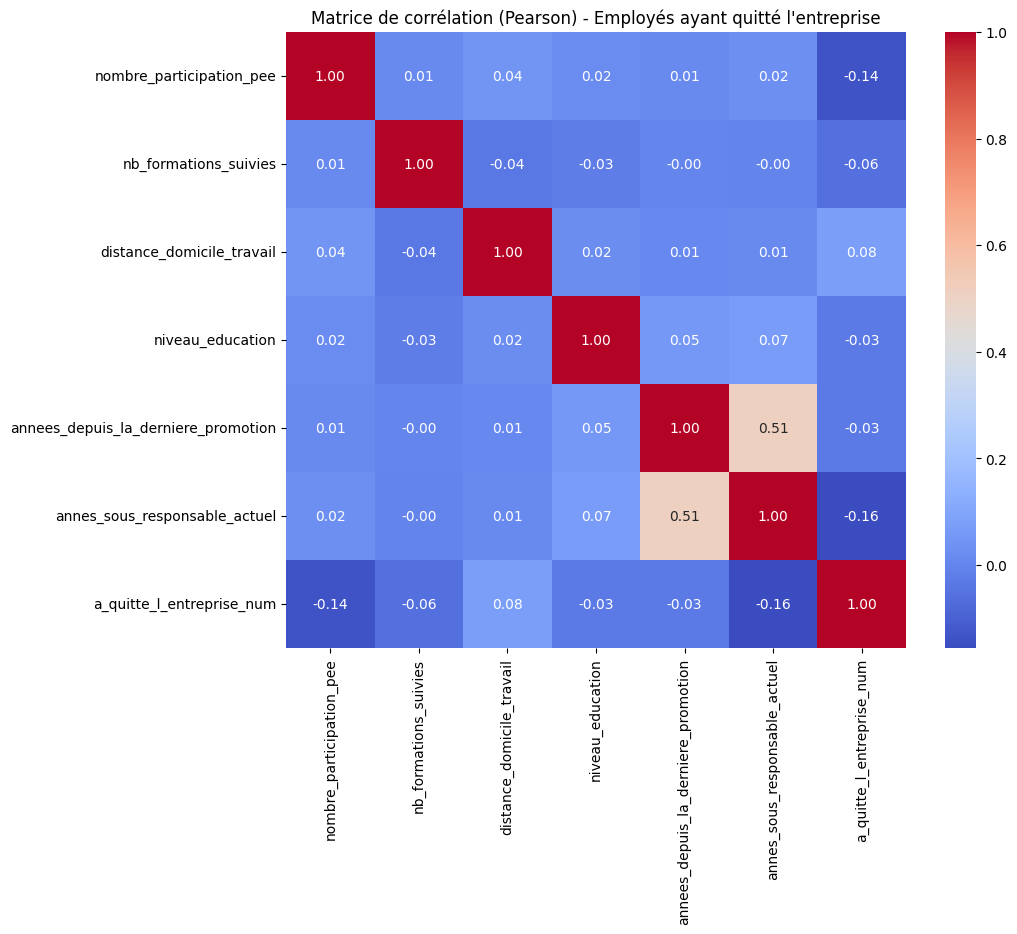

In [44]:
num_cols = df_sondage.select_dtypes(include=['number']).columns.drop(['code_sondage', 'nombre_employee_sous_responsabilite'])

# Matrice de corrélation pour les employés ayant quitté l'entreprise
pearson_corr_sondage = df_sondage[num_cols].corr('pearson')

# Affichage de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr_sondage, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation (Pearson) - Employés ayant quitté l\'entreprise')
plt.show()

In [45]:
# Afficher les corrélations avec la variable cible
print("\nCorrélation avec la variable 'a_quitte_l_entreprise' :")
print(pearson_corr_sondage['a_quitte_l_entreprise_num'].sort_values(ascending=False))


Corrélation avec la variable 'a_quitte_l_entreprise' :
a_quitte_l_entreprise_num              1.000000
distance_domicile_travail              0.077924
niveau_education                      -0.031373
annees_depuis_la_derniere_promotion   -0.033019
nb_formations_suivies                 -0.059478
nombre_participation_pee              -0.137145
annes_sous_responsable_actuel         -0.156199
Name: a_quitte_l_entreprise_num, dtype: float64


In [46]:
df_sondage['code_sondage'].duplicated().sum()

np.int64(0)

# 3. Jointure et EDA sur le fichier central

Les `id_employee`, `code_sondage` et `eval_number` vont me permettre de réaliser les jointures.

In [47]:
# Création des ensembles à partir des colonnes clés
set_sirh = set(df_sirh['id_employee'])
set_eval = set(df_eval['eval_number'])
set_sondage = set(df_sondage['code_sondage'])

# Vérification des tailles des ensembles
print("Taille de l'ensemble des IDs dans df_sirh :", len(set_sirh))
print("Taille de l'ensemble des IDs dans df_eval :", len(set_eval))
print("Taille de l'ensemble des IDs dans df_sondage :", len(set_sondage))

# Vérification si les ensembles sont identiques
if set_sirh == set_eval and set_eval == set_sondage:
    print("\n Les ensembles d'identifiants sont identiques dans les trois DataFrames.")
else:
    print("\n Les ensembles d'identifiants ne sont PAS identiques.")

    # Trouver les IDs manquants ou en trop pour un diagnostic plus précis
    print("\nDifférences :")
    print(f"IDs dans df_sirh mais pas dans df_eval : {set_sirh.difference(set_eval)}")
    print(f"IDs dans df_eval mais pas dans df_sirh : {set_eval.difference(set_sirh)}")
    print(f"IDs dans df_sondage mais pas dans les autres : {set_sondage.difference(set_sirh.union(set_eval))}")

Taille de l'ensemble des IDs dans df_sirh : 1470
Taille de l'ensemble des IDs dans df_eval : 1470
Taille de l'ensemble des IDs dans df_sondage : 1470

 Les ensembles d'identifiants sont identiques dans les trois DataFrames.


Les jointures (ou merge) sont les outils qui vous permettent de les fusionner en un seul tableau.

Les différents types de jointures :
1. **Inner Join (Jointure Interne)** : est la jointure la plus stricte. Elle ne conserve que les lignes qui ont une correspondance dans les deux DataFrames.
    - Analogie : Vous cherchez les étudiants qui sont à la fois sur la liste des inscrits au cours A et sur la liste du cours B. Seuls les étudiants qui sont sur les deux listes sont gardés. **(A ∩ B)**
2. **Left Join (Jointure Gauche)** : conserve toutes les lignes du DataFrame de gauche, et les lignes correspondantes du DataFrame de droite. Si une ligne du DataFrame de gauche n'a pas de correspondance dans celui de droite, les valeurs des colonnes du DataFrame de droite seront remplies de NaN (valeur manquante).
    - Analogie : Vous gardez tous les étudiants inscrits au cours A, et vous leur ajoutez les informations du cours B s'ils y sont aussi inscrits. **[(A ∪ B) - (B - A)]**
3. **Right Join (Jointure Droite)** : l'inverse de Left Join. Elle conserve toutes les lignes du DataFrame de droite, et les lignes correspondantes du DataFrame de gauche.
    - Analogie : Vous gardez tous les étudiants inscrits au cours B, et vous leur ajoutez les informations du cours A s'ils y sont aussi inscrits. **[(A ∪ B) - (A - B)]**
4. **Outer Join (Jointure Complète)** : est la jointure la plus permissive. Elle conserve toutes les lignes des deux DataFrames. Si une ligne n'a pas de correspondance dans l'autre DataFrame, les valeurs des colonnes correspondantes sont remplies de NaN.
    - Analogie : Vous gardez la liste complète de tous les étudiants qui sont inscrits soit au cours A, soit au cours B, soit aux deux. **(A ∪ B)**

## Jointure

Dans notre projet nous utiliserons **`Inner Join`** car :
- J'ai vérifé que les identifiants sont identiques dans les trois datasets.
- L'inner join permettra de s'assurer que chaque ligne de votre DataFrame final correspond bien à un employé qui est présent dans le SIRH, a passé une évaluation et a répondu au sondage. Cela garantit que le dataset final est complet et cohérent.

In [48]:
# 1. Fusionner df_sirh et df_eval sur les colonnes 'id_employee' et 'eval_number'
df_step_1 = pd.merge(df_sirh, df_eval, left_on='id_employee', right_on='eval_number', how='inner')

# Supprimer la colonne redondante 'eval_number'
df_step_1.drop('eval_number', axis=1, inplace=True)

# 2. Fusionner le résultat avec df_sondage sur les colonnes 'id_employee' et 'code_sondage'
df_final = pd.merge(df_step_1, df_sondage, left_on='id_employee', right_on='code_sondage', how='inner')

# Supprimer la colonne redondante 'code_sondage'
df_final.drop('code_sondage', axis=1, inplace=True)

Après la jointure nous avons un nouveau dataframe de 33 colonnes et 1470 lignes :
- 8 colonnes catégorielles : ['genre', 'statut_marital', 'departement', 'poste', 'a_quitte_l_entreprise', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement']
- 24 colonnes numériques

In [49]:
df_final.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,a_quitte_l_entreprise_num
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,2,3,2,4,1,1,3,1,0.11,Oui,0,0,1,1,2,Infra & Cloud,Y,Occasionnel,0,5,1
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,3,2,2,2,4,3,4,0,0.23,Non,1,3,1,8,1,Infra & Cloud,Y,Frequent,1,7,0
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,4,2,1,3,2,3,3,1,0.15,Oui,0,3,1,2,2,Autre,Y,Occasionnel,0,0,1
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,4,3,1,3,3,3,3,1,0.11,Non,0,3,1,3,4,Infra & Cloud,Y,Frequent,3,0,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2,1,3,1,2,4,3,3,0,0.12,Non,1,3,1,2,1,Transformation Digitale,Y,Occasionnel,2,2,0


In [50]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id_employee                                1470 non-null   int64  
 1   age                                        1470 non-null   int64  
 2   genre                                      1470 non-null   object 
 3   revenu_mensuel                             1470 non-null   int64  
 4   statut_marital                             1470 non-null   object 
 5   departement                                1470 non-null   object 
 6   poste                                      1470 non-null   object 
 7   nombre_experiences_precedentes             1470 non-null   int64  
 8   nombre_heures_travailless                  1470 non-null   int64  
 9   annee_experience_totale                    1470 non-null   int64  
 10  annees_dans_l_entreprise

In [51]:
# Vérification des doublons dans la colonne 'id_employee'
df_final["id_employee"].duplicated().sum()

np.int64(0)

### Analyse colonnes numériques

In [52]:
# Statistiques descriptives des colonnes numériques
num_cols = df_final.select_dtypes(include=['number']).columns.drop('id_employee')
df_final[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,1470.0,36.923810,9.135373,18.00,30.00,36.00,43.00,60.00
revenu_mensuel,1470.0,6502.931293,4707.956783,1009.00,2911.00,4919.00,8379.00,19999.00
nombre_experiences_precedentes,1470.0,2.693197,2.498009,0.00,1.00,2.00,4.00,9.00
nombre_heures_travailless,1470.0,80.000000,0.000000,80.00,80.00,80.00,80.00,80.00
annee_experience_totale,1470.0,11.279592,7.780782,0.00,6.00,10.00,15.00,40.00
annees_dans_l_entreprise,1470.0,7.008163,6.126525,0.00,3.00,5.00,9.00,40.00
annees_dans_le_poste_actuel,1470.0,4.229252,3.623137,0.00,2.00,3.00,7.00,18.00
satisfaction_employee_environnement,1470.0,2.721769,1.093082,1.00,2.00,3.00,4.00,4.00
note_evaluation_precedente,1470.0,2.729932,0.711561,1.00,2.00,3.00,3.00,4.00
niveau_hierarchique_poste,1470.0,2.063946,1.106940,1.00,1.00,2.00,3.00,5.00


In [53]:
categorial_cols = df_final.select_dtypes(include=['object']).columns
for col in categorial_cols:
    print(f"Colonne '{col}' :")
    print(df_final[col].value_counts())
    print("\n")

Colonne 'genre' :
genre
M    882
F    588
Name: count, dtype: int64


Colonne 'statut_marital' :
statut_marital
Marié(e)       673
Célibataire    470
Divorcé(e)     327
Name: count, dtype: int64


Colonne 'departement' :
departement
Consulting             961
Commercial             446
Ressources Humaines     63
Name: count, dtype: int64


Colonne 'poste' :
poste
Cadre Commercial           326
Assistant de Direction     292
Consultant                 259
Tech Lead                  145
Manager                    131
Senior Manager             102
Représentant Commercial     83
Directeur Technique         80
Ressources Humaines         52
Name: count, dtype: int64


Colonne 'a_quitte_l_entreprise' :
a_quitte_l_entreprise
Non    1233
Oui     237
Name: count, dtype: int64


Colonne 'domaine_etude' :
domaine_etude
Infra & Cloud              606
Transformation Digitale    464
Marketing                  159
Entrepreunariat            132
Autre                       82
Ressources Humaines     

- Colonne `id_employee` : les statistiques pas pertinent
- Colonne `age` : range (18 ; 60) ans, moyenne proche de la médiane (36,92 VS 36) -> quasi-symétrie
- Colonne `revenu_mensuel` : range (1009 ; 19999), moyenne plus élevé que la médiane (6502 VS 4919) -> asymétrie
- Colonne `nombre_experiences_precedentes` : range (0 ; 9), moyenne et médiane prochent -> quasi-symétrie. Du débutant au Senior
- Colonne `annee_experience_totale` : range (0 ; 40), moyenne proche de la médiane -> quasi-symétrie. Du débutant au Senior
- Colonne `annees_dans_l_entreprise` : range (0 ; 40), asymétrie, du nouveau au senior
- Colonne `annees_dans_le_poste_actuel` : range (0 ; 18), asymétrie, de débutant à l'expert
- Colonne `genre` : il y a plus d'homme (60%) que de femme (40%)
- Colonne `statut_marital` : 45,78% des employés sont mariés, les autres sont soit célibataires (31,97%), soit divorcés (22,25%)
- Colonne `departement` : Conslting (65,37%), Commercial (30,35) et RH (4,28%)
- Colonne `poste` : 9 postes : Cadre Commercial (22,18%), Assistant de Direction (19,86%), Consultant (17,62%), Tech Lead (9,86%), Manager (8,91%), Senior Manager (6,94%), Représentant Commercial (5,65%), Directeur Technique (5,44%) et Ressources Humaines (3,54%)
- `satisfaction_employee_environnement` & `satisfaction_employee_nature_travail` :
    - Les moyennes sont similaires, environ 2.72. Cela nous dit que la satisfaction générale des employés pour leur environnement et la nature de leur travail est plutôt "neutre" à "satisfaite" sur une échelle qui semble aller de 1 à 4

    - L'écart-type est d'environ 1.09 et 1.10. C'est relativement élevé comparé à la moyenne, ce qui suggère qu'il y a une bonne diversité de réponses. Les employés ne sont pas tous d'accord, certains sont très insatisfaits et d'autres très satisfaits.

    - La médiane est de 3.00, ce qui est légèrement supérieur à la moyenne. Cela peut indiquer que les données sont légèrement asymétriques, tirant vers les valeurs plus élevées (satisfaction). Cela signifie que la moitié des employés ont donné une note de 3 ou plus.

- `note_evaluation_precedente` & `note_evaluation_actuelle` : 
    - note_evaluation_precedente : La moyenne est de 2.73 et l'écart-type de 0.71. C'est une plus faible dispersion que les variables de satisfaction. La plupart des notes précédentes sont regroupées entre 2.00 et 3.00 (quartiles). La médiane est 3.00.

    - note_evaluation_actuelle : La moyenne est de 3.15, et l'écart-type est de 0.36, ce qui est très faible ! De plus, la note minimale est de 3.00 et le 75ème percentile est aussi de 3.00.

    - Interprétation clé : La plupart des employés ont reçu une note de 3.00 lors de leur évaluation actuelle. La distribution des notes est très concentrée, presque toutes les notes sont à 3.00. Il n'y a pas beaucoup de notes à 4.00 (seulement 226 (15,37%)), et aucune note en dessous de 3.00. Cela pourrait indiquer un biais, par exemple, que le manager n'ose pas donner de mauvaises notes ou qu'il y a une politique qui ne permet pas les notes en dessous d'un certain seuil.

- `niveau_hierarchique_poste` :
    - La moyenne est de 2.06, ce qui est légèrement supérieur à 2. Si l'échelle va de 1 à 5, cela indique que la majorité des employés se trouvent dans les niveaux hiérarchiques les plus bas.
    
    - La médiande de 2.00 confirme que 50% des employés ont un niveau hiérarchique de 2 ou mois.

- `satisfaction_employee_equipe` :
    - La moyenne de 2.71 est très similaire aux autres variables de satisfaction.
    
    - L'écart-type est de 1.08, ce qui montre une bonne dispersion des réponses. Il y a des employés très satisfaits de leur équipe et d'autres qui ne le sont pas du tout.
    
    - La médiane est de 3.00, indique une légère asymétrie vers les valeurs plus élevées.

- `satisfaction_employee_equilibre_pro_perso` :
    - La moyenne la plus élevée, 2.76, cela suggère que c'est le domaine où les employés se sentent globalement le plus satisfaits.
    
    - L'écart-type est de 0.70. C'est le plus faible des écarts-types pour les variables de satisfaction, ce qui indique que les opinions sont plus homogènes sur ce sujet. Les employés ont une opinion assez cohérente sur l'équilibre vie pro/perso.
    
- `augementation_salaire_precedente` : La moyenne est de 0.152, soit environ 15.2%. L'écart-type est très faible, 0.036. Cela signifie que les augmentations de salaire sont très regroupées autour de la moyenne. Il n'y a pas d'énormes variations d'une augmentation à l'autre. L'essentiel des augmentations de salaire se situe entre 12% et 18% (l'écart interquartile).

- `heure_supplementaires` & `eval_number` : l'application des statistiques descriptives n'a aucune sens sur ces variables.

- `nombre_participation_pee` : Nombre de participations à un Plan d'Épargne Entreprise. Les employés qui s'investissent dans ces programmes d'entreprise sont probablement plus engagés et fidèles. Je m'attendrais à ce que le nombre de participations soit plus élevé chez les employés qui ne sont pas partis. 50% des employés ont participé au moins une fois.

- `nb_formations_suivies` : La plupart des employés ont suivi entre 2 et 3 formations, ce qui est une bonne nouvelle pour l'entreprise. De manière similaire au PEE, suivre des formations est un signe d'investissement personnel. Un employé qui se forme pour son poste est sans doute moins susceptible de le quitter.

- `code_sondage` : Comme id_employee, cette colonne est une clé d'identification, mais n'a aucun pouvoir prédictif sur la démission.

- `distance_domicile_travail` : Les employés avec une longue distance de trajet peuvent être plus enclins à démissionner. Je m'attendrais à voir une distance moyenne plus élevée pour le groupe des démissionnaires.

- `niveau_education` : Le niveau d'éducation pourrait être lié à la démission, car un niveau plus élevé pourrait correspondre à des employés qui ont plus d'opportunités de carrière. Il est important de visualiser cela pour voir si une tendance se dégage.

- `annees_depuis_la_derniere_promotion` : C'est une variable très importante. On peut supposer qu'un long délai depuis la dernière promotion est un facteur de démission. La moyenne (2.18) est plus de deux fois plus grande que la médiane (1.0). Cela montre une forte asymétrie vers la droite : beaucoup d'employés ont eu une promotion récemment, mais certains attendent depuis très longtemps (jusqu'à 15 ans, le maximum).

- `annes_sous_responsable_actuel` : La moyenne (4.12) est supérieure à la médiane (3.0), ce qui indique aussi une asymétrie. Le temps passé sous le même manager soit un facteur, que ce soit très court (signe d'un désaccord) ou très long (signe de stagnation).

- Colonne `a_quitte_l_entreprise` : Les employés qui ont démissionné sont minoritaires. Il faudra en tenir compte lors de la modélisation. Un modèle pourrait être tenté de prédire "Non" pour tout le monde, car c'est la réponse la plus fréquente.

- Colonne `domaine_etude` : On voit que les domaines "Infra & Cloud" et "Transformation Digitale" sont les plus représentés, ce qui est logique pour une entreprise de Consulting et Commercial

- Colonne `ayant_enfants` : cette colonne ne contienne qu'une seule valeur (Y), c'est une constante, et on peut l'éliminer du dataset final, car elle ne sert à rien.

- Colonne `frequence_deplacement` : La majorité des employés (Occasionnel) est une information pertinente. Il sera intéressant de voir si la fréquence des déplacements est plus élevée chez les démissionnaires.

- Les employés issus des domaines `Ressources Humaines` (25,93 %), `Entrepreneuriat` (24,24 %) et `Marketing` (22,01 %) ont les taux de démission les plus élevés. Cela est particulièrement intéressant pour les Ressources Humaines, car leur faible effectif rend ce taux de démission proportionnellement très important.

- Les domaines `Transformation Digitale` (13,58 %) et `Infra & Cloud` (14,69 %) ont les taux de démission les plus bas. Cela pourrait indiquer que ces départements offrent un environnement de travail plus stable ou que les compétences y sont plus demandées.

- Les employés qui se déplacent fréquement ont un taux de démission de 24,91%.

- Colonne `nombre_heures_travailless` : tout le monde travail 80 heures par semaines. C'est une constate
- Colonne `nombre_employee_sous_responsabilite` est une constante, n'approte rien dans la prédiction / classification

### Analyse bivarié : colonnes numériques et 'a_quitte_l_entreprise'

Nous cherchons a prédire si un employé est susceptible de quitter son emploi ou pas, ainsi notre target sera **`a_quitte_l_entreprise_num`**

Ici je vais comparer mes features avec `a_quitte_l_entreprise_num`

In [54]:
col_to_drop = ['nombre_heures_travailless', 'nombre_employee_sous_responsabilite']

df = df_final.drop(col_to_drop, axis=1)

In [55]:
# Séparation des colonnes numériques et catégorielles
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("Colonnes numériques :", numerical_cols.tolist())
print("Colonnes catégorielles :", categorical_cols.tolist())

Colonnes numériques : ['id_employee', 'age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'distance_domicile_travail', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel', 'a_quitte_l_entreprise_num']
Colonnes catégorielles : ['genre', 'statut_marital', 'departement', 'poste', 'a_quitte_l_entreprise', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement']


In [56]:
features_num_to_analyse = numerical_cols.drop('id_employee')

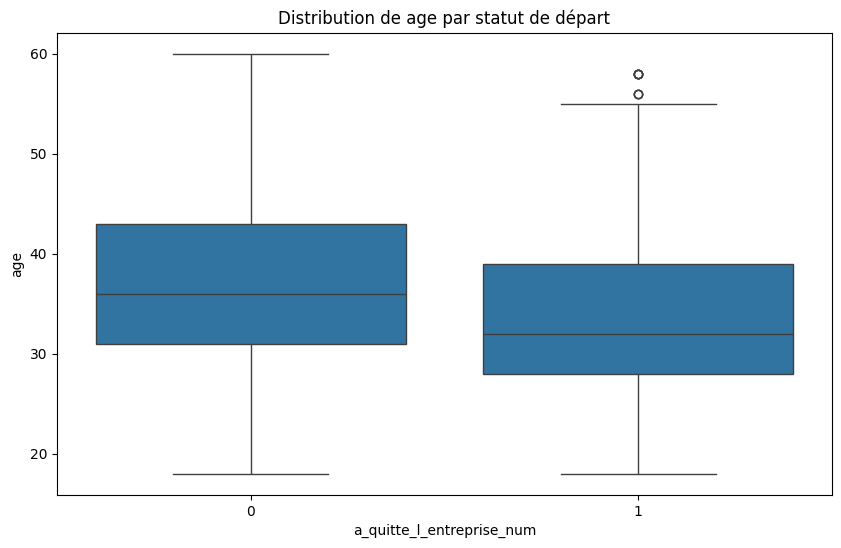

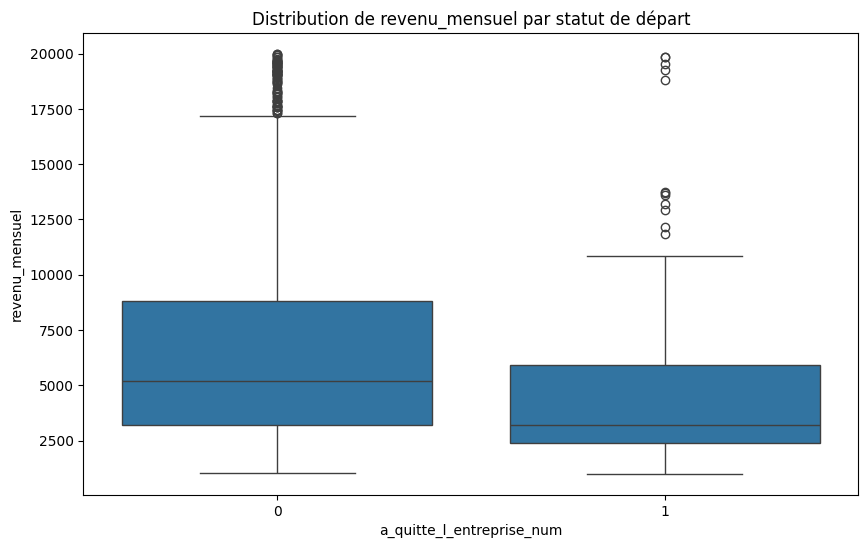

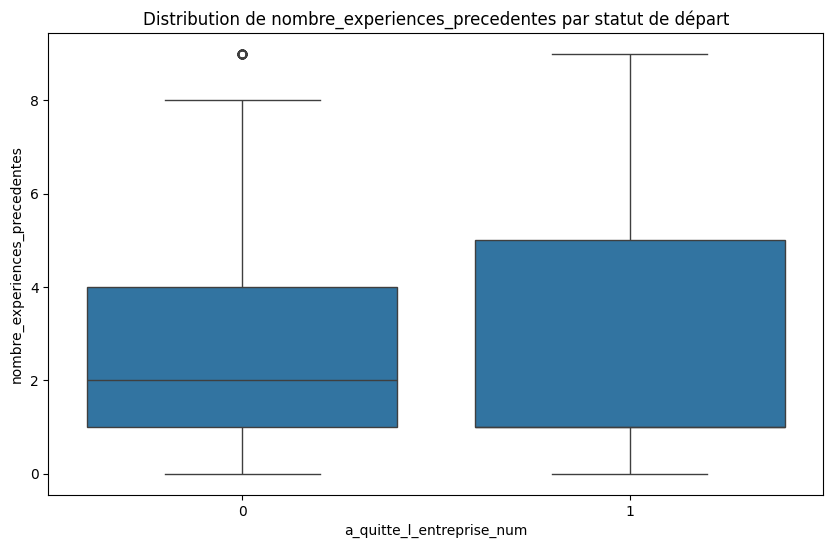

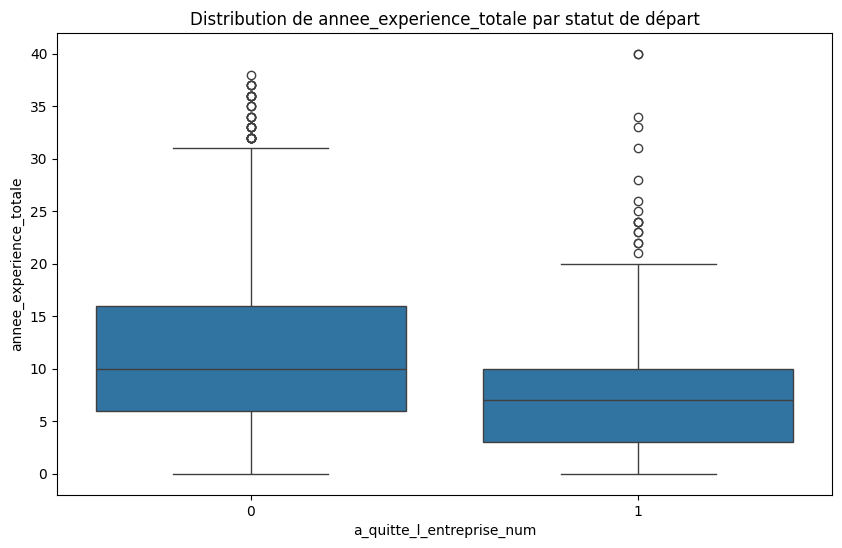

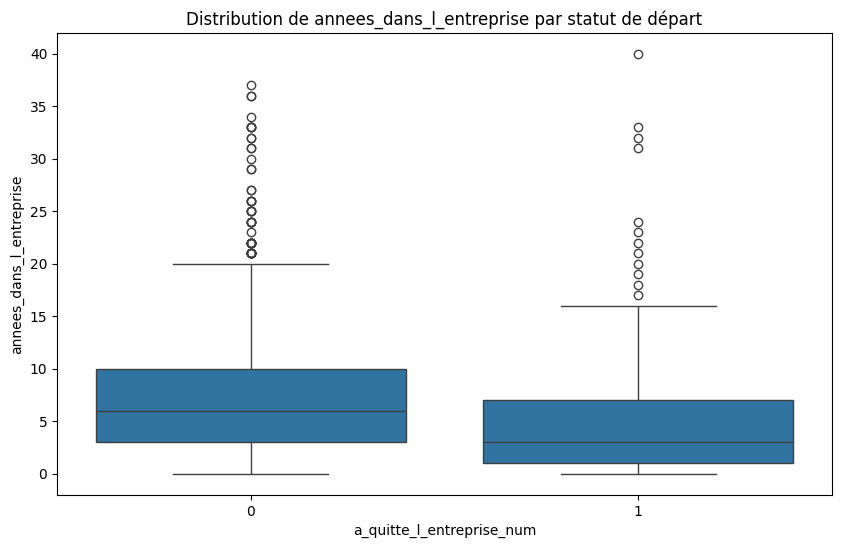

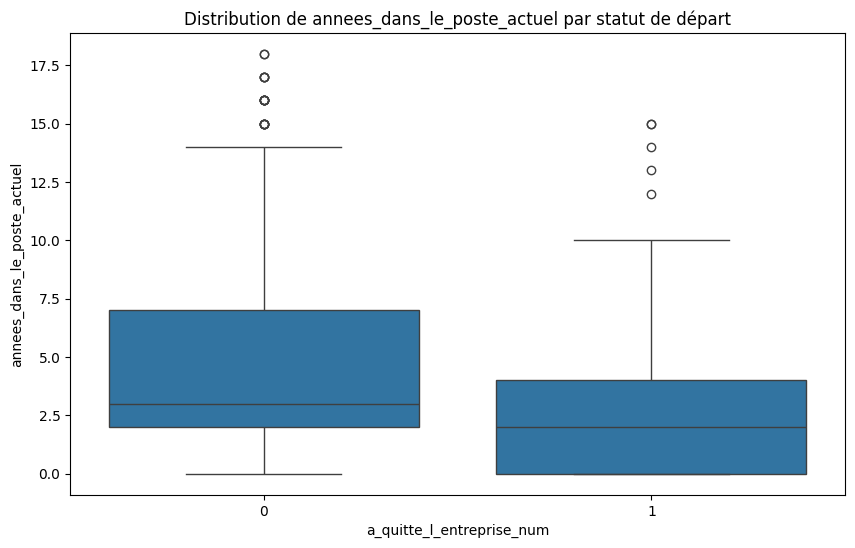

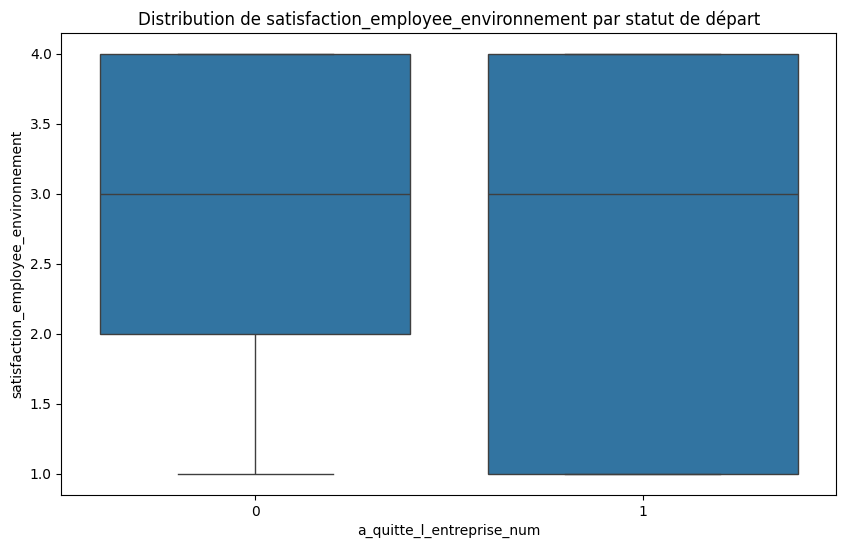

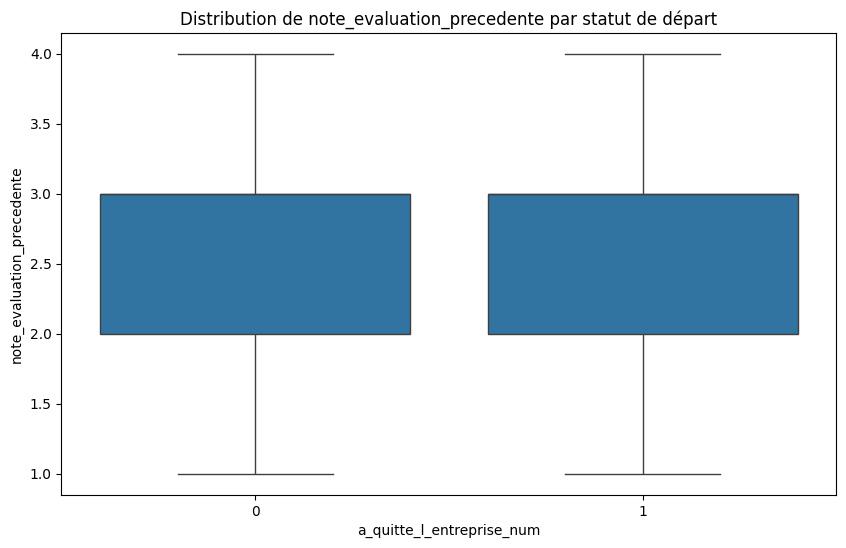

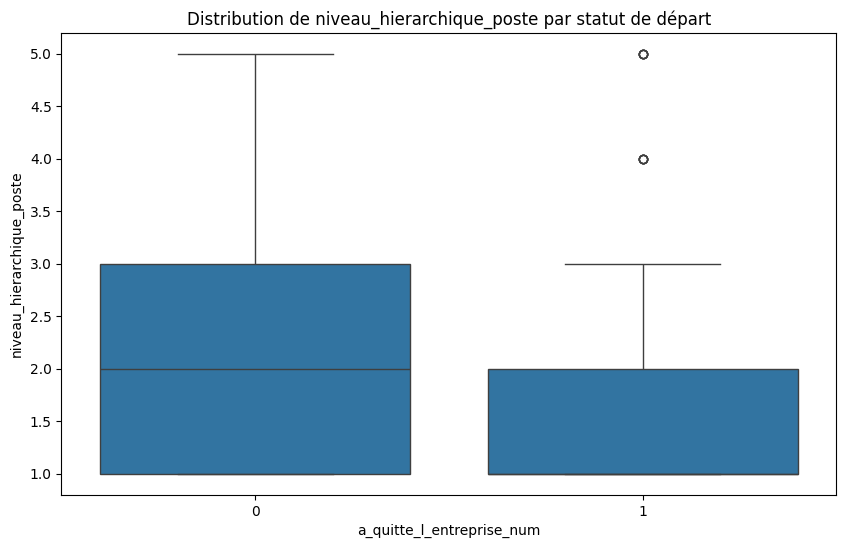

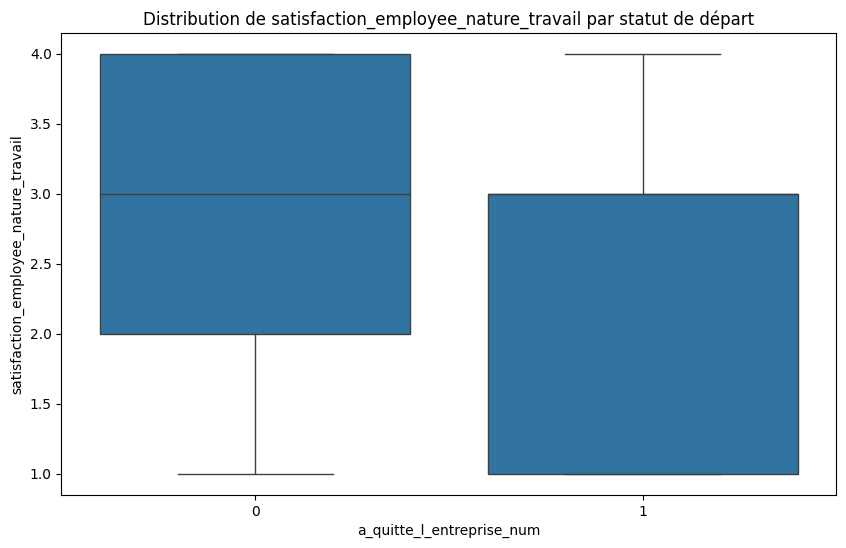

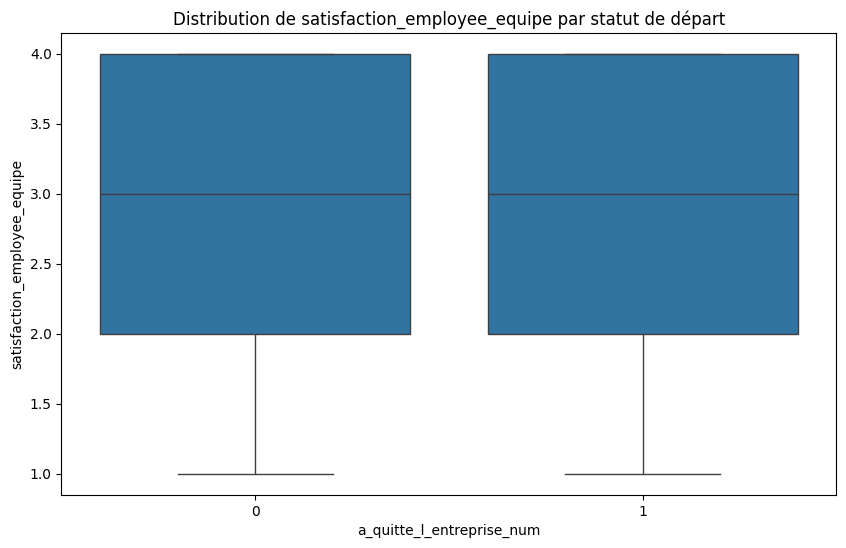

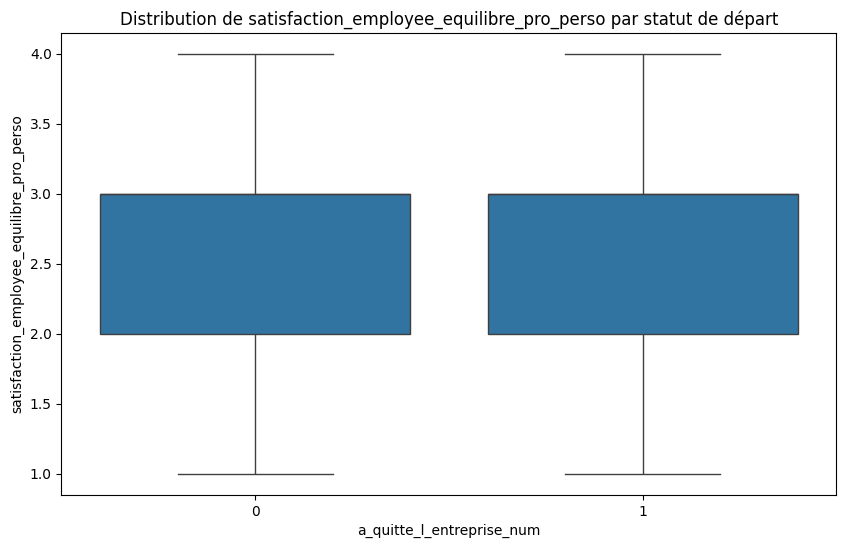

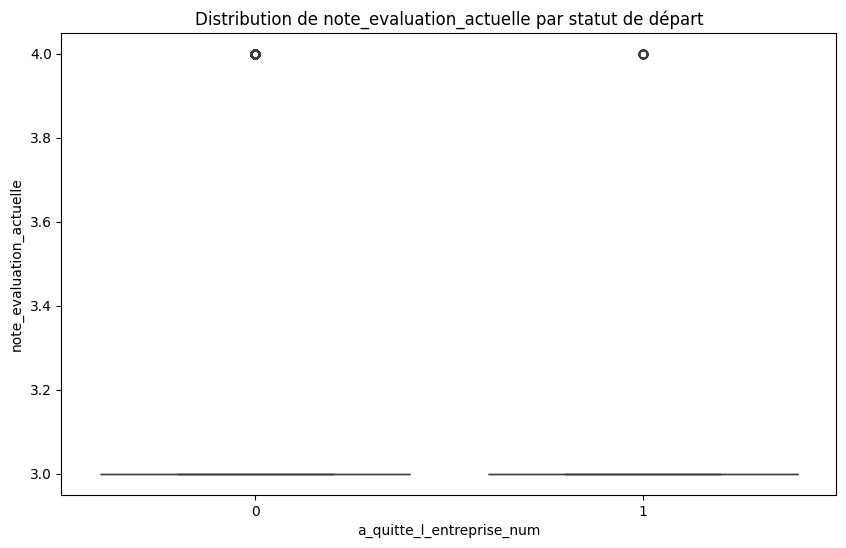

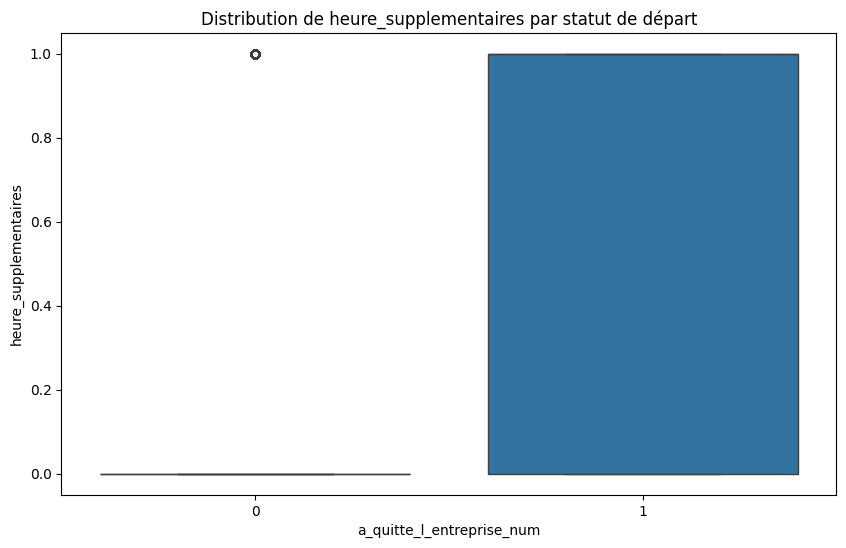

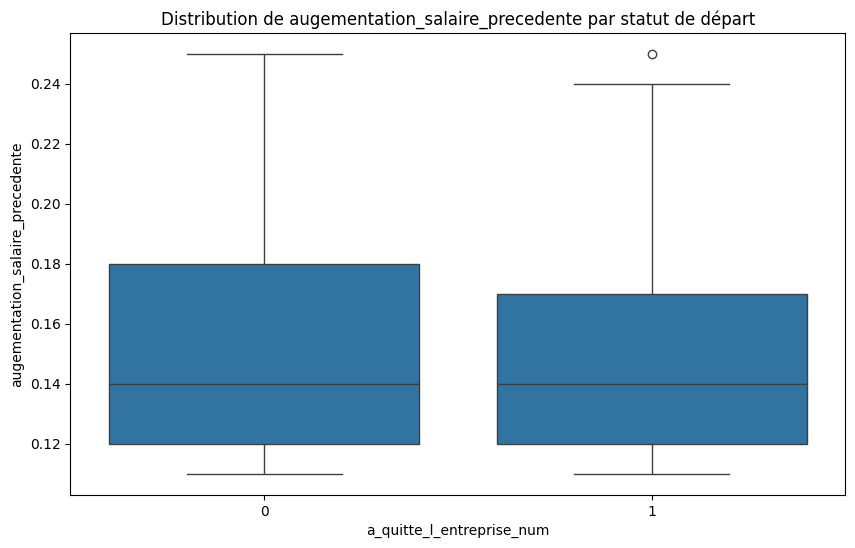

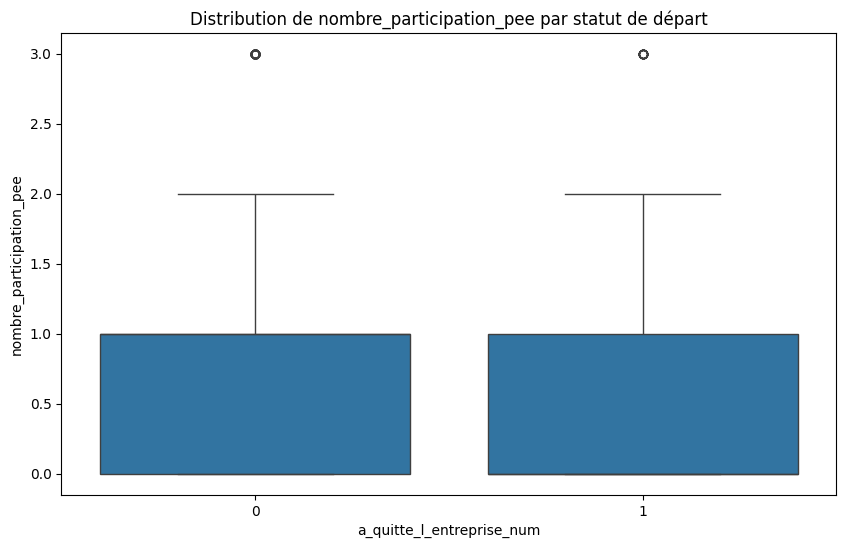

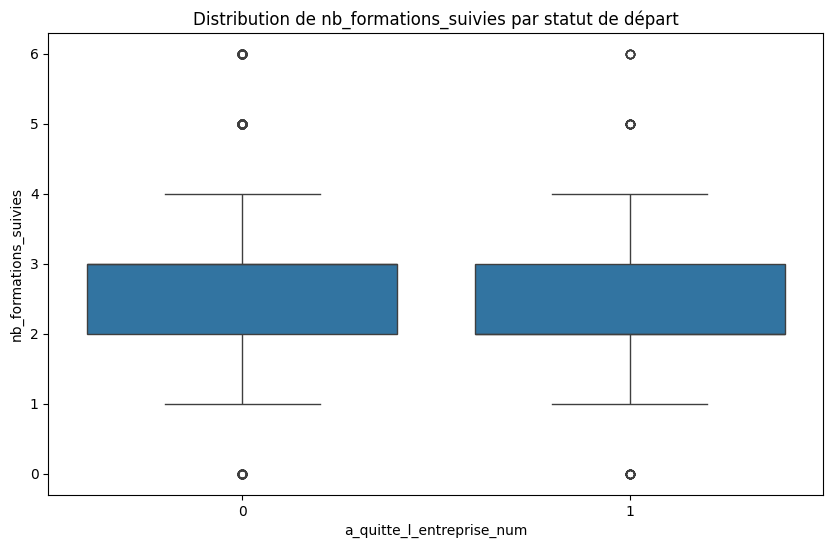

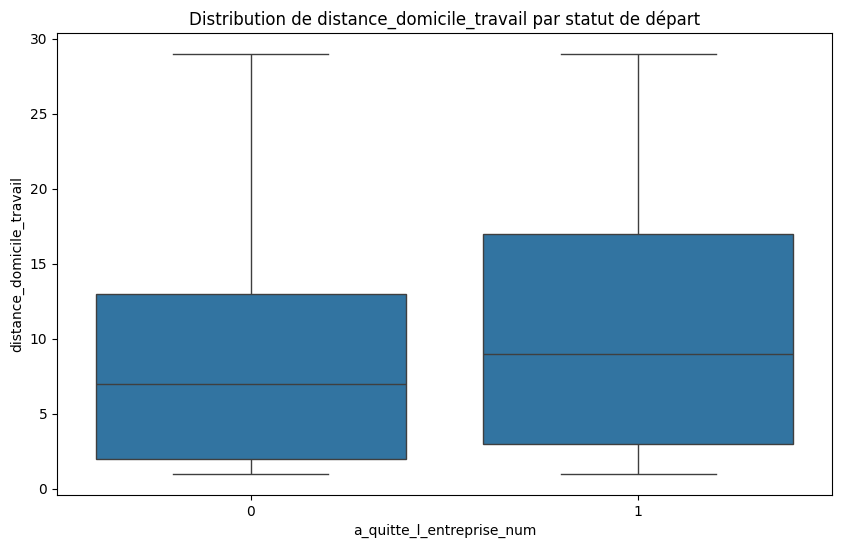

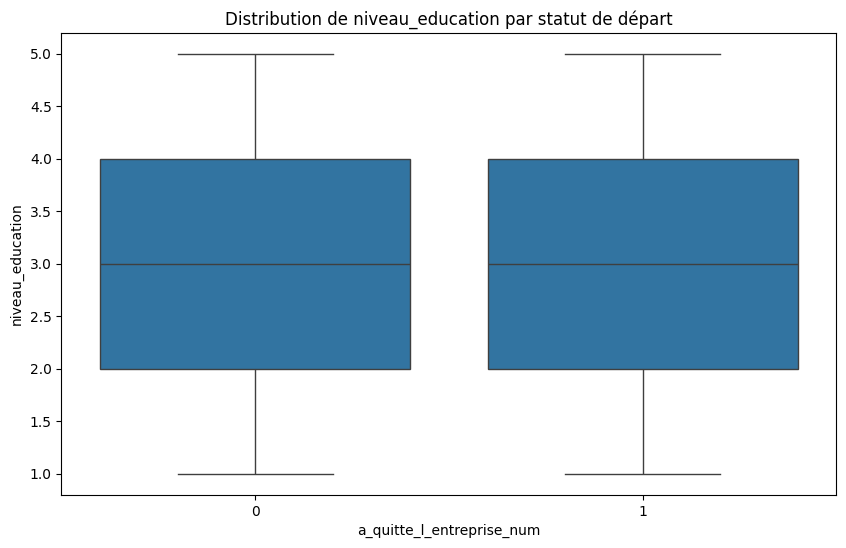

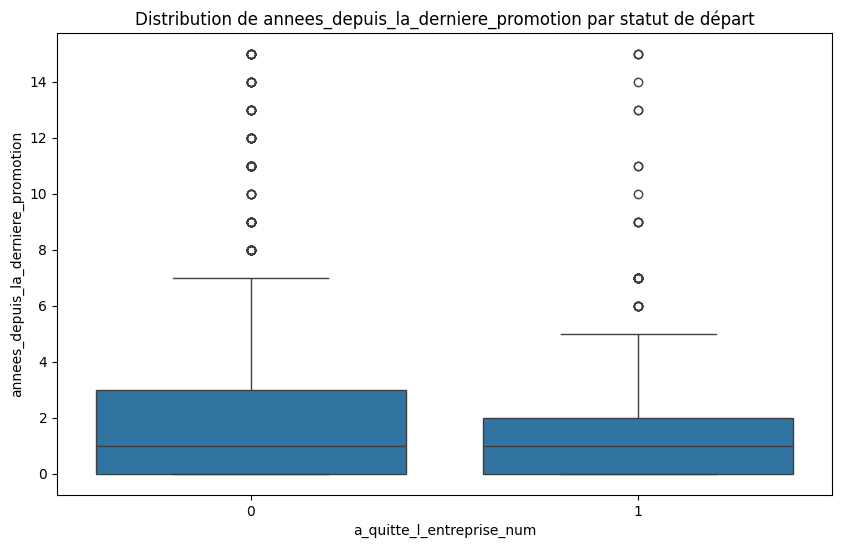

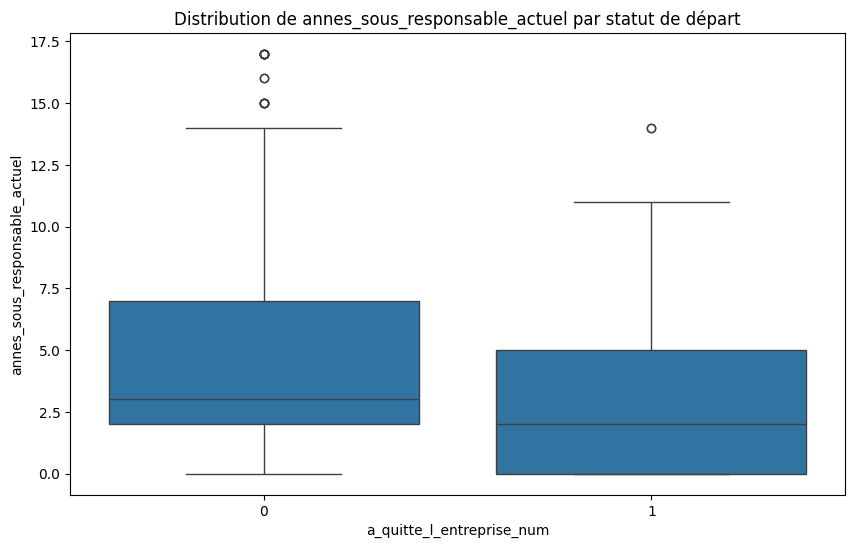

In [57]:
# Visualisation
for feature in features_num_to_analyse.drop('a_quitte_l_entreprise_num'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='a_quitte_l_entreprise_num', y=feature, data=df)
    plt.title(f'Distribution de {feature} par statut de départ')
    plt.show()

- **`a_quitte_l_entreprise_num` & `age`** : une différence significative dans la distribution de l'âge entre les deux groupes. Les employés qui quittent l'entreprise sont généralement plus jeunes que ceux qui restent

- **`a_quitte_l_entreprise_num` & `revenu_mensuel`** : les employés qui démissionnent ont tendance à être dans des tranches de revenus plus basses que leurs collègues qui restent.

- **`a_quitte_l_entreprise_num` & `nombre_experiences_precedentes`** : les employés qui quittent l'entreprise ont généralement plus d'expériences professionnelles que ceux qui restent.

- **`a_quitte_l_entreprise_num` & `annee_experience_totale`** : les employés qui ont moins d'années d'expérience totale ont plus tendance à démissionner.

- **`a_quitte_l_entreprise_num` & `annees_dans_l_entreprise`** : la majorité des départs se produisent dans les premières années d'ancienneté. Cela suggère que la période la plus critique pour la rétention est le début de carrière de l'employé au sein de votre entreprise.

- **`a_quitte_l_entreprise_num` & `annees_dans_le_poste_actuel`** : les démissions ont tendance à se produire chez les employés qui sont dans leur poste actuel depuis une période relativement courte. C'est un indicateur fort du fait que le manque d'évolution ou de changement de poste peut être un facteur de départ.

- **`a_quitte_l_entreprise_num` & `satisfaction_employee_environnement`** : Les employés qui démissionnent ont tendance à être moins satisfaits de leur environnement que ceux qui restent.

- **`a_quitte_l_entreprise_num` & `note_evaluation_precedente`** : la note d'évaluation précédente n'est pas un facteur discriminant pour la démission. Cela signifie que la démission n'est pas liée à une mauvaise performance perçue par l'entreprise. C'est le signe que le problème de démission est probablement lié à d'autres facteurs comme l'environnement de travail, le revenu, l'ancienneté ou la satisfaction professionnelle.

- **`a_quitte_l_entreprise_num` & `niveau_hierarchique_poste`** : les employés partis ont un niveau hiérarchique médian légèrement inférieur à ceux restés. Les postes moins élevés pourraient être associés à un turnover plus important.

- **`a_quitte_l_entreprise_num` & `satisfaction_employee_nature_travail`** : employés qui démissionnent ont tendance à être moins satisfaits de la nature de leur travail que ceux qui restent. Elle confirme que le contenu du poste lui-même est un facteur clé de la rétention des employés.

- **`a_quitte_l_entreprise_num` & `satisfaction_employee_equipe`** : la satisfaction envers l'équipe ne semble pas être un facteur déterminant dans la décision de quitter l'entreprise. Les employés partis et restés ont des niveaux de satisfaction similaires envers leur équipe.

- **`a_quitte_l_entreprise_num` & `satisfaction_employee_equilibre_pro_perso`** : employés qui démissionnent ont tendance à être moins satisfaits de cet équilibre que ceux qui restent.

- **`a_quitte_l_entreprise_num` & `note_evaluation_actuelle`** : la note d'évaluation actuelle n'est pas un facteur discriminant pour la démission. Cela renforce l'idée que les départs ne sont pas le résultat d'une performance jugée insuffisante. Les employés qui partent peuvent être de bons éléments, dont la décision est motivée par d'autres facteurs comme la satisfaction au travail, l'ancienneté ou le salaire.

- **`a_quitte_l_entreprise_num` & `heure_supplementaires`** : les employés qui font des heures supplémentaires ont plus tendance à quitter l'entreprise.

- **`a_quitte_l_entreprise_num` & `augmentation_salaire_precedente`** : les employés qui démissionnent ont tendance à recevoir des augmentations plus faibles que ceux qui restent. Les facteurs financiers et la reconnaissance sont des moteurs clés pour la rétention des employés.

- **`a_quitte_l_entreprise_num` & `nombre_participation_pee`** : les employés qui démissionnent ont tendance à ne pas participer au PEE, ce qui est un signe de désengagement ou d'un manque de projection à long terme dans l'entreprise.

- **`a_quitte_l_entreprise_num` & `nb_formations_suivies`** : la différence dans le nombre de formations suivies entre les employés partis et restés est très faible. La principale différence se situe au niveau de la médiane (3 vs 2), suggérant une très légère tendance où les employés restés ont un nombre de formations légèrement plus élevé. Cependant, les quartiles et l'étendue étant presque identiques, on ne peut pas conclure que suivre beaucoup de formations retient un employé, ni que ne pas en suivre le fait partir. Le nombre de formations suivies ne semble pas être un facteur déterminant ou fortement prédictif du départ d'un employé.

- **`a_quitte_l_entreprise_num` & `distance_domicile_travail`** : la distance domicile-travail est un facteur de risque de démission. Les employés qui ont un trajet plus long ont tendance à démissionner davantage que ceux qui habitent près de leur lieu de travail.

- **`a_quitte_l_entreprise_num` & `niveau_education`** : le niveau d'éducation ne semble pas être un facteur lié à la démission. Contrairement au revenu, à l'ancienneté ou à la satisfaction, la formation initiale des employés n'influence pas leur décision de quitter l'entreprise.

- **`a_quitte_l_entreprise_num` & `annee_depuis_la_derniere_promotion`** : les employés qui partent ont tendance à avoir été promus plus récemment.

- **`a_quitte_l_entreprise_num` & `annes_sous_responsable_actuel`** : les employés qui ont quitté l'entreprise ont passé significativement moins de temps avec leur manager actuel que ceux qui sont restés.

**Synthèse des facteurs de turnover : Analyse bivariée**

**Facteurs clés influençant les démissions**
Les employés qui quittent l'entreprise partagent des **profils types** et des **motivations communes**, principalement liées à :
- **L'âge et l'expérience** : Plus jeunes, avec plus d'expériences précédentes mais moins d'ancienneté dans l'entreprise.
- **La rémunération et la reconnaissance** : Revenus plus bas, augmentations salariales plus faibles, et manque de perspectives d'évolution.
- **La satisfaction au travail** : Insatisfaction vis-à-vis de la nature du travail, de l'environnement, et de l'équilibre vie pro/perso.
- **Les conditions de travail** : Heures supplémentaires fréquentes, trajets domicile-travail longs, et manque d'engagement à long terme (ex. : non-participation au PEE).

---

**Facteurs significatifs (à prioriser pour réduire le turnover)**
   **Variable**                          | **Insight**                                                                                     | **Action recommandée**                                                                                     |
 |---------------------------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------|
 | **Âge**                               | Employés partis sont **plus jeunes**.                                                          | Cibler les **jeunes talents** avec des programmes de mentorat et des parcours de carrière clairs.          |
 | **Revenu mensuel**                    | Salaire **plus bas** chez les partis.                                                          | Revoir la **grille salariale** et les **augmentations** pour les postes juniors.                           |
 | **Années dans l'entreprise**          | Départs concentrés dans les **premières années** (période critique : 0–3 ans).                | Renforcer l’**onboarding** et les **opportunités d’évolution rapide** pour les nouveaux embauchés.         |
 | **Ancienneté dans le poste actuel**   | Turnover élevé chez les employés **récemment arrivés dans leur poste**.                        | **Rotations internes** et **évolutions fréquentes** pour éviter la stagnation.                              |
 | **Satisfaction (nature du travail, équilibre pro/perso, environnement)** | **Moins satisfaits** sur ces 3 dimensions.                                                     | Améliorer les **conditions de travail**, la **flexibilité**, et l’**ergonomie des postes**.                |
 | **Niveau hiérarchique**               | Postes **moins élevés** plus touchés par le turnover.                                          | Offrir des **perspectives de promotion** et des **responsabilités accrues** aux postes juniors.            |
 | **Heures supplémentaires**           | Les employés faisant des **heures sup** quittent plus.                                        | Limiter les heures sup, promouvoir l’**équilibre vie pro/perso**, et compenser financièrement.             |
 | **Augmentations salariales**          | Augmentations **plus faibles** chez les partis.                                                | **Réviser la politique de rémunération** et lier les augmentations à la performance et à l’ancienneté.     |
 | **Participation au PEE**              | **Non-participation** au PEE = signe de désengagement.                                         | **Sensibiliser aux avantages du PEE** et simplifier l’adhésion.                                            |
 | **Distance domicile-travail**         | Trajets **plus longs** chez les partis (médiane : 9 km vs 7 km).                                | Étendre le **télétravail**, rembourser les frais de transport, ou ouvrir des bureaux satellites.           |
 | **Années sous le même responsable**   | Moins de temps avec leur **manager actuel** (relation récente ou instable ?).                 | **Former les managers** à la rétention et évaluer la qualité du management.                                |

---

**Facteurs non discriminants (peu ou pas liés au turnover)**
 | **Variable**                          | **Insight**                                                                                     |
 |---------------------------------------|------------------------------------------------------------------------------------------------|
 | **Notes d'évaluation**                | Aucune différence entre partis et restés → Les démissions ne sont **pas liées à la performance**. |
 | **Satisfaction envers l'équipe**      | Niveaux similaires → L’équipe n’est **pas un facteur clé** de départ.                          |
 | **Niveau d'éducation**                | Aucun lien → Le turnover ne dépend **pas du diplôme**.                                          |
 | **Nombre de formations suivies**      | Différence minime (médiane : 3 vs 2) → **Peu impactant**.                                       |
 | **Délai depuis la dernière promotion**| Les partis ont été promus **plus récemment** (contre-intuitif, à creuser).                     |

---

In [58]:
stats_par_groupe = df_final.groupby('a_quitte_l_entreprise_num')[['nombre_participation_pee']].describe().T

# Afficher le tableau de statistiques
print("Statistiques descriptives par groupe (0=resté, 1=parti):")
print(stats_par_groupe)

Statistiques descriptives par groupe (0=resté, 1=parti):
a_quitte_l_entreprise_num                 0           1
nombre_participation_pee count  1233.000000  237.000000
                         mean      0.845093    0.527426
                         std       0.841985    0.856361
                         min       0.000000    0.000000
                         25%       0.000000    0.000000
                         50%       1.000000    0.000000
                         75%       1.000000    1.000000
                         max       3.000000    3.000000


In [59]:
stats_par_groupe = df_final.groupby('a_quitte_l_entreprise_num')[['nb_formations_suivies']].describe().T

# Afficher le tableau de statistiques
print("Statistiques descriptives par groupe (0=resté, 1=parti):")
print(stats_par_groupe)

Statistiques descriptives par groupe (0=resté, 1=parti):
a_quitte_l_entreprise_num              0           1
nb_formations_suivies count  1233.000000  237.000000
                      mean      2.832928    2.624473
                      std       1.293585    1.254784
                      min       0.000000    0.000000
                      25%       2.000000    2.000000
                      50%       3.000000    2.000000
                      75%       3.000000    3.000000
                      max       6.000000    6.000000


In [60]:
stats_par_groupe = df_final.groupby('a_quitte_l_entreprise_num')[['annes_sous_responsable_actuel']].describe().T

# Afficher le tableau de statistiques
display(stats_par_groupe)

a_quitte_l_entreprise_num                      0           1
annes_sous_responsable_actuel count  1233.000000  237.000000
                              mean      4.367397    2.852321
                              std       3.594116    3.143349
                              min       0.000000    0.000000
                              25%       2.000000    0.000000
                              50%       3.000000    2.000000
                              75%       7.000000    5.000000
                              max      17.000000   14.000000

### Analyse bivarié : colonnes catégorielles et 'a_quitte_l_entreprise'

In [61]:
# Taux de démission global
taux_demission_global = df_final['a_quitte_l_entreprise'].value_counts(normalize=True).loc['Oui'] * 100
print(f"Taux de démission global de l'entreprise : {taux_demission_global:.2f}%\n")

Taux de démission global de l'entreprise : 16.12%



Analyse de la variable 'genre' :

a_quitte_l_entreprise       Non       Oui
genre                                    
F                      0.852041  0.147959
M                      0.829932  0.170068




C:\Users\artur\AppData\Local\Temp\ipykernel_22880\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


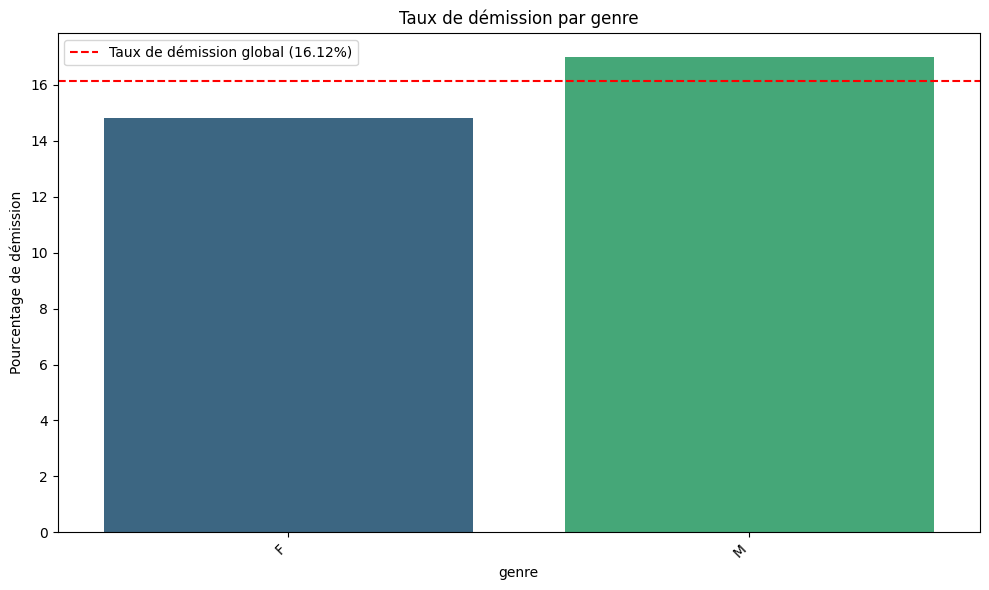

Analyse de la variable 'statut_marital' :

a_quitte_l_entreprise       Non       Oui
statut_marital                           
Célibataire            0.744681  0.255319
Divorcé(e)             0.899083  0.100917
Marié(e)               0.875186  0.124814




C:\Users\artur\AppData\Local\Temp\ipykernel_22880\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


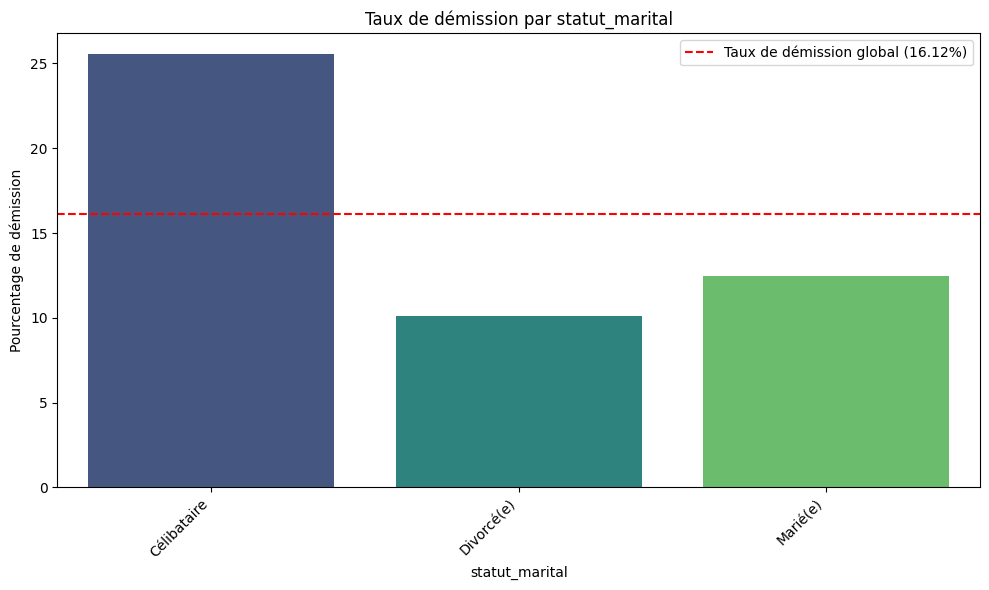

Analyse de la variable 'departement' :

a_quitte_l_entreprise       Non       Oui
departement                              
Commercial             0.793722  0.206278
Consulting             0.861602  0.138398
Ressources Humaines    0.809524  0.190476




C:\Users\artur\AppData\Local\Temp\ipykernel_22880\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


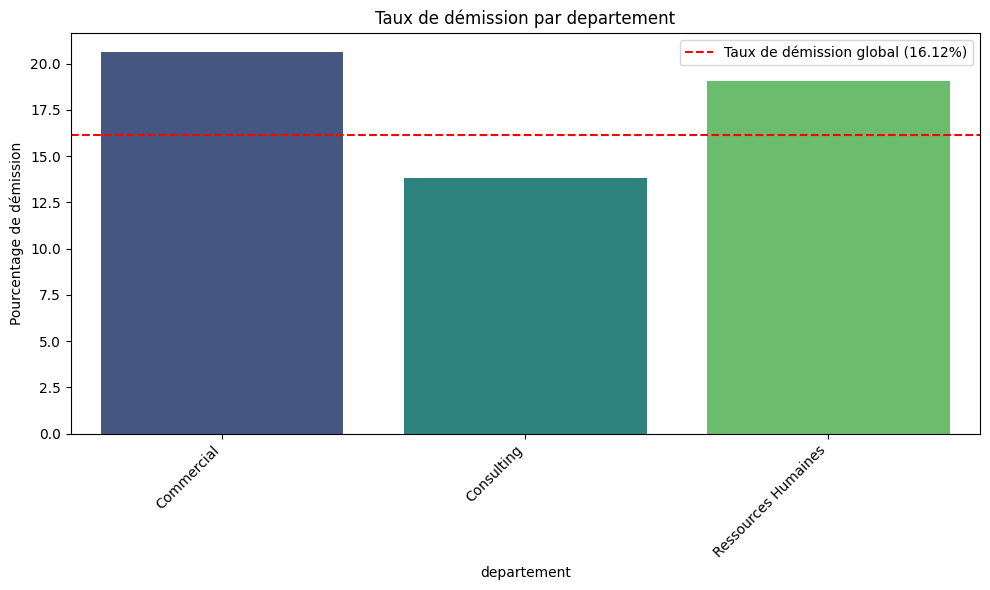

Analyse de la variable 'poste' :

a_quitte_l_entreprise         Non       Oui
poste                                      
Assistant de Direction   0.839041  0.160959
Cadre Commercial         0.825153  0.174847
Consultant               0.760618  0.239382
Directeur Technique      0.975000  0.025000
Manager                  0.931298  0.068702
Représentant Commercial  0.602410  0.397590
Ressources Humaines      0.769231  0.230769
Senior Manager           0.950980  0.049020
Tech Lead                0.931034  0.068966




C:\Users\artur\AppData\Local\Temp\ipykernel_22880\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


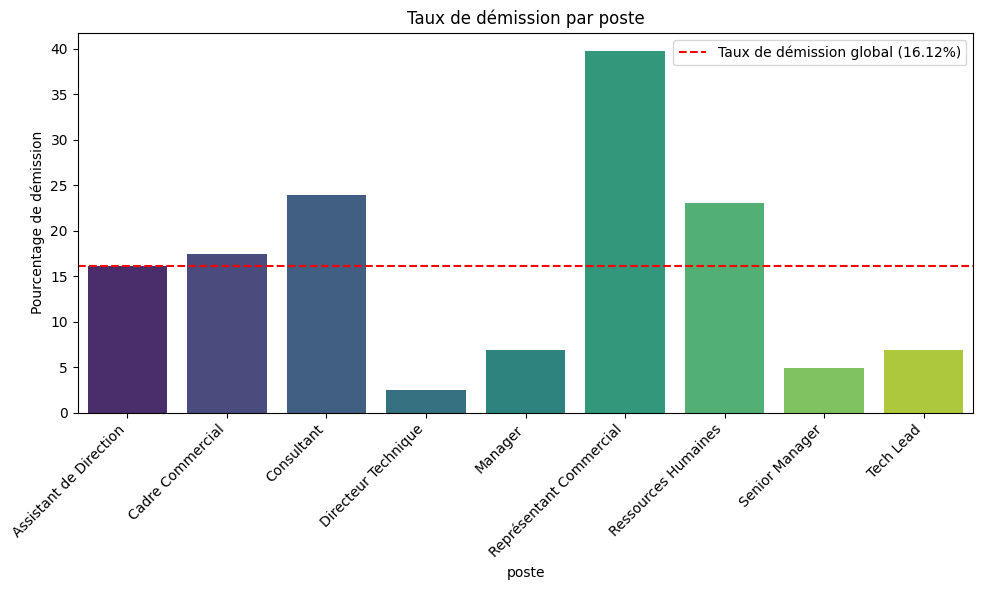

Analyse de la variable 'domaine_etude' :

a_quitte_l_entreprise         Non       Oui
domaine_etude                              
Autre                    0.865854  0.134146
Entrepreunariat          0.757576  0.242424
Infra & Cloud            0.853135  0.146865
Marketing                0.779874  0.220126
Ressources Humaines      0.740741  0.259259
Transformation Digitale  0.864224  0.135776




C:\Users\artur\AppData\Local\Temp\ipykernel_22880\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


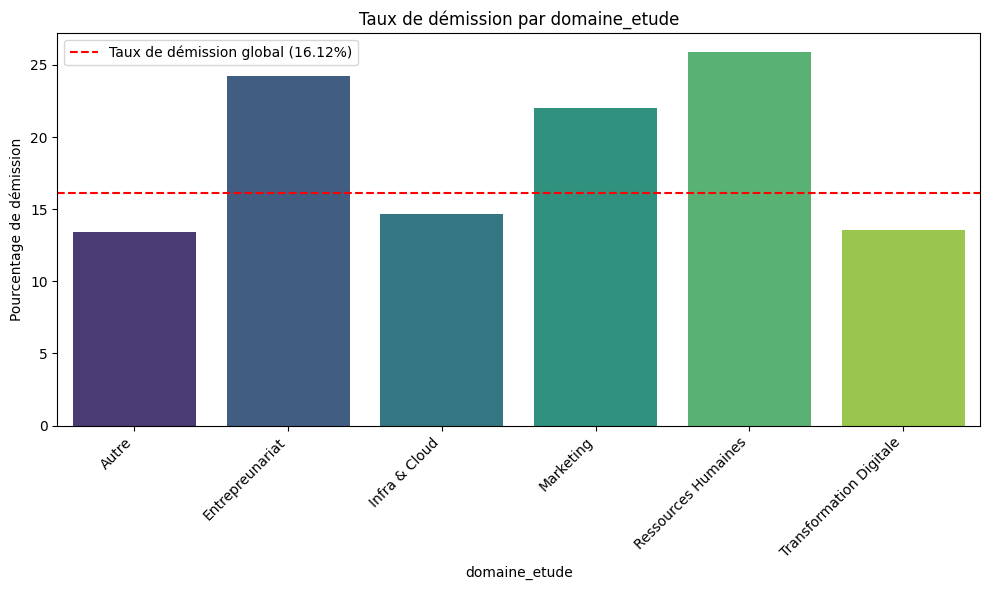

Analyse de la variable 'ayant_enfants' :

a_quitte_l_entreprise       Non       Oui
ayant_enfants                            
Y                      0.838776  0.161224




C:\Users\artur\AppData\Local\Temp\ipykernel_22880\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


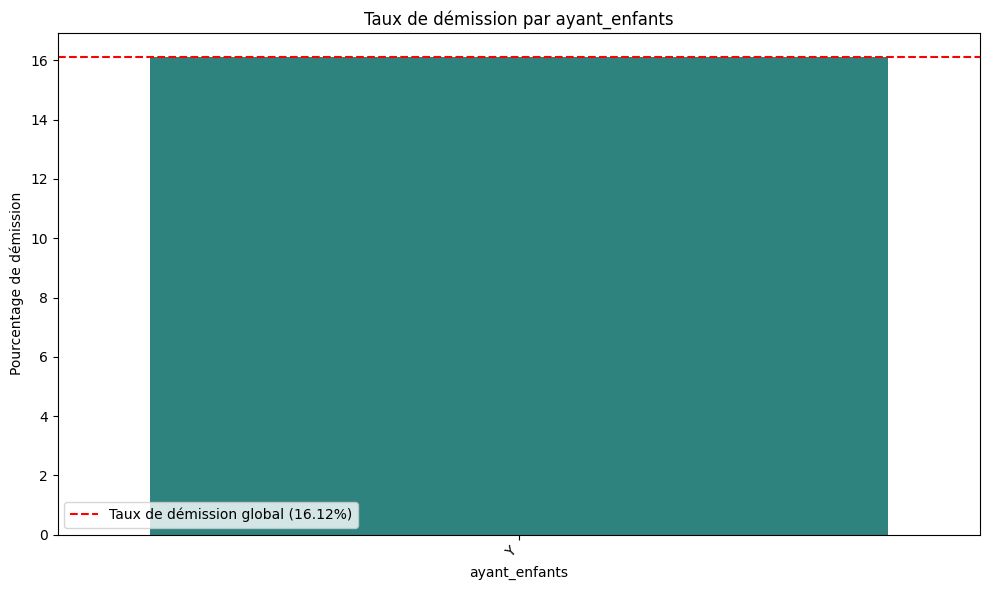

Analyse de la variable 'frequence_deplacement' :

a_quitte_l_entreprise       Non       Oui
frequence_deplacement                    
Aucun                  0.920000  0.080000
Frequent               0.750903  0.249097
Occasionnel            0.850431  0.149569




C:\Users\artur\AppData\Local\Temp\ipykernel_22880\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


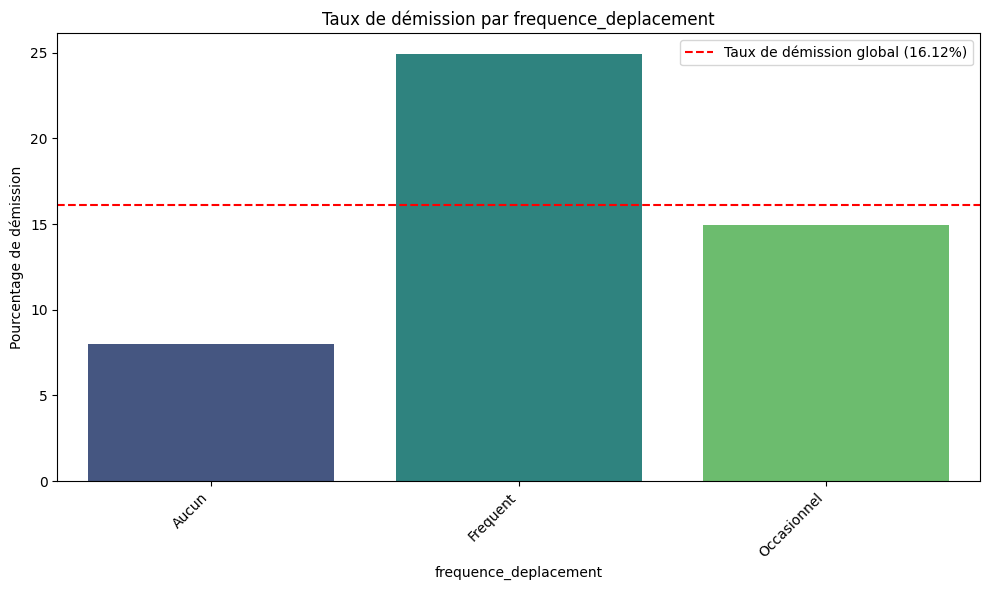

In [62]:
for col in categorical_cols:
    if col != 'a_quitte_l_entreprise':
        # Calculer les pourcentages de démission par catégorie
        df_group = (df_final.groupby([col, 'a_quitte_l_entreprise']).size().unstack(fill_value=0)
                    .apply(lambda x: x / x.sum(), axis=1))

        # Afficher la table des pourcentages
        print(f"Analyse de la variable '{col}' :\n")
        print(df_group.to_string())
        print("\n" + "="*50 + "\n")

        # Créer le diagramme en barres
        plt.figure(figsize=(10, 6))
        sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')
        
        # Ajouter une ligne pour le taux de démission global
        plt.axhline(y=taux_demission_global, color='red', linestyle='--', label=f'Taux de démission global ({taux_demission_global:.2f}%)')
        
        plt.title(f'Taux de démission par {col}')
        plt.xlabel(col)
        plt.ylabel('Pourcentage de démission')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()

- `a_quitte_l_entreprise` & `genre` : Le taux de démission est plus élevé chez les hommes que chez les femmes dans votre entreprise. Toutefois, la différence entre les deux pourcentages est relativement faible (17.01%−14.79%=2.22%). Cela suggère que le genre n'est pas le facteur le plus déterminant pour expliquer le turnover, mais il existe une légère tendance.

- `a_quitte_l_entreprise` & `statut_marital` : Les célibataires sont beaucoup plus enclins à quitter l'entreprise que les employés mariés ou divorcés. Le taux de démission chez les célibataires est presque deux fois supérieur à celui des employés mariés, et deux fois et demie supérieur à celui des divorcés.

- `a_quitte_l_entreprise` & `departement` : Le département est clairement un facteur discriminant dans le turnover des employés. (Commercial > RH > Consulting)

- `a_quitte_l_entreprise` & `poste` :
     - Postes à risque élevé :
        - Représentant Commercial (39.76%) : Taux 2.5 fois supérieur à la moyenne.
        - Consultant (23.94%)
        - Ressources Humaines (23.08%)
    
    - Poste dans la moyenne :
        - Cadre Commercial (17.45%)
        - Assistant de Direction (16.10%)

    - Postes stables :
        - Tech Lead (6.89%)
        - Manager (6.87%)
        - Senior Manager (4.92%)
        - Directeur Technique (2.50%)

- `a_quitte_l_entreprise` & `domaine_etude` : Les diplômés en RH, Entrepreneuriat et Marketing quittent significativement plus l'entreprise

- `a_quitte_l_entreprise` & `ayant_enfants` : **ayant_enfants** est une constante, une étude statistique n'a pas de sense.

- `a_quitte_l_entreprise` & `frequence_deplacement` : Les employés qui se déplacent fréquemment quittent 1.55 fois plus que la moyenne.

# Etape 2 : préparation des données pour la modélisation

In [63]:
df_final = df_final.drop(['a_quitte_l_entreprise'], axis=1)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 32 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id_employee                                1470 non-null   int64  
 1   age                                        1470 non-null   int64  
 2   genre                                      1470 non-null   object 
 3   revenu_mensuel                             1470 non-null   int64  
 4   statut_marital                             1470 non-null   object 
 5   departement                                1470 non-null   object 
 6   poste                                      1470 non-null   object 
 7   nombre_experiences_precedentes             1470 non-null   int64  
 8   nombre_heures_travailless                  1470 non-null   int64  
 9   annee_experience_totale                    1470 non-null   int64  
 10  annees_dans_l_entreprise

## Séparation des données en X et y

In [64]:
# Fonction pour préparer les données pour le modèle
def prepare_data_for_modeling(df, target_column):
    """
    Sépare les features (X) et la variable cible (y) du DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données brutes.

    Returns:
        tuple: Un tuple (X, y) où X est le DataFrame des features et y est la série de la cible.
    """
    # S'assurer que la colonne cible est présente
    if target_column not in df.columns:
        print(f"Erreur: La colonne '{target_column}' n'est pas présente dans le DataFrame.")
        return None, None

    # Séparer les features et la cible
    X = df.drop(columns=[target_column])
    y = df[target_column]

    print("Données séparées avec succès !")
    print(f"Dimension de X (features): {X.shape}")
    print(f"Dimension de y (cible): {y.shape}")
    
    return X, y

In [65]:
# Définir la colonne cible
target_column = 'a_quitte_l_entreprise_num'

X, y = prepare_data_for_modeling(df_final, target_column)

Données séparées avec succès !
Dimension de X (features): (1470, 31)
Dimension de y (cible): (1470,)


In [66]:
# Identification des features qualitatives et quantitatives
qualitative_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
quantitative_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Features qualitatives:", qualitative_features)
print("Features quantitatives:", quantitative_features)

Features qualitatives: ['genre', 'statut_marital', 'departement', 'poste', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement']
Features quantitatives: ['id_employee', 'age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'distance_domicile_travail', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']


Les colonnes suivantes n'ont aucun impact sur la prédication :
- **'nombre_heures_travailless'** : est une constante '80'
- **'ayant_enfants'** : une constante uniquement 'Y'

In [67]:
# Colonnes à supprimer car elles n'apportent pas d'information pertinente
columns_to_drop = ['nombre_heures_travailless', 'ayant_enfants']

X = X.drop(columns=columns_to_drop)

print("Données séparées et nettoyées avec succès !")
print(f"Dimension de X (features): {X.shape}")
print(f"Dimension de y (cible): {y.shape}")

Données séparées et nettoyées avec succès !
Dimension de X (features): (1470, 29)
Dimension de y (cible): (1470,)


## Encodage des variables

In [68]:
df_final[X.columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id_employee                                1470 non-null   int64  
 1   age                                        1470 non-null   int64  
 2   genre                                      1470 non-null   object 
 3   revenu_mensuel                             1470 non-null   int64  
 4   statut_marital                             1470 non-null   object 
 5   departement                                1470 non-null   object 
 6   poste                                      1470 non-null   object 
 7   nombre_experiences_precedentes             1470 non-null   int64  
 8   annee_experience_totale                    1470 non-null   int64  
 9   annees_dans_l_entreprise                   1470 non-null   int64  
 10  annees_dans_le_poste_act

In [69]:
from sklearn.preprocessing import OneHotEncoder

# Initialiser l'encodeur
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

# Identifier les colonnes de type 'object' ou 'category'
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Ajuster et transformer les données catégorielles
encoded_features = ohe.fit_transform(X[categorical_features])

In [70]:
# Créer un DataFrame avec les nouvelles colonnes encodées
encoded_feature_names = ohe.get_feature_names_out(categorical_features)
df_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=X.index)

# Concaténer le DataFrame des features numériques et le DataFrame encodé
X_processed = pd.concat([X.drop(columns=categorical_features), df_encoded], axis=1)

print("\nEncodage One-Hot des variables catégorielles terminé.")
print(f"Nouvelle dimension de X (après encodage): {X_processed.shape}")


Encodage One-Hot des variables catégorielles terminé.
Nouvelle dimension de X (après encodage): (1470, 43)


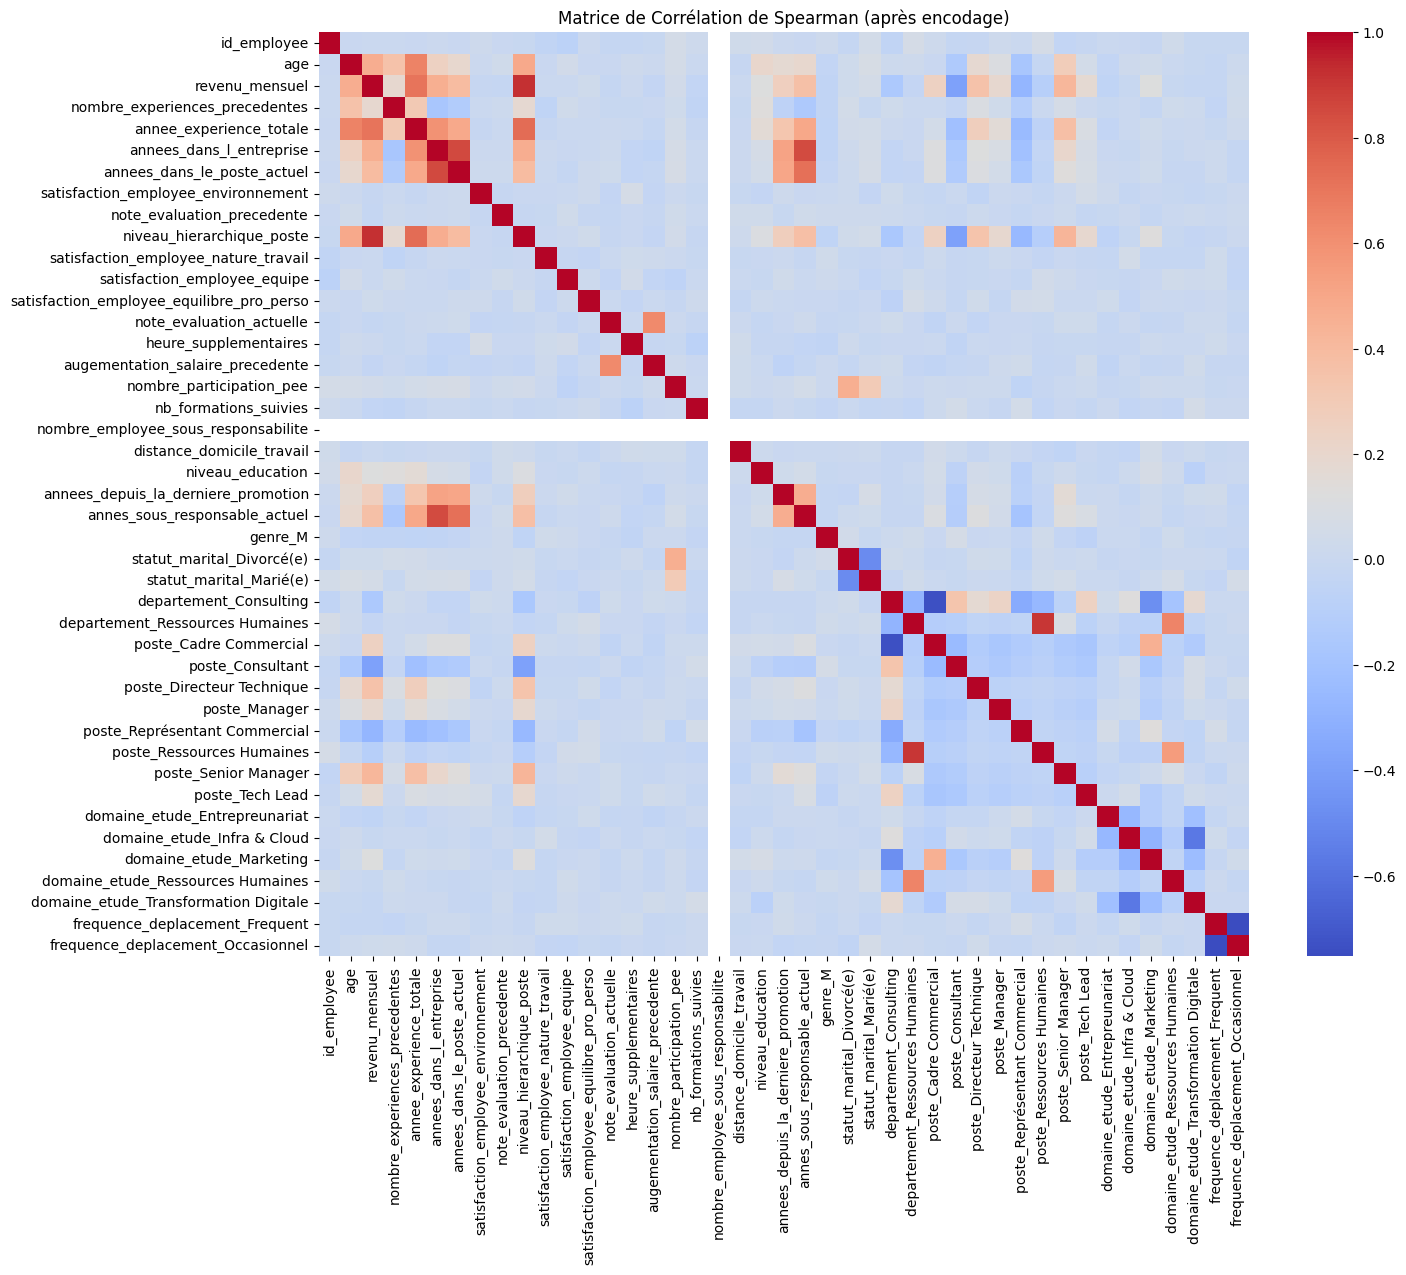

In [71]:
# Afficher la matrice de corrélation pour les features traitées
plt.figure(figsize=(15, 12))
correlation_matrix = X_processed.corr(method='spearman')
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Matrice de Corrélation de Spearman (après encodage)")
plt.show()

In [72]:
# Trouver les paires de features avec une forte corrélation
# Créer une matrice de corrélation de Pearson
corr_matrix = X_processed.corr(method='spearman').abs()

# Isoler le triangle supérieur de la matrice pour éviter les doublons
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Trouver les colonnes avec une corrélation supérieure à 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# Afficher les paires de colonnes fortement corrélées
print("\nPaires de features fortement corrélées (> 0.70) :")
for i in range(len(upper.columns)):
    for j in range(i + 1, len(upper.columns)):
        if upper.iloc[i, j] > 0.70:
            print(f"- '{upper.columns[i]}' et '{upper.columns[j]}' : {upper.iloc[i, j]:.2f}")

# Si des colonnes sont à supprimer, cela sera listé ici
if to_drop:
    print(f"\nColonnes à considérer pour la suppression : {to_drop}")
    print(f"Nombre total de colonnes à supprimer : {len(to_drop)}")
    print(f"Dimension de X avant suppression : {X_processed.shape[1]}")
    print(f"Dimension de X après suppression : {X_processed.shape[1] - len(to_drop)}")
else:
    print("\nAucune forte corrélation identifiée (seuil de 0.70).")


Paires de features fortement corrélées (> 0.70) :
- 'revenu_mensuel' et 'annee_experience_totale' : 0.71
- 'revenu_mensuel' et 'niveau_hierarchique_poste' : 0.92
- 'annee_experience_totale' et 'niveau_hierarchique_poste' : 0.73
- 'annees_dans_l_entreprise' et 'annees_dans_le_poste_actuel' : 0.85
- 'annees_dans_l_entreprise' et 'annes_sous_responsable_actuel' : 0.84
- 'annees_dans_le_poste_actuel' et 'annes_sous_responsable_actuel' : 0.72
- 'departement_Consulting' et 'poste_Cadre Commercial' : 0.73
- 'departement_Ressources Humaines' et 'poste_Ressources Humaines' : 0.90
- 'frequence_deplacement_Frequent' et 'frequence_deplacement_Occasionnel' : 0.75

Colonnes à considérer pour la suppression : ['annee_experience_totale', 'annees_dans_le_poste_actuel', 'niveau_hierarchique_poste', 'annes_sous_responsable_actuel', 'poste_Cadre Commercial', 'poste_Ressources Humaines', 'frequence_deplacement_Occasionnel']
Nombre total de colonnes à supprimer : 7
Dimension de X avant suppression : 43
Dim

In [73]:
X_processed = X_processed.drop(columns=to_drop)

In [74]:
# Trouver les paires de features avec une forte corrélation
# Créer une matrice de corrélation de Pearson
corr_matrix = X_processed.corr(method='spearman').abs()

# Isoler le triangle supérieur de la matrice pour éviter les doublons
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Trouver les colonnes avec une corrélation supérieure à 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# Afficher les paires de colonnes fortement corrélées
print("\nPaires de features fortement corrélées (> 0.70) :")
for i in range(len(upper.columns)):
    for j in range(i + 1, len(upper.columns)):
        if upper.iloc[i, j] > 0.70:
            print(f"- '{upper.columns[i]}' et '{upper.columns[j]}' : {upper.iloc[i, j]:.2f}")

# Si des colonnes sont à supprimer, cela sera listé ici
if to_drop:
    print(f"\nColonnes à considérer pour la suppression : {to_drop}")
else:
    print("\nAucune forte corrélation identifiée (seuil de 0.70).")


Paires de features fortement corrélées (> 0.70) :

Aucune forte corrélation identifiée (seuil de 0.70).


In [75]:
X_processed.shape

(1470, 36)

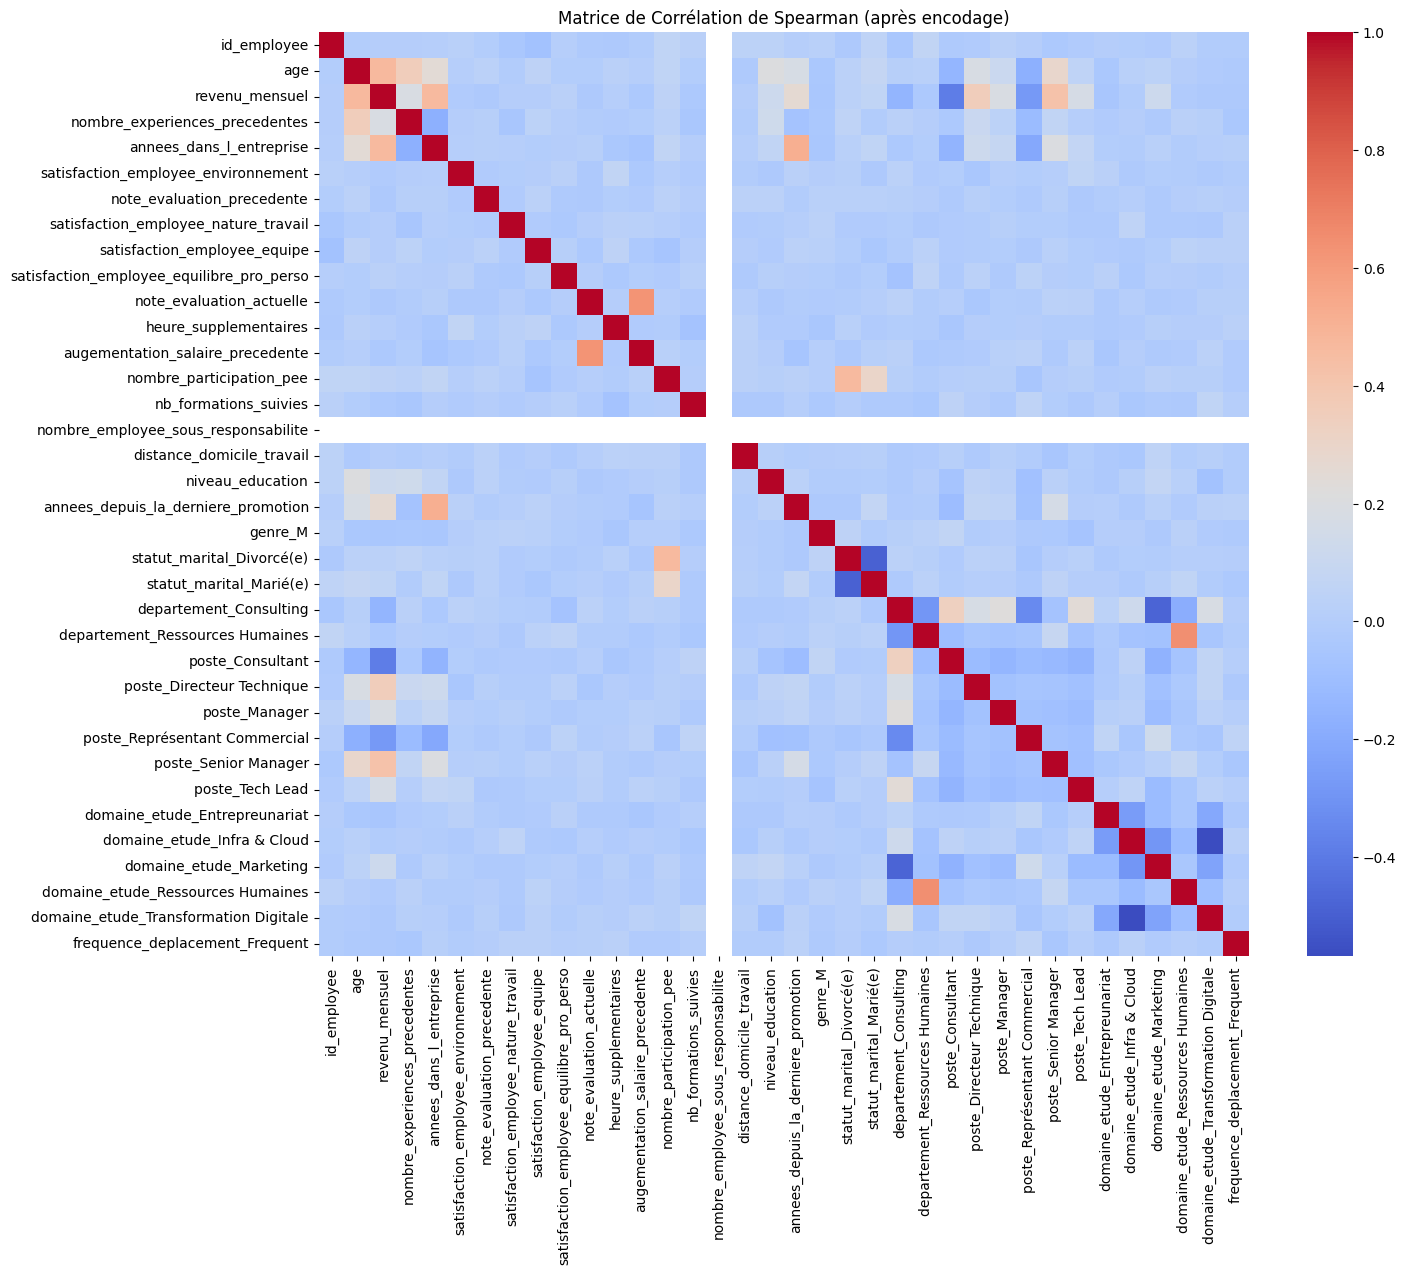

In [76]:
# Afficher la matrice de corrélation pour les features traitées
plt.figure(figsize=(15, 12))
correlation_matrix = X_processed.corr(method='spearman')
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Matrice de Corrélation de Spearman (après encodage)")
plt.show()

In [77]:
X = X_processed

# Etape 3 : réalisation d'un premier modèle de classification

- Modèles :
    - Dummy
    - Linéaire : LogisticRegression
    - Non-Linéaire : RandomForest, XGBoost ou CatBoost

In [78]:
def split_data(X, y, test_size=0.2, random_state=42):
    """
    Sépare les données en ensembles d'apprentissage et de test.

    Args:
        X (pd.DataFrame): Le DataFrame des features.
        y (pd.Series): La série de la variable cible.
        test_size (float): La proportion de l'ensemble de données à inclure dans le test split.
        random_state (int): Le nombre aléatoire pour la reproductibilité.

    Returns:
        tuple: Un tuple contenant (X_train, X_test, y_train, y_test).
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print("Données séparées avec succès !")
    print(f"Dimension de X_train : {X_train.shape}")
    print(f"Dimension de X_test : {X_test.shape}")
    print(f"Dimension de y_train : {y_train.shape}")
    print(f"Dimension de y_test : {y_test.shape}")

    return X_train, X_test, y_train, y_test

# Application de la fonction pour diviser les données
X_train, X_test, y_train, y_test = split_data(X, y)

Données séparées avec succès !
Dimension de X_train : (1176, 36)
Dimension de X_test : (294, 36)
Dimension de y_train : (1176,)
Dimension de y_test : (294,)


## Entraînement des modèles

Puisque nous sommes dans un contexte de prédiction de départ, les métriques essentielles sont la `la matrice de confusion`, le `Recall`, la `Precision`, `F1-score` et l'`AUC`.

- `Matrice de confusion` : un tableau qui résume les performances du modèle sur les prédictions qu'il a faites par rapport à la réalité. C'est une photographie des erreurs et des bonnes prédictions du modèle (TP, FN, FP, TN).

    - **true positives**  : Le modèle a prédit "Positif", et c'était la bonne prédiction
    - **true negatives**  : Le modèle a prédit "Négatif", et c'était la bonne prédiction
    - **false positives** : Le modèle a prédit "Positif", mais c'était faux
    - **false negatives** : Le modèle a prédit "Négatif", mais c'était faux

- `Recall` : mesure la capacité du modèle à identifier tous les cas positifs. Ex : un Recall de 90% signifie que le modèle a trouvé 90% des candidats qui allaient réellement réussir.

- `Precision` : mesure la capacité de votre modèle à ne pas faire de **Faux Positifs**. Exemple : une Precision de 90% signifie que lorsque le modèle prédit qu'un candidat va réussir, il a raison 90% du temps.

- `F1-score` : la moyenne harmonique de la Precision et du Recall. Le F1-score est une valeur entre 0 et 1. Plus il est proche de 1, meilleur est votre modèle. 


- `AUC` : une métrique qui évalue la capacité du modèle à distinguer les classes. Elle mesure la performance du modèle à différents seuils de classification.
    - Une valeur **AUC de 1** signifie que votre **modèle est parfait** et qu'il n'a fait aucune erreur de classement.
    - Une valeur **AUC de 0,5** signifie que le **modèle ne fait pas mieux que le hasard** (lancer une pièce de monnaie).
    - Une valeur **inférieure à 0,5** indique que le modèle est **pire que le hasard**, et qu'il y a probablement un problème.

Dans notre cas interpréter `Accuracy` ne sert à rien car nos données sont déséquilibrées 

In [79]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Entraîne et évalue trois modèles de classification en se concentrant sur les métriques clés 
    (Recall, Precision, F1-score, et AUC) pour le jeu d'ENTRAINEMENT et le jeu de TEST.

    Args:
        X_train (pd.DataFrame): Jeu d'entraînement des features.
        X_test (pd.DataFrame): Jeu de test des features.
        y_train (pd.Series): Jeu d'entraînement de la cible.
        y_test (pd.Series): Jeu de test de la cible.
    """
    
    # Liste des modèles à tester. class_weight='balanced' pour gérer le déséquilibre.
    models = {
        "DummyClassifier": DummyClassifier(strategy="most_frequent", random_state=42),
        "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', solver='liblinear'),
        "RandomForestClassifier": RandomForestClassifier(random_state=42, class_weight='balanced')
    }

    # Définition des jeux de données à évaluer (pour boucler sur Train et Test)
    datasets = {
        "ENTRAINEMENT": (X_train, y_train),
        "TEST": (X_test, y_test)
    }

    # Classe positive (celle qui va quitter)
    positive_class_index = 1 
    
    # Entraînement et évaluation pour chaque modèle
    for name, model in models.items():
        print(f"--- Entraînement et évaluation du modèle : {name} ---")
        
        # 1. Entraînement du modèle
        model.fit(X_train, y_train)
        
        # 2. Évaluation sur les deux jeux de données
        for set_name, (X, y_true) in datasets.items():
            
            # Prédiction des classes
            y_pred = model.predict(X)
            
            # Calcul de l'AUC (nécessite les probabilités)
            auc_score = "N/A"
            try:
                # Probabilités pour la classe positive (index 1)
                y_proba = model.predict_proba(X)[:, positive_class_index]
                auc_score = roc_auc_score(y_true, y_proba)
            except (AttributeError, ValueError):
                # Certains classifieurs comme DummyClassifier('most_frequent') n'ont pas predict_proba
                pass

            
            # Affichage des résultats
            print(f"\n[Performance sur le jeu de {set_name}]")
            
            # Rapport de classification (Precision, Recall, F1-score)
            print(classification_report(y_true, y_pred, target_names=['Reste (0)', 'Quitte (1)']))
            
            # Affichage de l'AUC
            print(f"Area Under Curve (AUC) : {auc_score:.4f}" if isinstance(auc_score, float) else f"Area Under Curve (AUC) : {auc_score}")
            
            # Affichage de la Matrice de Confusion
            print("\nMatrice de confusion :")
            cm = confusion_matrix(y_true, y_pred)
            # Rappel de la structure de la Matrice (VP pour la classe 1)
            print(f"[[VN, FP]\n [FN, VP]]") 
            print(cm)
        
        print("=" * 70) # Séparateur clair entre les modèles

In [80]:
# Application de la fonction pour entraîner et évaluer les modèles
train_and_evaluate_models(X_train, X_test, y_train, y_test)

--- Entraînement et évaluation du modèle : DummyClassifier ---

[Performance sur le jeu de ENTRAINEMENT]
              precision    recall  f1-score   support

   Reste (0)       0.84      1.00      0.91       986
  Quitte (1)       0.00      0.00      0.00       190

    accuracy                           0.84      1176
   macro avg       0.42      0.50      0.46      1176
weighted avg       0.70      0.84      0.76      1176

Area Under Curve (AUC) : 0.5000

Matrice de confusion :
[[VN, FP]
 [FN, VP]]
[[986   0]
 [190   0]]

[Performance sur le jeu de TEST]
              precision    recall  f1-score   support

   Reste (0)       0.84      1.00      0.91       247
  Quitte (1)       0.00      0.00      0.00        47

    accuracy                           0.84       294
   macro avg       0.42      0.50      0.46       294
weighted avg       0.71      0.84      0.77       294

Area Under Curve (AUC) : 0.5000

Matrice de confusion :
[[VN, FP]
 [FN, VP]]
[[247   0]
 [ 47   0]]
--- Ent

c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl


[Performance sur le jeu de ENTRAINEMENT]
              precision    recall  f1-score   support

   Reste (0)       1.00      1.00      1.00       986
  Quitte (1)       1.00      1.00      1.00       190

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176

Area Under Curve (AUC) : 1.0000

Matrice de confusion :
[[VN, FP]
 [FN, VP]]
[[986   0]
 [  0 190]]

[Performance sur le jeu de TEST]
              precision    recall  f1-score   support

   Reste (0)       0.85      0.99      0.92       247
  Quitte (1)       0.67      0.09      0.15        47

    accuracy                           0.85       294
   macro avg       0.76      0.54      0.53       294
weighted avg       0.82      0.85      0.79       294

Area Under Curve (AUC) : 0.8029

Matrice de confusion :
[[VN, FP]
 [FN, VP]]
[[245   2]
 [ 43   4]]


### Interprétations

#### Modèle Dummy
Un modèle Dummy est un modèle de base qui ne fait pas vraiment d'apprentissage. Il suit une stratégie simple, comme prédire toujours la classe majoritaire. Dans ce cas, la stratégie utilisée est **most_frequent**, ce qui signifie que le modèle prédit toujours la classe la plus fréquente dans les données d'entraînement.

On a un problème de déséquilibre de classes, la classe la plus fréquente est **Reste(0)**. Le modèle se contente donc de dire : "Tout le monde va rester".

1. Résultats sur le jeu d'entraînement
    - Classe 'Reste(0)' -> Recall = 1 : le modèle a trouvé 100% des gens qui restent. Normal, il prédit que tout le monde restait.
    - Classe 'Quitte(1)' -> Recall = 0 : le modèle a trouvé 0 départ. Il n'a jamais prédit la classe 1. C'est le signe d'un modèle inutile pour notre objectif.
    - Classe 'Quitte(1)' -> Precision & F1-score = 0 : les scores sont à zéro, car le modèle n'a jamais fait de prédiction positive, ce qui est attendu

    - AUC = 0.50 : le modèle ne fait pas mieux que le hasard pour distinguer les classes, car il n'essaie même pas.

2. Résultats sur le jeu de test
    Ils sont pratiquement identiques au jeu d'entraînement. C'est normal, car le DummyClassifier n'apprend rien et se contente de la distribution des classes.

#### Modèle linéaire : Logistic Regression
La régression logistique est un modèle linéaire utilisé pour la classification binaire. Contrairement au modèle Dummy, elle apprend à partir des données pour prédire les classes. Voici une interprétation détaillée des résultats obtenus.

1. Résultats sur le jeu d'entraînement
    - Recall 'Quitte (1)' (0.81 ou 81%) : Sur les 190 départs réels, le modèle en a détecté 153. C'est un très bon Recall.

    - Precision 'Quitte (1)' (0.42 ou 42%) : Par contre, sur toutes ses prédictions de départ, seulement 42% sont correctes. Cela signifie qu'il y a beaucoup de Faux Positifs (FP = 213).

    - Matrice de Confusion : [[773 213] [37 153]] : Les 213 Faux Positifs indiquent que pour chaque Vrai Positif (153), vous avez environ 1.4 Faux Positifs.

2. Résultats sur le jeu de test
    - Recall 'Quitte (1)' (0.68 ou 68%) : Sur les 47 départs réels du jeu de test, le modèle en détecte 32 (VP), manquant 15 départs (FN). C'est un Recall nettement inférieur au train (81%→68%).

    - Precision 'Quitte (1)' (0.40 ou 40%) : Très faible. Sur les 81 prédictions de départ (49+32), 49 sont des Faux Positifs.

    - AUC (0.8009) : C'est un excellent score d'AUC. Il indique que, même si le seuil de classification actuel est mal ajusté, le modèle a une forte capacité à distinguer les employés "à risque" de ceux qui ne le sont pas.

#### Modèle non-linéaire : Random Forest Classifier
Le Random Forest Classifier est un modèle non-linéaire basé sur des arbres de décision. Il est connu pour sa capacité à capturer des relations complexes dans les données et à gérer les déséquilibres de classes. Voici une interprétation détaillée des résultats obtenus.

1. Résultats sur le jeu d'entraînement
    Tous les scores sont à 1. Le modèle a 0 Faux Positif (FP) et 0 Faux Négatif (FN). Ce résultat indique un surapprentissage total (overfitting).

2. Résultats sur le jeu de test
    - Recall (0.09 ou 9%) : sur les 47 employés qui vont réellement quitter, le modèle n'en a détecté que 4. Il a manqué 43 départs (Faux Négatifs).
    - Precision (0.67 ou 67%) : le modèle prédit qu'un employé va quitter (6 prédictions au total : 4 Vrais Positifs + 2 Faux Positifs), il a raison 67% du temps. C'est une bonne Precision (les plans de rétention ciblent des cas majoritairement réels), mais elle est obtenue au prix d'un Recall catastrophique.
    - F1-score (0.15) : score est très faible, confirmant que le modèle est mal équilibré et sous-performant pour la classe minoritaire.

#### Conclusion
L'objectif principal est de minimiser les **Faux Négatifs (FN)**, car rater un départ potentiel (**faible Recall**) coûte cher en recrutement et en perte de talent. Nous devons donc privilégier les modèles avec le meilleur **Recall** et une **AUC** élevée.

1ère Place : Logistic Regression

1. Meilleur Recall (68%) : C'est le point le plus critique. Il détecte plus des deux tiers des employés qui vont réellement quitter l'entreprise, là où le Random Forest n'en détecte qu'un sur dix. Le coût des Faux Négatifs (FN) est donc le plus bas avec ce modèle (seulement 15 employés manqués sur 47).

2. Bonne Capacité de Discrimination (AUC 0.80) : L'AUC est très satisfaisante. Cela signifie que le modèle ne devine pas, il a réellement appris à séparer les "bons" risques des "mauvais" risques.

3. Faible Overfitting : La chute de performance entre le Train (Recall 81%) et le Test (Recall 68%) est raisonnable, surtout pour un modèle simple. Il a généralisé de manière décente.

2ème Place : DummyClassifier

Il établit la performance minimale que tout modèle doit dépasser.

3ème Place : RandomForestClassifier

Malgré sa complexité et sa performance parfaite sur l'entraînement, il est le moins utile en production.

1. Recall Catastrophique (9%) : Il est presque aussi mauvais que le modèle aléatoire pour détecter les départs.

2. Overfitting Sévère : Le passage de 100% de Recall sur le Train à 9% sur le Test est le signe classique d'un modèle qui a mémorisé plutôt qu'appris.

3. Trop de Faux Négatifs (43 FN) : Il générerait le plus grand coût pour l'entreprise en ratant presque tous les employés qui démissionnent.

# Etape 4 : améliorer l'approche de classification

## Plan d'attaque

1. Analyse du Risque Métier et Définition de la Métrique Prioritaire

2. Préparation du Jeu de Données et Feature Engineering (avec Stratification).

3. Modélisation Non-Linéaire (avec gestion initiale du déséquilibre via class_weight).

4. Évaluation Robuste (Validation Croisée, Moyenne± Ecart−Type des métriques).

5. Optimisation du Seuil de Décision (Courbe Précision-Rappel).

6. Stratégie Anti-Déséquilibre Avancée (imblearn) si nécessaire

 - Faux Positif (FP) : Vous prédisez que l'employé va partir (Positive), mais il reste (Négative).

    Conséquence métier : L'entreprise gaspille des ressources à essayer de retenir un employé qui n'avait pas l'intention de partir (e.g., offre de rétention, entretien de suivi inutile). C'est un coût en temps et argent.

- Faux Négatif (FN) : Vous prédisez que l'employé va rester (Négative), mais il part (Positive).

    Conséquence métier : L'entreprise subit la perte effective de l'employé, entraînant des coûts de recrutement, de formation, et de perte de productivité. C'est un coût souvent beaucoup plus élevé.

On doit minimiser les Faux Négatifs (FN) (les employés qui partent mais que nous n'avons pas vus), car le coût d'un départ est plus lourd que le coût d'une rétention inutile. Métrique à optimiser **Recall** et **Precision**.

In [81]:
df = pd.concat([X, y], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 37 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id_employee                                1470 non-null   int64  
 1   age                                        1470 non-null   int64  
 2   revenu_mensuel                             1470 non-null   int64  
 3   nombre_experiences_precedentes             1470 non-null   int64  
 4   annees_dans_l_entreprise                   1470 non-null   int64  
 5   satisfaction_employee_environnement        1470 non-null   int64  
 6   note_evaluation_precedente                 1470 non-null   int64  
 7   satisfaction_employee_nature_travail       1470 non-null   int64  
 8   satisfaction_employee_equipe               1470 non-null   int64  
 9   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64  
 10  note_evaluation_actuelle

In [82]:
def create_features(data):
    """
    Crée des features supplémentaires pour l'étape 4.
    """
    df_new = data.copy()
    
    # 1. Ratio Surcharge par An (Simulé par heures sup)
    # Protection contre les divisions par zéro: (annees_dans_l_entreprise + 1)
    df_new['ratio_surcharge_anciennete'] = (
        df_new['heure_supplementaires'] / 
        (df_new['annees_dans_l_entreprise'] + 1)
    )
    
    # 2. Score de Satisfaction Globale (Moyenne des 4)
    satisfaction_cols = [col for col in df_new.columns if col.startswith('satisfaction_employee_')]
    df_new['satisfaction_globale_moyenne'] = df_new[satisfaction_cols].mean(axis=1)

    # 3. Delta de Performance (Évolution de l'évaluation)
    df_new['delta_evaluation'] = df_new['note_evaluation_actuelle'] - df_new['note_evaluation_precedente']
    
    # 4. Tension Salaire (Indice de frustration potentiel)
    # Plus le score est élevé, plus l'employé pourrait considérer sa performance
    # comme sous-récompensée par l'augmentation et le salaire.
    # Ajout d'une petite constante au revenu pour éviter les erreurs de calcul.
    df_new['tension_salaire'] = (
        (df_new['note_evaluation_actuelle'] - (df_new['augementation_salaire_precedente'] * 10)) / 
        (df_new['revenu_mensuel'] + 1)
    )
    
    return df_new

df_fe = create_features(df)

# Afficher les nouvelles colonnes
print("\nNouvelles Features créées:")
print(df_fe[[col for col in df_fe.columns if col.startswith(('ratio_surcharge', 'satisfaction_globale', 'delta_evaluation', 'tension_salaire'))]].head())

# --- 2. SÉPARATION X et y ---

# Retirer la colonne 'id_employee' (non pertinente pour le modèle) et la cible
X = df_fe.drop(columns=['id_employee', target_column])
y = df_fe[target_column]

# --- 3. DÉCOUPAGE STRATIFIÉ (80% Train, 20% Test) ---

# Le paramètre 'stratify=y' est CRUCIAL ici pour gérer le déséquilibre.
# Utilisez un test_size cohérent avec vos précédents travaux, j'utilise 0.2 (20%).
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Afficher la proportion dans les jeux de données pour vérification
proportion_originale = y.value_counts(normalize=True)
proportion_train = y_train.value_counts(normalize=True)
proportion_test = y_test.value_counts(normalize=True)

print("\n--- Vérification de la Stratification ---")
print(f"Proportion '1' (Départ) dans le jeu Original: {proportion_originale.get(1, 0):.2%}")
print(f"Proportion '1' (Départ) dans le jeu d'Entraînement: {proportion_train.get(1, 0):.2%}")
print(f"Proportion '1' (Départ) dans le jeu de Test: {proportion_test.get(1, 0):.2%}")

print("\nDécoupage terminé :")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Nouvelles Features créées:
   ratio_surcharge_anciennete  satisfaction_globale_moyenne  delta_evaluation  \
0                    0.142857                          2.00                 0   
1                    0.000000                          3.00                 2   
2                    1.000000                          3.00                 1   
3                    0.111111                          3.25                 0   
4                    0.000000                          2.50                 0   

   tension_salaire  
0         0.000317  
1         0.000331  
2         0.000717  
3         0.000653  
4         0.000519  

--- Vérification de la Stratification ---
Proportion '1' (Départ) dans le jeu Original: 16.12%
Proportion '1' (Départ) dans le jeu d'Entraînement: 16.16%
Proportion '1' (Départ) dans le jeu de Test: 15.99%

Découpage terminé :
X_train shape: (1176, 39)
X_test shape: (294, 39)
y_train shape: (1176,)
y_test shape: (294,)


In [83]:
def evaluer_modele_cv(model, X, y, cv_folds=5, model_name="Model"):
    """
    Entraîne un modèle en Cross-Validation Stratifiée et retourne un DataFrame 
    contenant les scores de Recall, Precision et F1-Score pour chaque Fold.

    Args:
        model (sklearn estimator): Le modèle à évaluer.
        X (DataFrame): Les features.
        y (Series): La cible.
        cv_folds (int): Nombre de folds pour la Cross-Validation.
        model_name (str): Nom du modèle pour l'affichage.

    Returns:
        DataFrame: Résultats agrégés des métriques.
    """
    
    # StratifiedKFold assure que la proportion de la classe cible est maintenue dans chaque fold
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Définition des métriques que nous allons suivre
    scoring = {
        'recall': 'recall', 
        'precision': 'precision', 
        'f1': 'f1'
    }
    
    # Exécution de la validation croisée
    cv_results = cross_validate(
        model, 
        X, 
        y, 
        cv=cv, 
        scoring=scoring, 
        return_train_score=False, # Nous nous concentrons sur les scores de validation
        n_jobs=-1 # Utiliser tous les cœurs du processeur
    )
    
    # Création du DataFrame de résultats
    results_df = pd.DataFrame({
        'Modele': [model_name] * cv_folds,
        'Fold': range(1, cv_folds + 1),
        'Recall': cv_results['test_recall'],
        'Precision': cv_results['test_precision'],
        'F1-Score': cv_results['test_f1']
    })
    
    return results_df

In [84]:
def afficher_resultats_cv(df_all_results):
    """
    Calcule et affiche la moyenne et l'écart-type des métriques.
    """
    # Calcul des statistiques agrégées (Moyenne +/- Ecart-type)
    summary = df_all_results.groupby('Modele').agg(
        # Utiliser lambda pour afficher le format mu ± sigma
        Recall_mu_sigma=('Recall', lambda x: f"{x.mean():.3f} ± {x.std():.3f}"),
        Precision_mu_sigma=('Precision', lambda x: f"{x.mean():.3f} ± {x.std():.3f}"),
        F1_Score_mu_sigma=('F1-Score', lambda x: f"{x.mean():.3f} ± {x.std():.3f}"),
    ).reset_index()

    print("\n--- Synthèse de la Performance des Modèles (Moyenne ± Écart-Type) ---")
    print("Notre priorité est le Recall. L'écart-type (±) indique la stabilité du modèle.")
    return summary.set_index('Modele')

In [85]:
models = [
    # Baseline: Ne fait que prédire la classe majoritaire (0)
    ('Dummy (Baseline)', DummyClassifier(strategy='most_frequent', random_state=42)),
    
    # Modèle Linéaire avec gestion de la classe minoritaire
    ('Logistic Regression (Balanced)', LogisticRegression(
        solver='liblinear', 
        class_weight='balanced',
        random_state=42, 
        max_iter=1000
    )),
    
    # Modèle Non-Linéaire avec gestion de la classe minoritaire
    ('RandomForest (Balanced)', RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced',
        random_state=42
    ))
]

all_results = []

for name, model in models:
    df_resultats_modele = evaluer_modele_cv(model, X, y, cv_folds=5, model_name=name)
    all_results.append(df_resultats_modele)

# Affichage des résultats
df_all_results = pd.concat(all_results, ignore_index=True)
summary_table = afficher_resultats_cv(df_all_results)
print(summary_table)


--- Synthèse de la Performance des Modèles (Moyenne ± Écart-Type) ---
Notre priorité est le Recall. L'écart-type (±) indique la stabilité du modèle.
                               Recall_mu_sigma Precision_mu_sigma  \
Modele                                                              
Dummy (Baseline)                 0.000 ± 0.000      0.000 ± 0.000   
Logistic Regression (Balanced)   0.738 ± 0.043      0.387 ± 0.009   
RandomForest (Balanced)          0.169 ± 0.038      0.736 ± 0.149   

                               F1_Score_mu_sigma  
Modele                                            
Dummy (Baseline)                   0.000 ± 0.000  
Logistic Regression (Balanced)     0.508 ± 0.014  
RandomForest (Balanced)            0.271 ± 0.048  


1. La Baseline (Dummy Classifier)
    - Résultats : Recall 0.000, Précision 0.000, F1 0.000

    - Interprétation : C'est le comportement attendu. Le DummyClassifier avec la stratégie 'most_frequent' prédit toujours la classe majoritaire (l'employé NE part PAS). Puisque nous nous concentrons sur la classe minoritaire (le départ, y=1), il ne trouve jamais de Positifs.

    - Conclusion : Tout modèle qui obtient des scores supérieurs à zéro a une certaine pertinence.

2. Le Vainqueur du Recall : Régression Logistique (Balanced)
    - Recall : μ=0.738 (≈74%)

    - Précision : μ=0.387 (≈39%)

    - Stabilité (Écart-Type) : σ est faible (0.043 pour le Recall, 0.009 pour la Précision).

    En utilisant `class_weight='balanced'`, la Régression Logistique a été forcée de donner beaucoup plus d'importance à la classe minoritaire. Elle parvient désormais à identifier 74% des employés qui vont réellement quitter l'entreprise (TP). C'est un énorme pas en avant par rapport au 9% initial et cela remplit permet de minimiser les Faux Négatifs (FN), réduisant drastiquement le coût des départs non anticipés.

    Un Recall élevé a son prix : la Précision est faible. Précision de 39% signifie que lorsque le modèle prédit un départ (Positive), il a raison seulement 39% du temps. Les Faux Positifs (FP) sont donc très nombreux (61% des prédictions de départ sont fausses). L'entreprise va gaspiller des ressources pour retenir des employés qui allaient rester.

3. Le Modèle Prudent : RandomForest (Balanced)

    - La Faiblesse du Recall (17%) : Malgré l'ajout de class_weight='balanced', le RandomForest a du mal à changer son comportement par défaut, qui est d'être trop conservateur. Il manque encore 83% des départs réels (beaucoup de FN).

    - La Force de la Précision (74%) : Quand il prédit un départ, il a raison dans 74% des cas. Il est donc très fiable dans ses alertes.

    - Stabilité : L'écart-type élevé sur la Précision (0.149) indique que ce modèle est instable. Il est très sensible aux variations d'échantillons entre les folds de la validation croisée, ce qui est le signe persistant de l'overfitting malgré l'équilibrage des poids de classe.

**Conclusion**

Le modèle à retenir pour l'instant est la Régression Logistique (Balanced). Bien que sa Précision soit faible, il répond à la priorité métier cruciale : trouver la majorité des départs (74%) pour minimiser les coûts de remplacement.

Notre problème avec la Régression Logistique est que, par défaut, il utilise un seuil de 0.5. En forçant l'équilibre des classes, on a rendu le modèle trop agressif : il prédit un départ (1) trop facilement, d'où la Précision faible (trop de FP).

Pour améliorer la Précision sans trop sacrifier le Recall, nous devons trouver un seuil optimal.

1. Entraînement de la Régression Logistique (Balanced)...


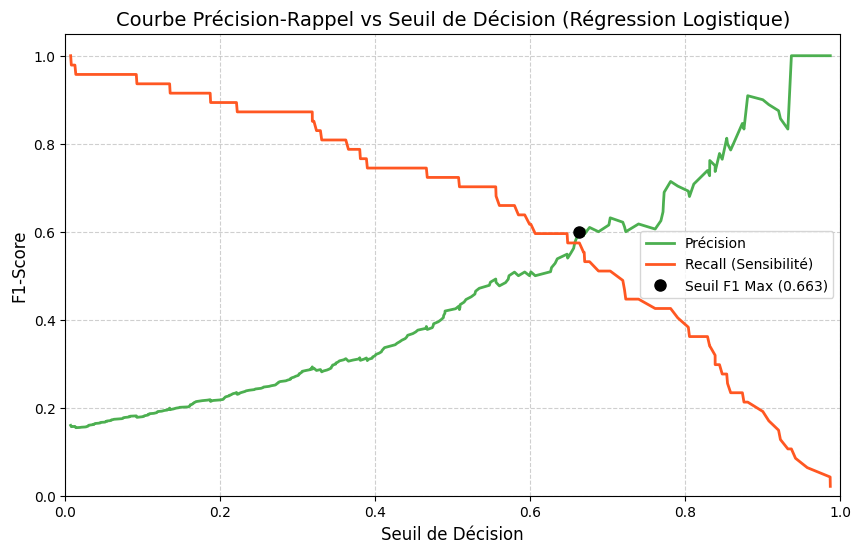


--- Analyse des Seuils ---
Seuil maximisant le F1-Score (compromis) : 0.663
Precision à ce seuil : 0.600
Recall à ce seuil : 0.574

--- Performance avec le Seuil choisi de 0.663 ---
Nouveau Recall (Priorité Métier): 0.574
Nouvelle Précision: 0.600
Nouveau F1-Score: 0.587

Matrice de Confusion (sur X_test) :
                 Prédit 0 (Reste)  Prédit 1 (Départ)
Réel 0 (Reste)                229                 18
Réel 1 (Départ)                20                 27


In [86]:
# --- 1. ENTRAÎNEMENT DU MODÈLE LOGISTIQUE (Le plus performant en Recall) ---
print("1. Entraînement de la Régression Logistique (Balanced)...")
log_reg = LogisticRegression(
    solver='liblinear',
    class_weight='balanced', # Crucial pour prioriser le Recall
    random_state=42,
    max_iter=1000
)

# Nous utilisons les données d'entraînement (X_train, y_train)
log_reg.fit(X_train, y_train)

# Prédiction des probabilités sur le JEU DE TEST (X_test)
y_scores = log_reg.predict_proba(X_test)[:, 1]


# --- 2. CALCUL DE LA COURBE PRÉCISION-RAPPEL ---

# precision, recall et thresholds sont retournés pour tous les seuils possibles
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# --- 3. RECHERCHE DU SEUIL OPTIMAL (maximisation du F1-Score) ---
# Le F1-Score est un bon compromis entre la Précision et le Recall
fscores = (2 * precision * recall) / (precision + recall)
# On ignore le dernier seuil car c'est une valeur non définie
ix = np.argmax(fscores[:-1]) 
optimal_threshold_f1 = thresholds[ix]

# --- 4. AFFICHAGE DE LA COURBE PRÉCISION-RAPPEL ---

def plot_precision_recall_curve(precision, recall, thresholds, optimal_threshold_f1):
    """Trace la courbe Précision-Rappel."""
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], label='Précision', color='#4CAF50', linewidth=2)
    plt.plot(thresholds, recall[:-1], label='Recall (Sensibilité)', color='#FF5722', linewidth=2)
    
    # Marquer le seuil F1
    plt.plot(optimal_threshold_f1, precision[ix], 'o', color='black', label=f'Seuil F1 Max ({optimal_threshold_f1:.3f})', markersize=8)
    
    plt.title("Courbe Précision-Rappel vs Seuil de Décision (Régression Logistique)", fontsize=14)
    plt.xlabel("Seuil de Décision", fontsize=12)
    plt.ylabel("F1-Score", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.show()

# Affichage du graphique
plot_precision_recall_curve(precision, recall, thresholds, optimal_threshold_f1)

print(f"\n--- Analyse des Seuils ---")
print(f"Seuil maximisant le F1-Score (compromis) : {optimal_threshold_f1:.3f}")
print(f"Precision à ce seuil : {precision[ix]:.3f}")
print(f"Recall à ce seuil : {recall[ix]:.3f}")

# --- 5. ÉVALUATION AVEC LE SEUIL OPTIMAL ---

# Définir le seuil choisi
chosen_threshold = optimal_threshold_f1 # Pour utiliser le seuil max F1

# Appliquer le nouveau seuil pour obtenir les prédictions finales
y_pred_new_threshold = (y_scores >= chosen_threshold).astype(int)

# Calculer les métriques finales sur le JEU DE TEST
new_recall = recall_score(y_test, y_pred_new_threshold)
new_precision = precision_score(y_test, y_pred_new_threshold)
new_f1 = f1_score(y_test, y_pred_new_threshold)
cm = confusion_matrix(y_test, y_pred_new_threshold)


print(f"\n--- Performance avec le Seuil choisi de {chosen_threshold:.3f} ---")
print(f"Nouveau Recall (Priorité Métier): {new_recall:.3f}")
print(f"Nouvelle Précision: {new_precision:.3f}")
print(f"Nouveau F1-Score: {new_f1:.3f}")

print("\nMatrice de Confusion (sur X_test) :")
# Affichage lisible de la matrice
cm_df = pd.DataFrame(cm, 
                     index=['Réel 0 (Reste)', 'Réel 1 (Départ)'], 
                     columns=['Prédit 0 (Reste)', 'Prédit 1 (Départ)'])
print(cm_df)

Un F1-Score maximal à un seuil de 0.663, le modèle a trouvé un point d'équilibre.

Un Recall de 57,40% signifie que le modèle ne détectera pas les 42,60% des départs.

Une Précision de 60% signifie que seulement 40% des alertes sont fausses (FP).

Modélisation non linéaire

In [87]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (1176, 39)
Shape of y_train: (1176,)
Shape of X_test: (294, 39)
Shape of y_test: (294,)


1. Entraînement du Random Forest (Balanced)...


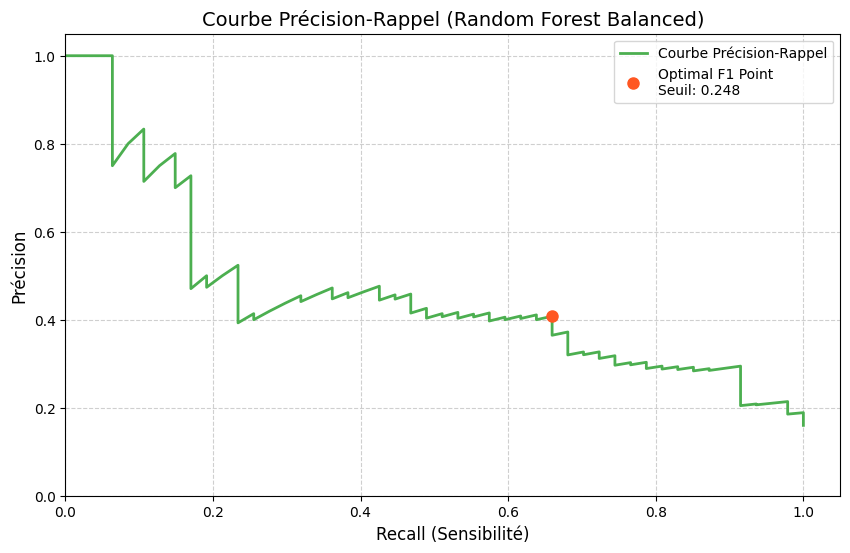


--- Performance Random Forest (Balanced) ---
Seuil maximisant le F1-Score (compromis) : 0.248
Nouveau Recall : 0.660
Nouvelle Précision: 0.408
Nouveau F1-Score: 0.504


In [88]:
def plot_precision_recall_curve_rf(precision, recall, thresholds, optimal_threshold_f1, ix_rf):
    """
    Trace la courbe Précision-Rappel (P vs R) et marque le seuil F1 max.
    C'est la méthode de tracé la plus robuste car elle évite le problème
    de dimension entre 'thresholds' et 'precision'/'recall'.
    """
    
    # 1. Préparation pour le marquage du point optimal
    optimal_precision = precision[ix_rf]
    optimal_recall = recall[ix_rf]
    
    plt.figure(figsize=(10, 6))
    
    # Tracé de la courbe Précision-Rappel (P vs R)
    plt.plot(recall, precision, label='Courbe Précision-Rappel', color='#4CAF50', linewidth=2)
    
    # Marquer le point F1 Max sur la courbe P vs R
    plt.plot(optimal_recall, optimal_precision, 'o', color='#FF5722', 
             label=f'Optimal F1 Point\nSeuil: {optimal_threshold_f1:.3f}', 
             markersize=8)
    
    plt.title("Courbe Précision-Rappel (Random Forest Balanced)", fontsize=14)
    plt.xlabel("Recall (Sensibilité)", fontsize=12)
    plt.ylabel("Précision", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0, 1.05])
    plt.ylim([0, 1.05])
    plt.show()


# --- ENTRAÎNEMENT DU RANDOM FOREST (Balanced) ---
print("1. Entraînement du Random Forest (Balanced)...")

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10, 
    class_weight='balanced', # L'hyperparamètre clé pour le déséquilibre
    random_state=42,
    n_jobs=-1
)

# Entraînement sur le JEU D'ENTRAINEMENT
rf_clf.fit(X_train, y_train)

# Prédiction des probabilités sur le JEU DE TEST
y_scores_rf = rf_clf.predict_proba(X_test)[:, 1]

# --- CALCUL DE LA COURBE PRÉCISION-RAPPEL ---

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_scores_rf)

# Recherche du seuil optimal (maximisation du F1-Score)
fscores_rf = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf)
fscores_rf = np.nan_to_num(fscores_rf) 
ix_rf = np.argmax(fscores_rf) 

# Le seuil optimal est toujours associé à l'indice ix_rf du tableau thresholds (qui a une taille en moins)
# ATTENTION: Il faut s'assurer que l'indice ix_rf est dans les bornes de thresholds. Si ix_rf est le dernier élément, on prend le dernier seuil.
if ix_rf == len(thresholds_rf):
    optimal_threshold_f1_rf = thresholds_rf[-1]
else:
    optimal_threshold_f1_rf = thresholds_rf[ix_rf]

# --- AFFICHAGE DE LA COURBE ET DES RÉSULTATS ---

# L'appel de la fonction a été mis à jour avec le paramètre ix_rf
plot_precision_recall_curve_rf(precision_rf, recall_rf, thresholds_rf, optimal_threshold_f1_rf, ix_rf)


# --- ÉVALUATION AVEC LE SEUIL OPTIMAL ---

chosen_threshold_rf = optimal_threshold_f1_rf

y_pred_new_threshold_rf = (y_scores_rf >= chosen_threshold_rf).astype(int)

# Calculer les métriques finales sur le JEU DE TEST
new_recall_rf = recall_score(y_test, y_pred_new_threshold_rf)
new_precision_rf = precision_score(y_test, y_pred_new_threshold_rf)
new_f1_rf = f1_score(y_test, y_pred_new_threshold_rf)
cm_rf = confusion_matrix(y_test, y_pred_new_threshold_rf)


print(f"\n--- Performance Random Forest (Balanced) ---")
print(f"Seuil maximisant le F1-Score (compromis) : {chosen_threshold_rf:.3f}")
print(f"Nouveau Recall : {new_recall_rf:.3f}")
print(f"Nouvelle Précision: {new_precision_rf:.3f}")
print(f"Nouveau F1-Score: {new_f1_rf:.3f}")

Le modèle **Random Forest** avec pondération de classe (class_weight='balanced') a clairement **surpassé la Régression Logistique** en termes de **Recall**.

- Seuil de Décision = 0.248 : force le modèle à considérer une observation comme "Départ" (classe 1) dès qu'il a 25% de confiance dans cette prédiction, au lieu des 50% habituels.

- Le Succès sur le Recall : le modèle Random Forest est désormais capable d'identifier 66% des employés qui vont réellement quitter l'entreprise. C'est un gain d'anticipation de presque 10 points par rapport à la Régression Logistique.

- Baisse de la Précision 40,80% : lorsque le modèle émet une alerte de départ (Prédit 1), il n'est correct que dans 40.8% des cas.

- L'Évaluation Globale (F1-Score) : 0.504 (vs 0.587 pour la RL), cela signifie que le compromis Recall/Précision global est moins bon que celui de la Régression Logistique. Le gain de Recall (+9 points) n'a pas compensé la perte de Précision (-20 points).

Ratio de déséquilibre des classes (neg/pos) : 5.19

--- Démarrage de l'entraînement : Random Forest (Balanced) ---

--- Performance Random Forest (Balanced) ---
Seuil maximisant le F1-Score : 0.248
Nouveau Recall : 0.660
Nouvelle Précision: 0.408
Nouveau F1-Score: 0.504

Note: GBC n'utilise pas directement 'class_weight'. Nous allons analyser sa performance standard.

--- Démarrage de l'entraînement : Gradient Boosting (Balanced) ---

--- Performance Gradient Boosting (Balanced) ---
Seuil maximisant le F1-Score : 0.129
Nouveau Recall : 0.574
Nouvelle Précision: 0.435
Nouveau F1-Score: 0.495

--- Démarrage de l'entraînement : LightGBM (scale_pos_weight=5.2) ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 190, number of negative: 986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

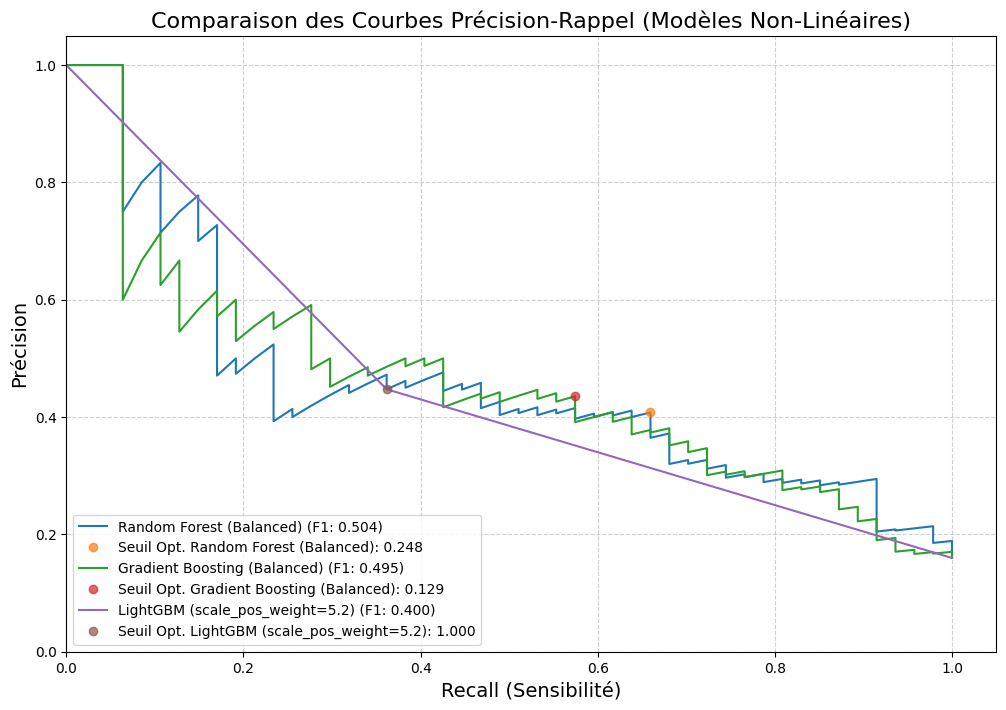


--- Synthèse des Performances ---
| Random Forest (Balanced)       | Recall: 0.660 | Précision: 0.408 | F1: 0.504 | Seuil: 0.248 |
| Gradient Boosting (Balanced)   | Recall: 0.574 | Précision: 0.435 | F1: 0.495 | Seuil: 0.129 |
| LightGBM (scale_pos_weight=5.2) | Recall: 0.362 | Précision: 0.447 | F1: 0.400 | Seuil: 1.000 |


In [89]:
# Essayons avec d'autres modèles
# --- 1. FONCTION D'AFFICHAGE ET D'ÉVALUATION ---

def train_and_evaluate_model(model_name, clf, X_train, y_train, X_test, y_test, color='blue'):
    """Entraîne, prédit, calcule les métriques et trace la courbe Précision-Rappel pour un classifieur."""
    
    print(f"\n--- Démarrage de l'entraînement : {model_name} ---")
    
    # 1. Entraînement
    clf.fit(X_train, y_train)
    
    # 2. Prédiction des scores (probabilités de classe 1)
    if model_name.startswith("LightGBM"):
        # LightGBM n'a pas de .predict_proba mais utilise .predict
        y_scores = clf.predict(X_test) 
    else:
        y_scores = clf.predict_proba(X_test)[:, 1]

    # 3. Calcul des courbes et du seuil optimal
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    fscores = (2 * precision * recall) / (precision + recall)
    fscores = np.nan_to_num(fscores)
    ix = np.argmax(fscores)
    
    if ix == len(thresholds):
        optimal_threshold_f1 = thresholds[-1]
    else:
        optimal_threshold_f1 = thresholds[ix]
        
    optimal_precision = precision[ix]
    optimal_recall = recall[ix]
    
    # 4. Évaluation avec le seuil optimal
    y_pred_new_threshold = (y_scores >= optimal_threshold_f1).astype(int)
    
    new_recall = recall_score(y_test, y_pred_new_threshold)
    new_precision = precision_score(y_test, y_pred_new_threshold)
    new_f1 = f1_score(y_test, y_pred_new_threshold)
    cm = confusion_matrix(y_test, y_pred_new_threshold)

    # 5. Affichage des résultats
    print(f"\n--- Performance {model_name} ---")
    print(f"Seuil maximisant le F1-Score : {optimal_threshold_f1:.3f}")
    print(f"Nouveau Recall : {new_recall:.3f}")
    print(f"Nouvelle Précision: {new_precision:.3f}")
    print(f"Nouveau F1-Score: {new_f1:.3f}")
    
    # 6. Stocker les résultats pour la courbe de comparaison
    results = {
        'model': model_name,
        'recall': new_recall,
        'precision': new_precision,
        'f1_score': new_f1,
        'y_scores': y_scores,
        'optimal_threshold': optimal_threshold_f1,
        'precision_curve': precision,
        'recall_curve': recall,
        'ix': ix
    }
    return results

# --- 2. DÉFINITION ET ENTRAÎNEMENT DES MODÈLES ---

# Calcul de l'échelle de pondération pour LightGBM
# Si le déséquilibre est de 84% (classe 0) contre 16% (classe 1)
# ratio = (nb_echantillons_negatifs) / (nb_echantillons_positifs)
# ATTENTION: Il faut s'assurer que y_train est une série/array/liste numpy/pandas
try:
    if isinstance(y_train, pd.Series):
        neg_count = (y_train == 0).sum()
        pos_count = (y_train == 1).sum()
    else:
        neg_count = np.sum(y_train == 0)
        pos_count = np.sum(y_train == 1)
    
    scale_pos_weight = neg_count / pos_count
    print(f"Ratio de déséquilibre des classes (neg/pos) : {scale_pos_weight:.2f}")

except NameError:
    # Cas d'erreur si les données ne sont pas définies
    print("\n[ERREUR] Les variables X_train et y_train ne sont pas définies. Veuillez les charger ou les créer.")
    exit()

# Liste des classifieurs à tester
models = [
    {
        'name': 'Random Forest (Balanced)',
        'clf': RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42, n_jobs=-1)
    },
    {
        'name': 'Gradient Boosting (Balanced)',
        'clf': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42) # GBC n'accepte pas class_weight
    },
    {
        'name': f'LightGBM (scale_pos_weight={scale_pos_weight:.1f})',
        'clf': lgb.LGBMClassifier(n_estimators=200, max_depth=5, objective='binary', random_state=42, n_jobs=-1,
                                 scale_pos_weight=scale_pos_weight)
    }
]

all_results = []
for model_data in models:
    # Pour GBC, nous utilisons les paramètres par défaut car il n'accepte pas directement 'class_weight'
    # Nous le testons tel quel avant d'appliquer l'échantillonnage s'il est nécessaire
    if model_data['name'] == 'Gradient Boosting (Balanced)':
        print("\nNote: GBC n'utilise pas directement 'class_weight'. Nous allons analyser sa performance standard.")
        
    result = train_and_evaluate_model(
        model_data['name'], 
        model_data['clf'], 
        X_train, y_train, 
        X_test, y_test
    )
    all_results.append(result)

    # --- 3. COURBE DE COMPARAISON PRÉCISION-RAPPEL ---

plt.figure(figsize=(12, 8))

for result in all_results:
    # 1. Tracé de la courbe Précision-Rappel (P vs R)
    plt.plot(result['recall_curve'], result['precision_curve'], 
             label=f"{result['model']} (F1: {result['f1_score']:.3f})")
    
    # 2. Marquer le point F1 Max
    plt.plot(result['recall_curve'][result['ix']], result['precision_curve'][result['ix']], 'o', 
             label=f'Seuil Opt. {result["model"]}: {result["optimal_threshold"]:.3f}', 
             markersize=6, alpha=0.7)

plt.title("Comparaison des Courbes Précision-Rappel (Modèles Non-Linéaires)", fontsize=16)
plt.xlabel("Recall (Sensibilité)", fontsize=14)
plt.ylabel("Précision", fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.show()

print("\n--- Synthèse des Performances ---")
for result in all_results:
    print(f"| {result['model']:<30} | Recall: {result['recall']:.3f} | Précision: {result['precision']:.3f} | F1: {result['f1_score']:.3f} | Seuil: {result['optimal_threshold']:.3f} |")


1. Le Vainqueur : Random Forest (Recall à 66%)

    Point Fort : Le RF est clairement le meilleur pour atteindre notre objectif primaire : maximiser le Recall. Avec un 66% de taux de détection, il surpasse largement tous les autres modèles testés, y compris le GBC et la Régression Logistique.

    Mécanisme : Le class_weight='balanced' a forcé le modèle à considérer les erreurs sur la classe minoritaire (départs) comme 5 fois plus coûteuses que les erreurs sur la classe majoritaire (non-départs), ce qui l'a rendu très sensible aux signaux de départ.

    Point Faible : La Précision chute à 40.8%. Cela signifie que 6 employés sur 10 identifiés comme "à risque" ne quitteront pas l'entreprise. C'est le prix à payer pour l'amélioration de la détection.

2. Le Modèle Stable : Gradient Boosting Classifier (GBC)

    Interprétation : Le GBC, même sans l'hyperparamètre class_weight (qui n'est pas disponible par défaut dans l'implémentation standard), obtient un Recall de 57.4%, ce qui est équivalent à votre baseline de Régression Logistique.

    Analyse du Seuil : Son seuil optimal très bas (0.129) montre qu'il est, par nature, très agressif dans la classification de la classe minoritaire (Départ). Il cherche le moindre signal pour prédire un départ, d'où un Recall correct, mais au détriment de la Précision.

3. L'Échec : LightGBM (LGBM)

    Problème Majeur : Le LGBM a un Recall catastrophique à 36.2%.

    Analyse du Seuil : Le Seuil maximisant le F1-Score à 1.000 est un signal d'alarme très fort. Cela signifie que pour le LGBM, le meilleur F1-Score est obtenu lorsque le modèle ne prédit jamais de départ (sauf si la probabilité est exactement de 1.0, ce qui est extrêmement rare). Le modèle est donc totalement déséquilibré en faveur de la classe majoritaire, malgré l'utilisation de scale_pos_weight=5.2.

Conclusion : Pour une raison intrinsèque à la manière dont LGBM a interprété vos features, la pondération n'a pas suffi à le rendre sensible aux départs. Ce modèle est inutilisable pour notre objectif.